# Modeling Stock Prices and Portfolios prediction - Project#5

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***June, 2023***
* Instructor name: ***Abhineet Kulkarni***

# Business Problem
**We would like to invest some money into stock market and want to build a portfolio that will maximize returns with as little risk as possible. We therefore want to minimize the risk involved while maximizing the profit.**

# Analysis Approach
* This is a multi-step problem that can be divided as follows:
    * First step us to build models that can predict the stock prices. The idea is that even though the model can not get the stock prices right, it should be able to predict the general trend of ups and downs in the stcoks movement. We will try to use a couple of models and compare their performance:
        * First would be Vanilla LSTM model
        * Stacked LSTM model
        * ARIMA/GARCH models: done here only as exploratory analysis and will be included later as  keep improving the code quality.
    * Once we have a reliable model, we will generate predictions and then calculate returns on stocks and eventually build profitable portifolios.
    * We will use **Shapre Ratio** as one of measures to predict portfolios.
* <span style="color:lightblue"> One needs to include sentinet analysis as well to understand the effect of news and other factors on stocks price movement. However, at this point, we have not included it due to lack of time. </span>.
* <span style="color:lightblue"> Other thing to include is the information contained in the SEC filings of the companies and incorporate that into models.</span>

# Executive Summary
* To Be added once the project is complete

In [2]:
#Import all the needed libraries
import requests
import json
import os, sys, shutil,time
print(sys.executable)

# import basic libs
import pandas as pd
import numpy as np
import random
import math
import datetime

#import plotting libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

#import sklearn libs
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score,confusion_matrix, classification_report

#import statsmodels related stuff
import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

#import NN/Keras related libs

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.metrics import mean_absolute_percentage_error
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# stock related imports
import yfinance as yf

from ta import add_all_ta_features 
from ta.utils import dropna
from arch import arch_model

from fastai.tabular.core import add_datepart
from finta import TA

#import warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/anaconda3/bin/python


* Additional libraries that were installed

In [31]:
#!pip install finta
#pip install arch
#!pip install fastai
#!pip install ta

# Data Collection
* For now we will use the top 100 companies by weight as listed in S&P. Below is the list of symbols that has to be used for downloading the data.

## Define the tickers (symbols) for the topmost 100 S&P500 companies:

* We may only use a few (topmost 29 companies by weight for now) for our current project. Later once the analysis is more solid, we can include all the 100 or 500 that can be used for the portfolio prediction. The symbols and abbreviations can be found at the following link (https://www.slickcharts.com/sp500).
* The chosen order of symbols in the list is based on their weights in S&P index as described in the above mentioned link.

## Yahoo Finance to Download the DATA

* We will use the **yfinance** library in Python to download the data. Though Quandl provides more information on the data, it is not free anymore and is a paid service. 
* I chose a period of 10 years to look at the historical data. Also this period is used so that all the listed companies have data for the selected period.

In [3]:
#S&P top 30 companies by weight
#https://www.slickcharts.com/sp500
SP500_top30 =['AAPL','MSFT', 'AMZN','NVDA','GOOGL','GOOG','TSLA','META','UNH','XOM','JNJ','JPM',\
             'JPM','V','LLY','PG','AVGO','MA','HD','CVX','MRK','PEP','KO','COST','PFE','WMT','MCD',\
              'BAC','CRM']#'ABBV'
# period of 16 years from 12-31-2022 backwards go back to 01-04-2008
date_range = ('06-01-2012', '12-31-2022')
max_stocker = '05-31-2023'
INTERVAL = '1d'
min_date = datetime.datetime.strptime(date_range[0], "%m-%d-%Y")
max_date = datetime.datetime.strptime(max_stocker, "%m-%d-%Y")

In [4]:
tickers = SP500_top30[0:29]
tickerobjs = {} 
for ticker in tickers:
    tickerobjs[ticker] = yf.download(ticker, start=min_date, end=max_date, interval=INTERVAL)
    tickerobjs[ticker]= tickerobjs[ticker].reset_index(level=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Data Exploration, Cleaning and Feature Engineering
* We will first look at the minimum and maximum dates for all these stocks. Just for simplicity we want to mke sure that all the stocks have data for the period we selected

In [5]:
for i, (k, v) in enumerate(tickerobjs.items()):
    print(k, min(v['Date']), min(v['Adj Close']), max(v['Adj Close']))

AAPL 2012-06-01 00:00:00 12.02955150604248 180.43429565429688
MSFT 2012-06-01 00:00:00 21.6423282623291 338.3359375
AMZN 2012-06-01 00:00:00 10.41100025177002 186.57049560546875
NVDA 2012-06-01 00:00:00 2.6102914810180664 401.0684814453125
GOOGL 2012-06-01 00:00:00 13.990240097045898 149.8385009765625
GOOG 2012-06-01 00:00:00 13.92405891418457 150.70899963378906
TSLA 2012-06-01 00:00:00 1.7400000095367432 409.9700012207031
META 2012-06-01 00:00:00 17.729999542236328 382.17999267578125
UNH 2012-06-01 00:00:00 43.05183792114258 549.2251586914062
XOM 2012-06-01 00:00:00 26.335973739624023 117.32194519042969
JNJ 2012-06-01 00:00:00 45.551448822021484 179.75254821777344
JPM 2012-06-01 00:00:00 22.77521514892578 164.01576232910156
V 2012-06-01 00:00:00 25.96466636657715 247.30252075195312
LLY 2012-06-01 00:00:00 30.62030601501465 442.3800048828125
PG 2012-06-01 00:00:00 42.930503845214844 159.20980834960938
AVGO 2012-06-01 00:00:00 22.7515869140625 812.72998046875
MA 2012-06-01 00:00:00 36.7

Lets just look at first index and see how the data looks like

In [6]:
tickerobjs['AAPL']

Date        Open        High         Low       Close   Adj Close   
0    2012-06-01   20.327143   20.451786   20.018572   20.035357   17.028908  \
1    2012-06-04   20.053572   20.267857   19.589287   20.153214   17.129074   
2    2012-06-05   20.045357   20.231071   19.940357   20.101070   17.084759   
3    2012-06-06   20.277500   20.494642   20.196428   20.409286   17.346722   
4    2012-06-07   20.617500   20.618570   20.375000   20.418571   17.354609   
...         ...         ...         ...         ...         ...         ...   
2761 2023-05-23  173.130005  173.380005  171.279999  171.559998  171.559998   
2762 2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2763 2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2764 2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2765 2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   

         Volume  
0     520987600  
1     556995600  
2     388214400  
3     401455600  
4     379766800  
...         ...  
2761   50747300  
2762   45143500  
2763   56058300  
2764   54835000  
2765   55964400  

[2766 rows x 7 columns]

## Stationarity Test
* Original Series Stationarity Check: We are going to look at only one stock for these studies "AAPL". Later I will incorporate a more elegant technique to look collectively at all the stocks involved in analysis

In [7]:
# Lets load some libraries needed for this
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import scipy.stats as scs

In [18]:
#Define a function to look at the time-series which will show autocorrelation, partial auto-correlation,
#qq plots and a probablilty plot
def tsplot(series, lags=30, figsize=(12, 8), style='bmh'):
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        y = series
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout  = (2, 2)
        #ts_ax   = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax  = plt.subplot2grid(layout, (0, 0))
        pacf_ax = plt.subplot2grid(layout, (0, 1))
        qq_ax   = plt.subplot2grid(layout, (1, 0))
        pp_ax   = plt.subplot2grid(layout, (1, 1))
        
        #y.plot(ax=ts_ax)
        #ts_ax.plot()
        #ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, zero = False, ax=acf_ax, alpha=0.5)
        plot_pacf(y, lags=lags, zero= False, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [15]:
#ADFuller test is another means to look at the stationarity of series in question
def print_adfuller_test(series):
    significance=.05
    results = adfuller(series,autolag='AIC')
    dfresults = pd.Series(results[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key,value in results[4].items():
        dfresults['Critical Value (%s)'%key] = value
        
    print('Augmented Dickey-Fuller Test Results:')
    print(dfresults)    
    if(results[1])<0.05:
        print ("Series is stationary")
    else:
        print ("Series is *NOT* stationary")

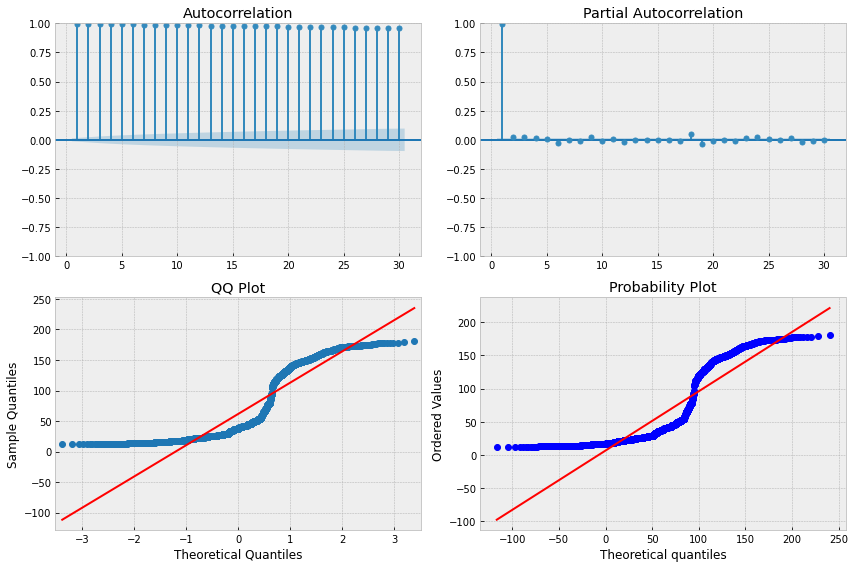

In [19]:
tsplot(tickerobjs['AAPL']['Adj Close'], lags=30)

In [20]:
print_adfuller_test(tickerobjs['AAPL']['Adj Close'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic         0.646704
P-Value                    0.988712
# Lags Used               22.000000
# Observations Used     2743.000000
Critical Value (1%)       -3.432736
Critical Value (5%)       -2.862594
Critical Value (10%)      -2.567331
dtype: float64
Series is *NOT* stationary


## Transformation Techniques
Clearly this series is Non-Stationary as can be seen from QQ, Probabilty plots and also the large p-value for ADFuller test(Null Hypothesis: series is staionary). So before one applies the ARIMA Models, it needs to be transformed to stationary using one of the following transofomations.
* **Log Transformation:** Taking the log of each data point will dampen the effect of variance over time
* **Differencing:** Taking the difference between consecutive data points usually removes the trend changes over time.
* **Log Tranformation followed by Differencing (not used here):** This technique removes both mean and variance changes over time. We will nly look at the first two as those two transformations seem to work for this dataset

To see which tranformation works best for our use case, lets plot the data and its summary statistics over time.

In [25]:
def add_log_returns(df):
    df.set_index("Date", inplace=True)
    df.loc[df.index, 'LogRets'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df.loc[df.index[0], 'LogRets'] = 0
    df.loc[df.index,"Diff"] = df["Adj Close"].diff()
    df.loc[df.index[0], 'Diff'] = 0
    #df.loc[df.index, 'CumLogRets'] = df['LogRets'].cumsum()
    #df.loc[df.index, 'CumRets']   = np.exp(df['CumLogRets'])

In [26]:
eda_df = tickerobjs['AAPL'].copy()
add_log_returns(eda_df)
eda_df

Open        High         Low       Close   Adj Close   
Date                                                                     
2012-06-01   20.327143   20.451786   20.018572   20.035357   17.028908  \
2012-06-04   20.053572   20.267857   19.589287   20.153214   17.129074   
2012-06-05   20.045357   20.231071   19.940357   20.101070   17.084759   
2012-06-06   20.277500   20.494642   20.196428   20.409286   17.346722   
2012-06-07   20.617500   20.618570   20.375000   20.418571   17.354609   
...                ...         ...         ...         ...         ...   
2023-05-23  173.130005  173.380005  171.279999  171.559998  171.559998   
2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   

               Volume   LogRets      Diff  
Date                                       
2012-06-01  520987600  0.000000  0.000000  
2012-06-04  556995600  0.005865  0.100166  
2012-06-05  388214400 -0.002590 -0.044315  
2012-06-06  401455600  0.015217  0.261963  
2012-06-07  379766800  0.000455  0.007887  
...               ...       ...       ...  
2023-05-23   50747300 -0.015271 -2.639999  
2023-05-24   45143500  0.001631  0.279999  
2023-05-25   56058300  0.006670  1.150009  
2023-05-26   54835000  0.014006  2.439987  
2023-05-30   55964400  0.010603  1.870010  

[2766 rows x 8 columns]

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.684042e+01
P-Value                 1.139283e-29
# Lags Used             8.000000e+00
# Observations Used     2.757000e+03
Critical Value (1%)    -3.432724e+00
Critical Value (5%)    -2.862589e+00
Critical Value (10%)   -2.567328e+00
dtype: float64
Series is stationary


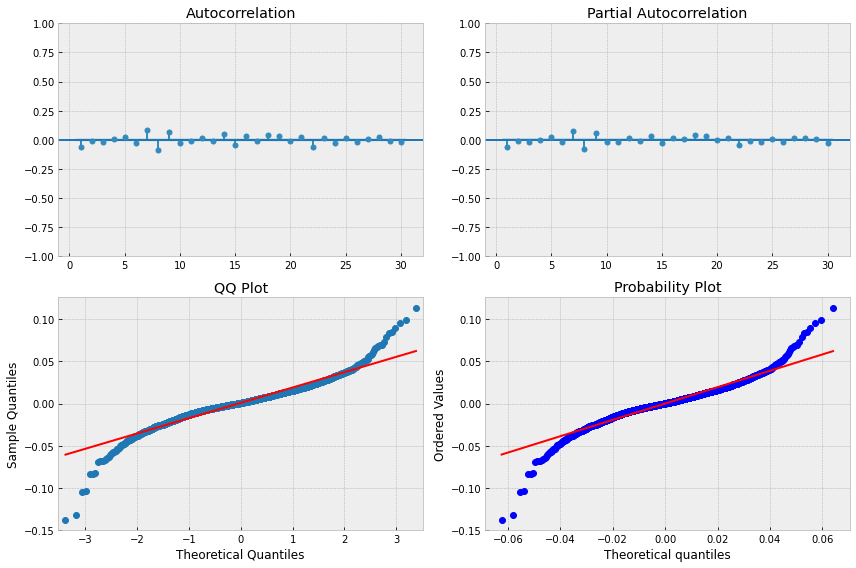

In [29]:
tsplot(eda_df['LogRets'], lags=30)
print_adfuller_test(eda_df['LogRets'])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.090707e+01
P-Value                 1.121122e-19
# Lags Used             2.100000e+01
# Observations Used     2.744000e+03
Critical Value (1%)    -3.432735e+00
Critical Value (5%)    -2.862594e+00
Critical Value (10%)   -2.567331e+00
dtype: float64
Series is stationary


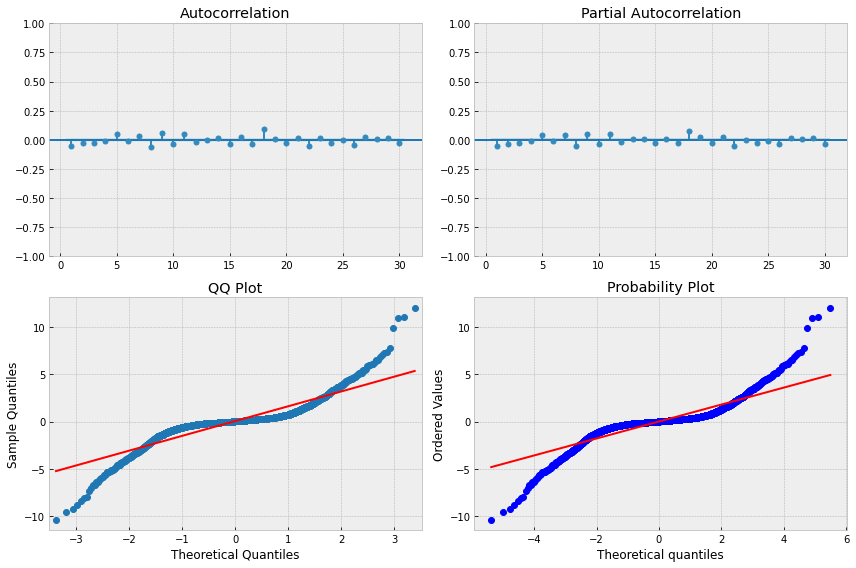

In [30]:
tsplot(eda_df['Diff'], lags=30)
print_adfuller_test(eda_df['Diff'])

* The p-values for both the Log returns and differenced returns are very very small, implying that those series are stationary. However, the qq plot looks better for log-returns. So ffor ARCH/GARCH models we need to build our models on logreturns.
* I have done the ARIMA/GARCH models on logreturns in the other notebook contained in the same directory "EDA.ipynb". Those studies need more exploration for developing a model

## Adding Financial Indicators to the Data
* We will add a few financial indicators to the data. For this we have used the python library **FINTA**(https://pypi.org/project/finta/).
    * **Moving Averages (MA)**: Moving averages smooth out price data over a specific time period, providing a clearer view of the underlying trend. Common types include the Simple Moving Average (SMA) and the **Exponential Moving Average (EMA)**. We will use EMA.
    * **Relative Strength Index (RSI)**: RSI is a momentum oscillator that measures the speed and change of price movements. It helps identify overbought and oversold conditions, indicating potential reversals or trend continuations.
    * **Moving Average Convergence Divergence (MACD)**: MACD is a trend-following momentum indicator that shows the relationship between two moving averages. It provides signals for potential buy and sell opportunities when the lines cross or diverge. 
    * **Bollinger Bands**: Bollinger Bands consist of a moving average and upper and lower bands that represent the standard deviation from the moving average. They help identify periods of high or low volatility and potential price reversals.
    * **Average True Range (ATR)**: ATR measures the volatility of a stock or market by considering the range between high and low prices over a specific period. It helps assess potential price movements and set stop-loss levels.
    * **On-balance volume (OBV)**: OBV is a technical trading momentum indicator that uses volume flow to predict changes in stock price
    * **Ichimoku Cloud**: The Ichimoku Cloud is a comprehensive indicator that provides insights into support and resistance levels, trend direction, and momentum. It consists of various lines and a cloud area.

* Another library that we will use is **FASTAI**. This provides with a functionality *add_datepart* that adds features such as *year, month, week,day, day of the week, day of the month, day of the year* and a few others. For complete documentation please see this link(https://docs.fast.ai).

In [32]:
stocks_data = {}

for i, (ticker, stocker) in enumerate(tickerobjs.items()):
    #df = stocker.make_df(date_range[0], date_range[1])
    df = stocker
    # ddd date features
    add_datepart(df, 'Date', drop=False)
    df = df.rename(columns={"Open": "open", "Close": "close", "Low": "low", "High": "high","Volume": "volume"})
    ema = TA.EMA(df)
    bb  = TA.BBANDS(df)
    rsi = TA.RSI(df)
    macd = TA.MACD(df)
    atr  = TA.ATR(df)
    ichimoku = TA.ICHIMOKU(df)
    obv      = TA.OBV(df)
    # drop unwanted columns date feature columns
    df = df.drop(['Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'], axis=1)
    df['Is_month_end'] = df['Is_month_end'].astype(int)
    df['Is_month_start'] = df['Is_month_start'].astype(int)
    df['Exponential_moving_average'] = ema.copy()
    df = pd.concat([df, bb, rsi, macd, atr, ichimoku, obv], axis = 1)
    
    # setting index as date
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    # sort df by date
    df = df.sort_index(ascending=True, axis=0)
    df = df.dropna()
    print(f"Nan Values: {ticker},{df.isna().sum().sum()}")
    
    stocks_data[ticker] = df

Nan Values: AAPL,0
Nan Values: MSFT,0
Nan Values: AMZN,0
Nan Values: NVDA,0
Nan Values: GOOGL,0
Nan Values: GOOG,0
Nan Values: TSLA,0
Nan Values: META,0
Nan Values: UNH,0
Nan Values: XOM,0
Nan Values: JNJ,0
Nan Values: JPM,0
Nan Values: V,0
Nan Values: LLY,0
Nan Values: PG,0
Nan Values: AVGO,0
Nan Values: MA,0
Nan Values: HD,0
Nan Values: CVX,0
Nan Values: MRK,0
Nan Values: PEP,0
Nan Values: KO,0
Nan Values: COST,0
Nan Values: PFE,0
Nan Values: WMT,0
Nan Values: MCD,0
Nan Values: BAC,0
Nan Values: CRM,0


* Lets just make sure by looking at our AAPL stock dataframe that we have all the new added columns

In [34]:
print(type(stocks_data))
print((stocks_data["AAPL"].columns))

<class 'dict'>
Index(['Date', 'open', 'high', 'low', 'close', 'Adj Close', 'volume', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE',
       'BB_LOWER', '14 period RSI', 'MACD', 'SIGNAL', '14 period ATR',
       'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU', 'OBV'],
      dtype='object')


In [35]:
# A function to look at the distributions/trends of columns
def plot_stocks_columns(dict_df,col_name):
    plt.figure(figsize=(10, 5))
    for i, (ticker, df) in enumerate(dict_df.items()):
        plt.plot(df[col_name], linewidth=1, alpha=0.9, label=ticker)
        plt.legend()

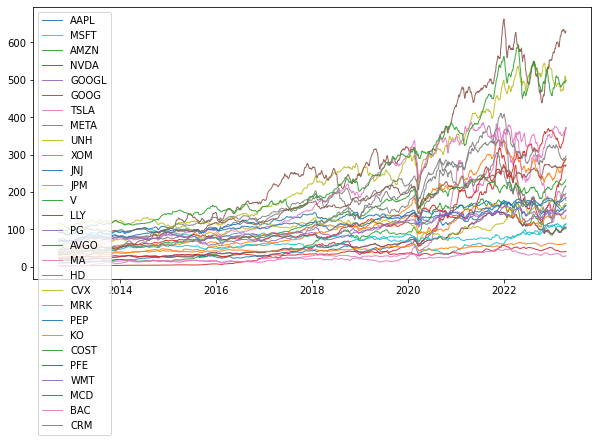

In [36]:
plot_stocks_columns(stocks_data,'Exponential_moving_average')
#plt.plot(stocks_data["AAPL"]['Exponential_moving_average'], linewidth=1, alpha=0.8, label="AAPL")

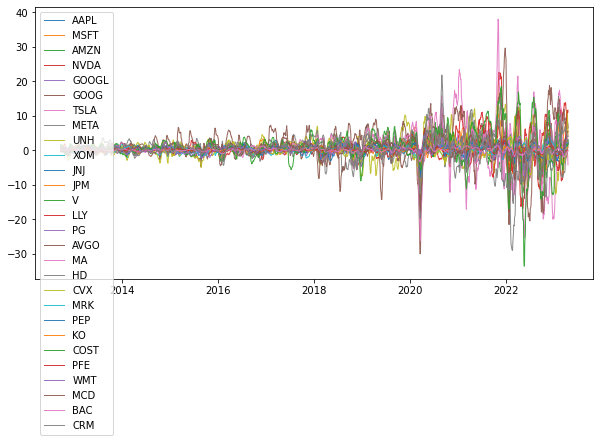

In [38]:
plot_stocks_columns(stocks_data,'MACD')

In [37]:
#plot_stocks_columns(stocks_data,'CHIKOU')

In [39]:
#plot_stocks_columns(stocks_data,'14 period RSI')

In [44]:
#plot_stocks_columns(stocks_data,'14 period ATR')

In [45]:
#plot_stocks_columns(stocks_data,'volume')

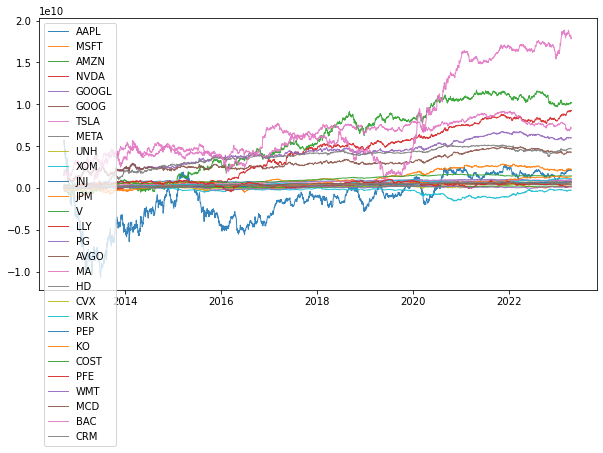

In [46]:
plot_stocks_columns(stocks_data,'OBV')

* Lets look at  the columns that are highly correlated. We will have a model built using only the columns that are not OR slightly correlated. For this again we will just focus on one stock for now and create a dropping list

In [70]:
def correlation_matrix_plot(corr_df):
    fig, ax = plt.subplots(figsize=(21,10))
    Mask = np.triu(corr_df)
    sns.heatmap(corr_df, xticklabels=corr_df.columns, yticklabels=corr_df.columns,mask=Mask,\
                annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax = ax)
    #ax.grid(True)
    plt.title('Stocks Correlation')
    ticks = np.arange(0,9,1)
    #plt.show()

In [71]:
float_df = stocks_data["AAPL"].select_dtypes(exclude = "object")
#float_df = float_df.drop(['high', 'low', 'close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER'\
#                          , 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a',\
#                         'SENKOU', 'CHIKOU'], axis=1)
float_df = float_df.drop(["Adj Close"], axis=1)
corr = float_df.corr()

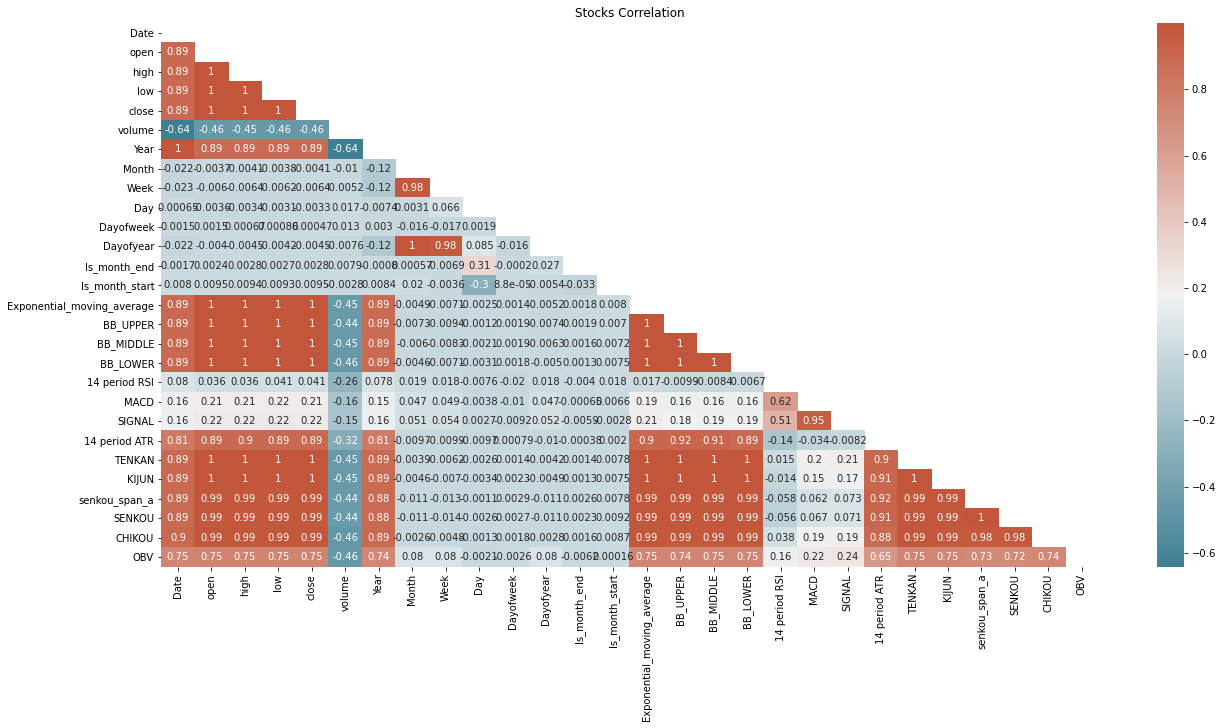

In [72]:
correlation_matrix_plot(corr)

In [73]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [74]:
#upper

In [75]:
print(to_drop)

['high', 'low', 'close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


In [76]:
#(float_df.corr(method ='pearson'))

* Although its not an issue on run-time at this point even including all the columns. It can however quickly evolve into a time-consuming affair once we will have all the 500 companies included. So lets look at what PCA tells us about the number of variables that can suffice. 
* One can autoatize this part and make it stocks-specific to be included in a more advanced analysis

In [79]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=3)
pca_2 = PCA(n_components=5)
pca_3 = PCA(n_components=6)

principalComponents = pca_1.fit_transform(corr)
principalComponents = pca_2.fit_transform(corr)
principalComponents = pca_3.fit_transform(corr)

print(np.sum(pca_1.explained_variance_ratio_))
print(np.sum(pca_2.explained_variance_ratio_))
print(np.sum(pca_3.explained_variance_ratio_))

0.9619046139610852
0.9849857008660812
0.9923903479100369


* Only 6 variables can be sufficient to achieve the same efficiency as with all the variables included

In [84]:
# This is another method to look at the important columns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# define number of features to keep
k = 10
# perform feature selection
float_df = stocks_data["AAPL"].select_dtypes(exclude = "object")
X = float_df.drop(['Adj Close','Date'],  axis=1)
y = float_df["Adj Close"]
X_new = SelectKBest(f_regression, k=k).fit_transform(X, y)
# get feature names of selected features
selected_features = X.columns[SelectKBest(f_regression, k=k).fit(X, y).get_support()]
# print selected features

print(selected_features)

Index(['open', 'high', 'low', 'close', 'Exponential_moving_average',
       'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'TENKAN', 'KIJUN'],
      dtype='object')


In [85]:
print(to_drop)

['high', 'low', 'close', 'Year', 'Week', 'Dayofyear', 'Exponential_moving_average', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'SIGNAL', 'TENKAN', 'KIJUN', 'senkou_span_a', 'SENKOU', 'CHIKOU']


# Model Creation
### LONG SHORT-TERM MEMORY (LSTM) Model:  
(https://github.com/MohammadFneish7/Keras_LSTM_Diagram)
* We will attempt to use the Long Short-Term Memory (LSTM) model, a common deep learning recurrent neural network (RNN) used in predicting time series data. The diagram credit goes to (https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/)

<img src="./lstm_diagram.png" alt="LSTM" class="bg-primary" width="600px" height="600px">

* LSTM has logic gates (input, output and forget gates) which give inherent ability for it to retain information that is more relevant and forgo unnecessary information. This makes LSTM a good model for interpreting patterns over long periods.
* The important thing to note about LSTM is the input, which needs to be in the form of a 3D vector (samples, time-steps, features). Hence, the input has to be reshaped to fit this.

## TEST TRAIN Split:
* We will perform a train test split of 80:20, with a 10% reserved for validation data set
* **Adjusted Close** will be used as "y" i.e. the column that we want to predict.

In [89]:
(stocks_data.keys())

dict_keys(['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'TSLA', 'META', 'UNH', 'XOM', 'JNJ', 'JPM', 'V', 'LLY', 'PG', 'AVGO', 'MA', 'HD', 'CVX', 'MRK', 'PEP', 'KO', 'COST', 'PFE', 'WMT', 'MCD', 'BAC', 'CRM'])

In [90]:
TRAIN_SPLIT    = 0.8  # 80% of total dataset
VAL_TEST_SPLIT = 0.5  # 50% of the remaining dataset

total_count = len(stocks_data[list(stocks_data.keys())[0]])
train_count = int(total_count * TRAIN_SPLIT)
left = total_count - train_count
valid_count = int(left * VAL_TEST_SPLIT)
test_count = int(left - valid_count)

print(sum([train_count, valid_count, test_count]))
total_count, train_count, valid_count, test_count

2658


(2658, 2126, 266, 266)

* To make sure that all the stocks included here have similar number of entries

In [91]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    print(i, ticker, len(df))

0 AAPL 2658
1 MSFT 2641
2 AMZN 2662
3 NVDA 2647
4 GOOGL 2661
5 GOOG 2663
6 TSLA 2660
7 META 2655
8 UNH 2654
9 XOM 2655
10 JNJ 2647
11 JPM 2649
12 V 2652
13 LLY 2651
14 PG 2645
15 AVGO 2658
16 MA 2659
17 HD 2657
18 CVX 2652
19 MRK 2640
20 PEP 2648
21 KO 2632
22 COST 2653
23 PFE 2627
24 WMT 2653
25 MCD 2650
26 BAC 2616
27 CRM 2654


In [322]:
#x_columns = [
#    'Open', 'High', 'Low', 'Volume', 'Month', 'Week', 'Day', 'Dayofweek', 
#    'Dayofyear', 'Is_month_end', 'Is_month_start']
#pick_columns = ['Open', 'High', 'Low', 'Volume', 'Month', 'Week', 'Day', 'Dayofweek', 
#    'Dayofyear', 'Is_month_end', 'Is_month_start','Adj Close']

In [92]:
y_column = ['Adj Close']
cols_to_delete = ['Adj Close','Date','close']

In [94]:
type(stocks_data)

dict

* The cell below creates a train-test-validation split on all the stocks dataframes based on the %age we have defined above. We created a list of dictionaries for each stock with items as dataframes corresponding to train, test, validation sets

In [95]:
for i, (ticker, df) in enumerate(stocks_data.items()):
    x_df = df.drop(columns=['Adj Close','Date'], axis=1)
    x_df = df.drop(cols_to_delete,axis=1)
    y_df = df[y_column]
    stocks_data[ticker] = {
        'x': x_df, 'y': y_df,
        'x_train': x_df[0:train_count], 'y_train': y_df[0:train_count],
        'x_valid': x_df[train_count:train_count+valid_count], 'y_valid': y_df[train_count:train_count+valid_count],
        'x_test': x_df[train_count+valid_count:], 'y_test': y_df[train_count+valid_count:],
    }

* Lets check to make sure that all the intended changes are there

In [96]:
stocks_data['AAPL']

{'x':                   open        high         low     volume  Year  Month  Week   
 Date                                                                           
 2012-09-20   24.969999   25.002144   24.772142  336568400  2012      9    38  \
 2012-09-21   25.086071   25.181070   24.977142  571589200  2012      9    38   
 2012-09-24   24.530714   24.825714   24.392857  639766400  2012      9    39   
 2012-09-25   24.580713   24.742144   24.035713  518789600  2012      9    39   
 2012-09-26   23.883572   24.024643   23.614286  576503200  2012      9    39   
 ...                ...         ...         ...        ...   ...    ...   ...   
 2023-04-17  165.089996  165.389999  164.029999   41516200  2023      4    16   
 2023-04-18  166.100006  167.410004  165.649994   49923000  2023      4    16   
 2023-04-19  165.800003  168.160004  165.539993   47720200  2023      4    16   
 2023-04-20  166.089996  167.869995  165.559998   52456400  2023      4    16   
 2023-04-21  165.050003

### Create Time Series Generators
* **Keras** provides the **TimeseriesGenerator** that can be used to automatically transform a univariate or multivariate time series dataset into a **supervised learning problem**.

* There are two parts to using the TimeseriesGenerator: **defining it** and **using it** to train models.
* In addition to specifying the input and output aspects of your time series problem, there are some additional parameters that you should configure; for example:
    * **length**: The number of lag observations to use in the input portion of each sample (e.g. 3).
    * **batch_size**: The number of samples to return on each iteration (e.g. 32).
    
We must define a length argument based on designed framing of the problem. That is the desired number of lag observations to use as input.
we must also define the batch size as the batch size of our model during training. If the number of samples in teh dataset is less than batch size, one can set the batch size in the generator and in the model to the total number of samples in generator found via calculating its length.

In [97]:
#Import all the needed libs
from numpy import hstack
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import TensorBoard, ModelCheckpoint
from time import time

## Normalization of the Data
* Below we will normalize the data using MinMaxScalar. We will perform the scaling on the whole dataset and then transform train dataset and test dataset to scaled values 

In [98]:
for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_series = []
    y_series = []
    x_train_series = []
    y_train_series = []
    x_valid_series = []
    y_valid_series = []
    x_test_series = []
    y_test_series = []
    
    ds['x_values'] = ds['x'].values
    ds['y_values'] = ds['y'].values
    
    ds['x_train_values'] = ds['x_train'].values
    ds['y_train_values'] = ds['y_train'].values
    
    ds['x_valid_values'] = ds['x_valid'].values
    ds['y_valid_values'] = ds['y_valid'].values
    
    ds['x_test_values'] = ds['x_test'].values
    ds['y_test_values'] = ds['y_test'].values
    
    # Append values
    x_series.append(ds['x_values'])
    y_series.append(ds['y_values'])
    
    x_train_series.append(ds['x_train_values'])
    y_train_series.append(ds['y_train_values'])
    
    x_valid_series.append(ds['x_valid_values'])
    y_valid_series.append(ds['y_valid_values'])
    
    x_test_series.append(ds['x_test_values'])
    y_test_series.append(ds['y_test_values'])
    

    x_dataset = hstack(tuple(x_series))
    y_dataset = hstack(tuple(y_series))

    x_train_dataset = hstack(tuple(x_train_series))
    y_train_dataset = hstack(tuple(y_train_series))

    x_valid_dataset = hstack(tuple(x_valid_series))
    y_valid_dataset = hstack(tuple(y_valid_series))

    x_test_dataset = hstack(tuple(x_test_series))
    y_test_dataset = hstack(tuple(y_test_series))

    # fit scalers on full series
    x_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    x_dataset = x_scaler.fit_transform(x_dataset)
    y_dataset = y_scaler.fit_transform(y_dataset)
    
    # Scale train and validation datasets
    x_train_dataset = x_scaler.transform(x_train_dataset)
    y_train_dataset = y_scaler.transform(y_train_dataset)

    x_valid_dataset = x_scaler.transform(x_valid_dataset)
    y_valid_dataset = y_scaler.transform(y_valid_dataset)

    x_test_dataset = x_scaler.transform(x_test_dataset)
    y_test_dataset = y_scaler.transform(y_test_dataset)
    
    ds['x_train_dataset'] = x_train_dataset
    ds['y_train_dataset'] = y_train_dataset
    
    ds['x_valid_dataset'] = x_valid_dataset
    ds['y_valid_dataset'] = y_valid_dataset
    
    ds['x_test_dataset'] = x_test_dataset
    ds['y_test_dataset'] = y_test_dataset
    
    # Store feature scalers
    ds['x_scaler'] = x_scaler
    ds['y_scaler'] = y_scaler
    
    print('*' * 5 + 'Train shapes for ' + ticker)
    print(x_train_dataset.shape, y_train_dataset.shape) 
    
    print('*' * 5 + 'Validation shapes for ' + ticker)
    print(x_valid_dataset.shape, y_valid_dataset.shape) 
    
    print('*' * 5 + 'Test shapes for ' + ticker)
    print(x_test_dataset.shape, y_test_dataset.shape) 

*****Train shapes for AAPL
(2126, 26) (2126, 1)
*****Validation shapes for AAPL
(266, 26) (266, 1)
*****Test shapes for AAPL
(266, 26) (266, 1)
*****Train shapes for MSFT
(2126, 26) (2126, 1)
*****Validation shapes for MSFT
(266, 26) (266, 1)
*****Test shapes for MSFT
(249, 26) (249, 1)
*****Train shapes for AMZN
(2126, 26) (2126, 1)
*****Validation shapes for AMZN
(266, 26) (266, 1)
*****Test shapes for AMZN
(270, 26) (270, 1)
*****Train shapes for NVDA
(2126, 26) (2126, 1)
*****Validation shapes for NVDA
(266, 26) (266, 1)
*****Test shapes for NVDA
(255, 26) (255, 1)
*****Train shapes for GOOGL
(2126, 26) (2126, 1)
*****Validation shapes for GOOGL
(266, 26) (266, 1)
*****Test shapes for GOOGL
(269, 26) (269, 1)
*****Train shapes for GOOG
(2126, 26) (2126, 1)
*****Validation shapes for GOOG
(266, 26) (266, 1)
*****Test shapes for GOOG
(271, 26) (271, 1)
*****Train shapes for TSLA
(2126, 26) (2126, 1)
*****Validation shapes for TSLA
(266, 26) (266, 1)
*****Test shapes for TSLA
(268, 26

In [99]:
stocks_data['AAPL'].keys()

dict_keys(['x', 'y', 'x_train', 'y_train', 'x_valid', 'y_valid', 'x_test', 'y_test', 'x_values', 'y_values', 'x_train_values', 'y_train_values', 'x_valid_values', 'y_valid_values', 'x_test_values', 'y_test_values', 'x_train_dataset', 'y_train_dataset', 'x_valid_dataset', 'y_valid_dataset', 'x_test_dataset', 'y_test_dataset', 'x_scaler', 'y_scaler'])

In [100]:
pd.DataFrame(stocks_data['AAPL']['x_train_dataset'])
#(stocks_data['AAPL']['y_scaler'])

0         1         2         3         4         5         6    
0     0.065851  0.063620  0.066631  0.211392  0.000000  0.727273  0.711538  \
1     0.066539  0.064681  0.067871  0.376243  0.000000  0.727273  0.711538   
2     0.063248  0.062574  0.064338  0.424065  0.000000  0.727273  0.730769   
3     0.063544  0.062079  0.062178  0.339208  0.000000  0.727273  0.730769   
4     0.059414  0.057825  0.059629  0.379690  0.000000  0.727273  0.730769   
...        ...       ...       ...       ...       ...       ...       ...   
2121  0.639281  0.648186  0.634146  0.100276  0.818182  0.181818  0.153846   
2122  0.634718  0.638344  0.627796  0.083169  0.818182  0.181818  0.153846   
2123  0.634422  0.632771  0.619572  0.083597  0.818182  0.181818  0.173077   
2124  0.623165  0.639055  0.635174  0.066166  0.818182  0.181818  0.173077   
2125  0.638925  0.639708  0.639165  0.053833  0.818182  0.181818  0.173077   

            7     8         9   ...        16        17        18        19   
0     0.633333  0.75  0.719780  ...  0.682238  0.510367  0.498959  0.024267  \
1     0.666667  1.00  0.722527  ...  0.689939  0.510193  0.499543  0.022369   
2     0.766667  0.00  0.730769  ...  0.582241  0.507739  0.499463  0.024827   
3     0.800000  0.25  0.733516  ...  0.424599  0.501933  0.498102  0.029794   
4     0.833333  0.50  0.736264  ...  0.362724  0.495349  0.495545  0.031425   
...        ...   ...       ...  ...       ...       ...       ...       ...   
2121  0.100000  0.75  0.167582  ...  0.196461  0.260146  0.302724  0.600764   
2122  0.133333  1.00  0.170330  ...  0.238554  0.252715  0.285090  0.627764   
2123  0.233333  0.00  0.178571  ...  0.152546  0.220917  0.263886  0.649001   
2124  0.266667  0.25  0.181319  ...  0.288418  0.225449  0.247935  0.670131   
2125  0.300000  0.50  0.184066  ...  0.268509  0.225549  0.235196  0.662554   

            20        21        22        23        24        25  
0     0.059592  0.056436  0.044022  0.039631  0.045364  0.965167  
1     0.059710  0.056862  0.044650  0.039631  0.043519  1.000000  
2     0.059710  0.057787  0.044856  0.040773  0.043778  0.961013  
3     0.061557  0.058822  0.046024  0.042719  0.039583  0.929398  
4     0.060275  0.058822  0.047910  0.044702  0.041245  0.894266  
...        ...       ...       ...       ...       ...       ...  
2121  0.666850  0.726718  0.749462  0.739906  0.697910  0.725102  
2122  0.661311  0.716966  0.749462  0.739906  0.716891  0.734473  
2123  0.657172  0.699923  0.749462  0.739906  0.702611  0.725065  
2124  0.657172  0.699923  0.754024  0.739906  0.717308  0.732958  
2125  0.657172  0.699923  0.756530  0.739906  0.715285  0.726137  

[2126 rows x 26 columns]

* Here we will use the KERAS TimeSeriesGenerator to create train, test and validation sample. We are using a window length of 90 days for these samples

In [102]:
window_length = 90
BATCH_SIZE = int(window_length / 5)

for i, (ticker, ds) in enumerate(stocks_data.items()):
    x_train_dataset = ds['x_train_dataset']
    y_train_dataset = ds['y_train_dataset']
    
    x_valid_dataset = ds['x_valid_dataset']
    y_valid_dataset = ds['y_valid_dataset']
    
    x_test_dataset = ds['x_test_dataset']
    y_test_dataset = ds['y_test_dataset']
    
    train_generator = TimeseriesGenerator(x_train_dataset, y_train_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Train samples for {}: {}'.format(ticker, len(train_generator)))

    valid_generator = TimeseriesGenerator(x_valid_dataset, y_valid_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Validation samples for {}: {}'.format(ticker, len(valid_generator)))

    test_generator = TimeseriesGenerator(x_test_dataset, y_test_dataset, length=window_length, batch_size=BATCH_SIZE)
    print('Test samples for {}: {}'.format(ticker, len(test_generator)))
    
    ds['train_generator'] = train_generator
    ds['valid_generator'] = valid_generator
    ds['test_generator'] = test_generator

Train samples for AAPL: 114
Validation samples for AAPL: 10
Test samples for AAPL: 10
Train samples for MSFT: 114
Validation samples for MSFT: 10
Test samples for MSFT: 9
Train samples for AMZN: 114
Validation samples for AMZN: 10
Test samples for AMZN: 10
Train samples for NVDA: 114
Validation samples for NVDA: 10
Test samples for NVDA: 10
Train samples for GOOGL: 114
Validation samples for GOOGL: 10
Test samples for GOOGL: 10
Train samples for GOOG: 114
Validation samples for GOOG: 10
Test samples for GOOG: 11
Train samples for TSLA: 114
Validation samples for TSLA: 10
Test samples for TSLA: 10
Train samples for META: 114
Validation samples for META: 10
Test samples for META: 10
Train samples for UNH: 114
Validation samples for UNH: 10
Test samples for UNH: 10
Train samples for XOM: 114
Validation samples for XOM: 10
Test samples for XOM: 10
Train samples for JNJ: 114
Validation samples for JNJ: 10
Test samples for JNJ: 10
Train samples for JPM: 114
Validation samples for JPM: 10
Tes

## Fit Stacked LSTM Model on Generator Data
* We chose 50 input layers, have added dropout and one additional layer with 50 units.
* We am also choosing an EarlyStopping parameter with *validation loss* as monitor parameter and a patiemce of 10.
* We will have to study the affect of other parameters like hyperparamter optimization such as learning rate and different optimizers.
* To check the model performnce, we will use **MAPE**, which is mean absolute percentage error.
* We will set the EPOCHS to 100.
* Also used is **TensorBoard**, which is a visualization tool provided with TensorFlow. This callback logs events for TensorBoard, including: Metrics summary plots, Training graph visualization, Weight histograms (https://keras.io/api/callbacks/tensorboard/#:~:text=TensorBoard%20is%20a%20visualization%20tool,Weight%20histograms).
* We will perform model fitting on all the 30 stocks that we started with.

In [103]:
#print(stocks_data['AAPL'].columns)

*****Training for AAPL
Epoch 1/100
114/114 [==============================] - 6s 31ms/step - loss: 0.0048 - mean_absolute_percentage_error: 23228.4023 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 16.8029
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 126541.3438 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 18.2487
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0024 - mean_absolute_percentage_error: 51240.6719 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 17.2822
Epoch 4/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0018 - mean_absolute_percentage_error: 23743.4844 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 17.6762
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0013 - mean_absolute_percentage_error: 6012.8350 - val_loss: 0.0355 - val_mean_absolute_percentage_error: 19.9682
Epoch 6/100


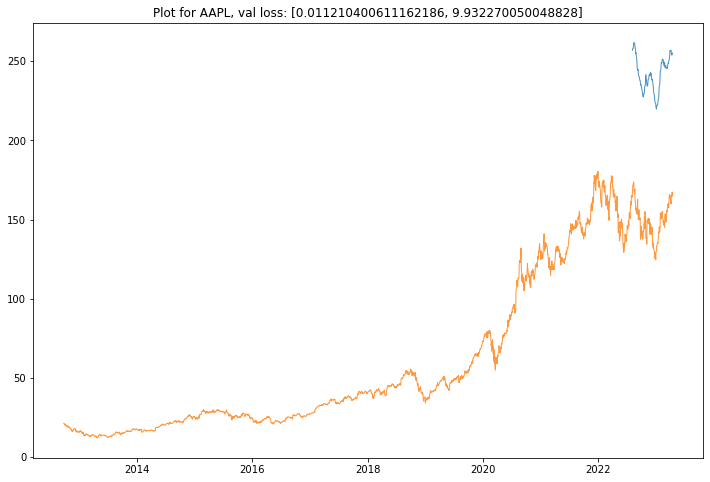

*****Training for MSFT
Epoch 1/100
114/114 [==============================] - 6s 31ms/step - loss: 0.0042 - mean_absolute_percentage_error: 133.8247 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 10.9892
Epoch 2/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0047 - mean_absolute_percentage_error: 178.9147 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 13.8693
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0019 - mean_absolute_percentage_error: 100.8560 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 15.7801
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 65.3494 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 11.4630
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 9.9876e-04 - mean_absolute_percentage_error: 33.7590 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 8.6093
Epoch 6/100
114/114 [

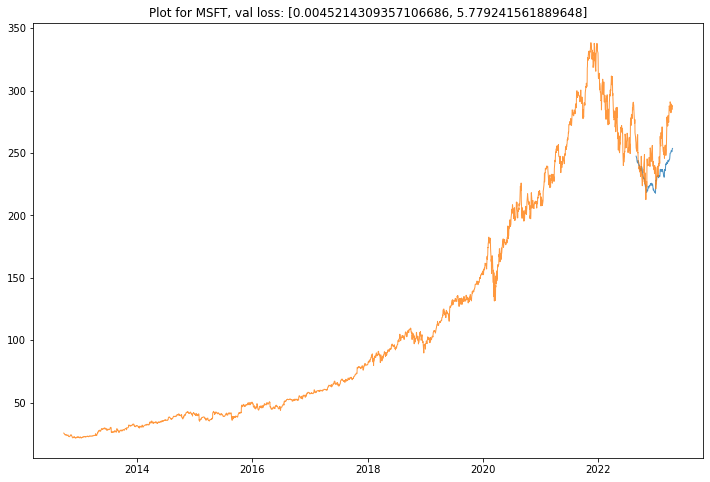

*****Training for AMZN
Epoch 1/100
114/114 [==============================] - 6s 28ms/step - loss: 0.0076 - mean_absolute_percentage_error: 68.4290 - val_loss: 0.0606 - val_mean_absolute_percentage_error: 24.7847
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0088 - mean_absolute_percentage_error: 149.1519 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 6.2411
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0105 - mean_absolute_percentage_error: 171.5697 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 6.5753
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0110 - mean_absolute_percentage_error: 166.4988 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 12.2454
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0065 - mean_absolute_percentage_error: 118.4933 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 13.8429
Epoch 6/100
114/114 [====

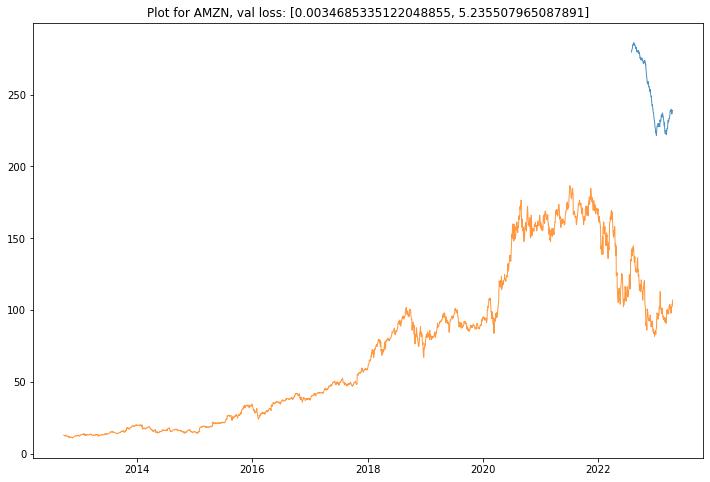

*****Training for NVDA
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0023 - mean_absolute_percentage_error: 504.3205 - val_loss: 0.1139 - val_mean_absolute_percentage_error: 42.0641
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 981.2488 - val_loss: 0.1317 - val_mean_absolute_percentage_error: 45.3581
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0039 - mean_absolute_percentage_error: 812.0856 - val_loss: 0.0526 - val_mean_absolute_percentage_error: 25.6710
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 936.5673 - val_loss: 0.0630 - val_mean_absolute_percentage_error: 29.0193
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 8.9034e-04 - mean_absolute_percentage_error: 292.5248 - val_loss: 0.0737 - val_mean_absolute_percentage_error: 32.1725
Epoch 6/100
114/11

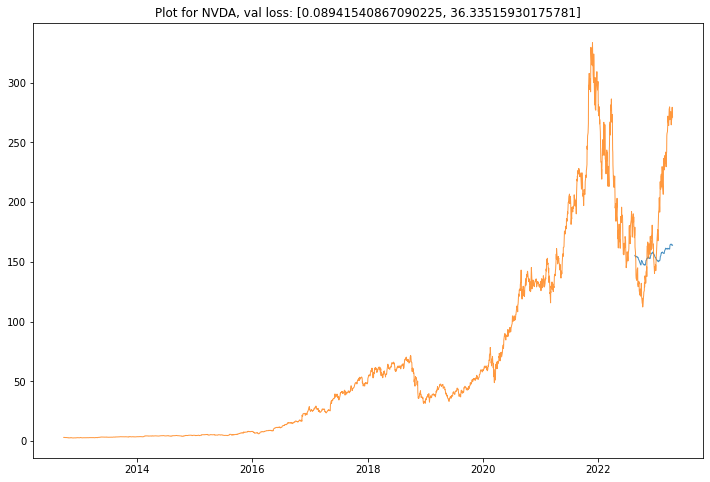

*****Training for GOOGL
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0053 - mean_absolute_percentage_error: 52.1165 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 10.7858
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0073 - mean_absolute_percentage_error: 75.5597 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 9.5506
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0028 - mean_absolute_percentage_error: 43.0579 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 14.4202
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 9.4984e-04 - mean_absolute_percentage_error: 13.5773 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 15.5209
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 9.6298e-04 - mean_absolute_percentage_error: 13.2126 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 3.6185
Epoch 6/100
114/114 

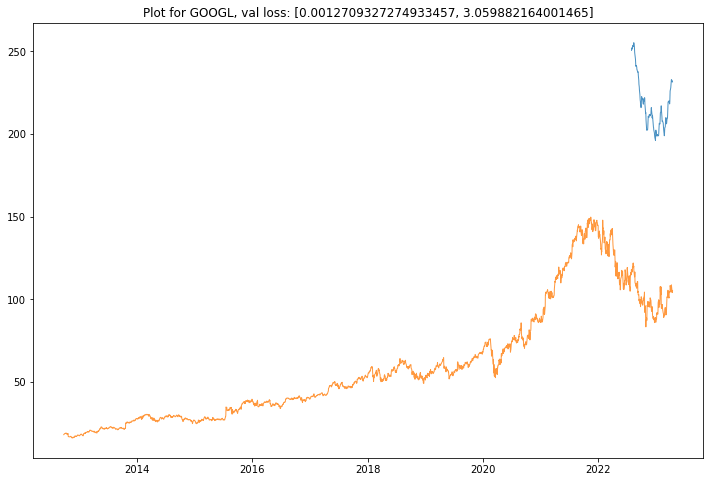

*****Training for GOOG
Epoch 1/100
114/114 [==============================] - 5s 28ms/step - loss: 0.0034 - mean_absolute_percentage_error: 37.5373 - val_loss: 0.0498 - val_mean_absolute_percentage_error: 23.8277
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 65.9679 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 13.7493
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 48.0224 - val_loss: 0.0521 - val_mean_absolute_percentage_error: 24.1802
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 14.2867 - val_loss: 0.0415 - val_mean_absolute_percentage_error: 21.5789
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 9.0030e-04 - mean_absolute_percentage_error: 15.7995 - val_loss: 0.0388 - val_mean_absolute_percentage_error: 20.8239
Epoch 6/100
114/114 [==

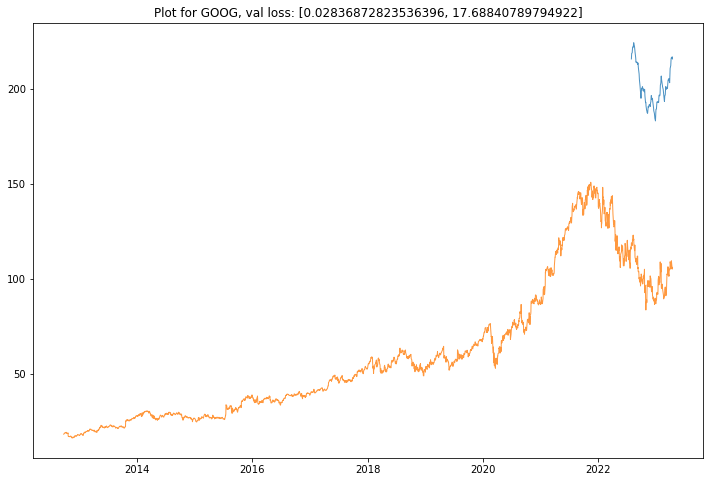

*****Training for TSLA
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0044 - mean_absolute_percentage_error: 299.7702 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 12.1171
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 351.6487 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 16.0346
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0057 - mean_absolute_percentage_error: 388.2271 - val_loss: 0.0122 - val_mean_absolute_percentage_error: 10.4559
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0026 - mean_absolute_percentage_error: 145.7144 - val_loss: 0.0075 - val_mean_absolute_percentage_error: 7.4184
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0023 - mean_absolute_percentage_error: 298.0731 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 10.3432
Epoch 6/100
114/114 [==

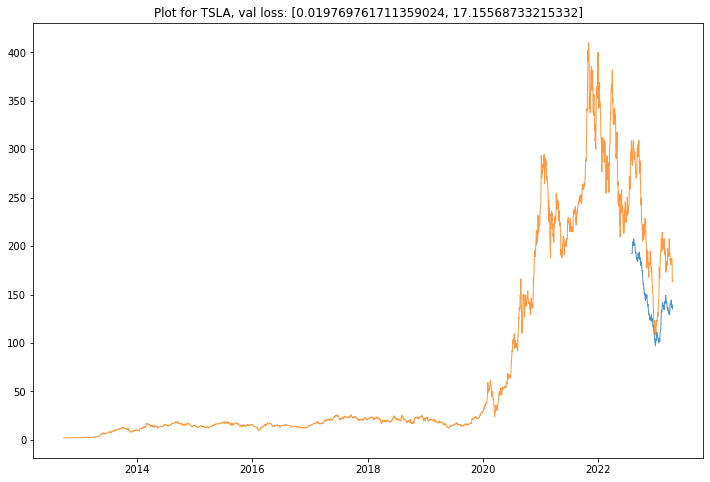

*****Training for META
Epoch 1/100
114/114 [==============================] - 6s 33ms/step - loss: 0.0076 - mean_absolute_percentage_error: 51.6189 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 18.1169
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0058 - mean_absolute_percentage_error: 56.6405 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 14.8460
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 61.7622 - val_loss: 0.0146 - val_mean_absolute_percentage_error: 15.0498
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0035 - mean_absolute_percentage_error: 28.0463 - val_loss: 0.0126 - val_mean_absolute_percentage_error: 13.8606
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0031 - mean_absolute_percentage_error: 37.7002 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 14.2194
Epoch 6/100
114/114 [======

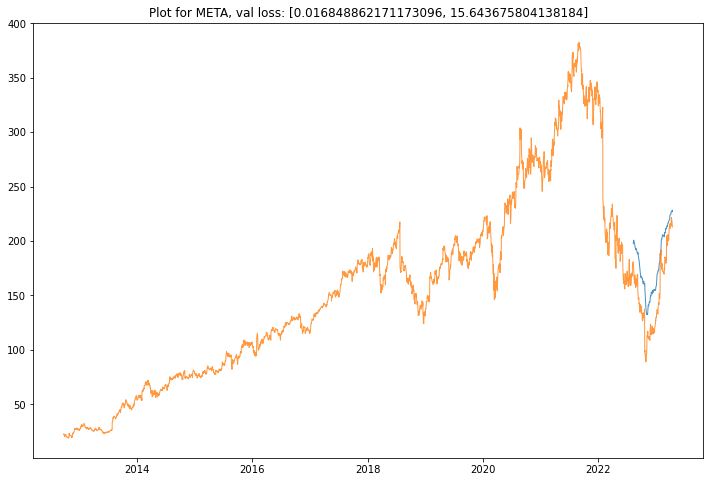

*****Training for UNH
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0058 - mean_absolute_percentage_error: 79.6811 - val_loss: 0.0384 - val_mean_absolute_percentage_error: 23.2762
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 140.9902 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 15.3912
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0049 - mean_absolute_percentage_error: 140.4954 - val_loss: 0.0121 - val_mean_absolute_percentage_error: 10.3110
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0039 - mean_absolute_percentage_error: 124.5289 - val_loss: 0.0220 - val_mean_absolute_percentage_error: 16.2385
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 59.2585 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 7.3532
Epoch 6/100
114/114 [=====

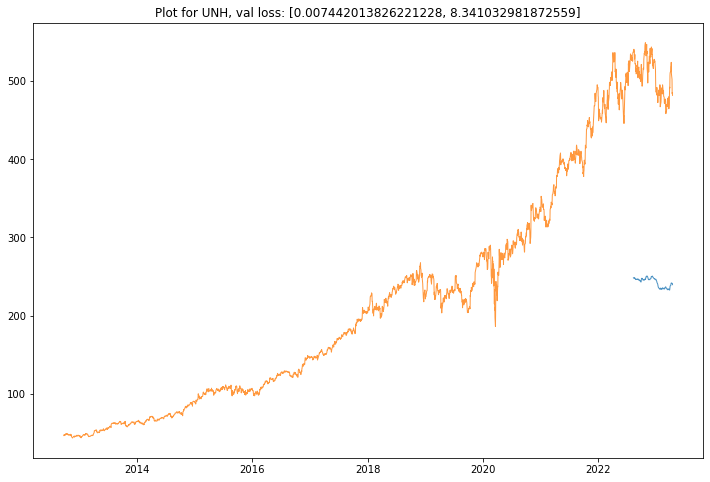

*****Training for XOM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0052 - mean_absolute_percentage_error: 22503.1992 - val_loss: 0.0305 - val_mean_absolute_percentage_error: 32.7486
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0047 - mean_absolute_percentage_error: 81555.0469 - val_loss: 0.1032 - val_mean_absolute_percentage_error: 77.6711
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0056 - mean_absolute_percentage_error: 41334.8477 - val_loss: 0.0795 - val_mean_absolute_percentage_error: 68.4004
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 39711.8906 - val_loss: 0.0517 - val_mean_absolute_percentage_error: 53.8867
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0026 - mean_absolute_percentage_error: 13579.5869 - val_loss: 0.0497 - val_mean_absolute_percentage_error: 53.0768
Epoch 6/100
1

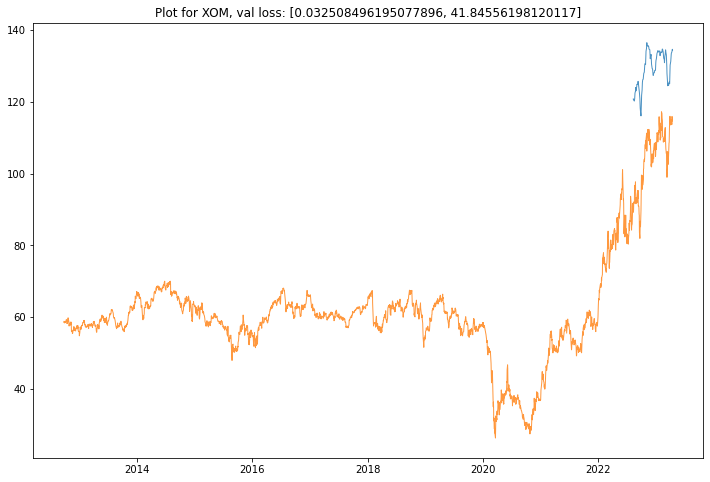

*****Training for JNJ
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0100 - mean_absolute_percentage_error: 26.3792 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 18.2752
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0118 - mean_absolute_percentage_error: 39.4896 - val_loss: 0.0119 - val_mean_absolute_percentage_error: 11.7426
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0066 - mean_absolute_percentage_error: 28.9484 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.6181
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 19.6387 - val_loss: 0.0040 - val_mean_absolute_percentage_error: 6.1538
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0038 - mean_absolute_percentage_error: 16.6770 - val_loss: 0.0066 - val_mean_absolute_percentage_error: 8.5912
Epoch 6/100
114/114 [==========

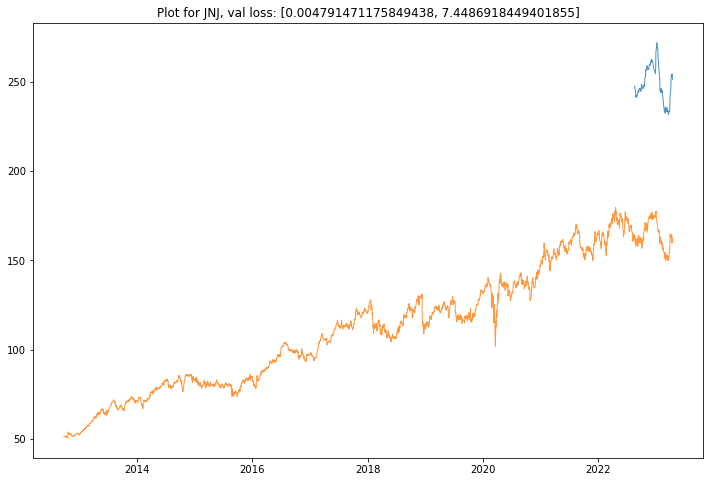

*****Training for JPM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0084 - mean_absolute_percentage_error: 30.7684 - val_loss: 0.0019 - val_mean_absolute_percentage_error: 4.0809
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0156 - mean_absolute_percentage_error: 58.7486 - val_loss: 0.0158 - val_mean_absolute_percentage_error: 12.7593
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0090 - mean_absolute_percentage_error: 49.5238 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 5.8025
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0038 - mean_absolute_percentage_error: 25.9786 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 4.0903
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 13.5027 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 4.1068
Epoch 6/100
114/114 [===========

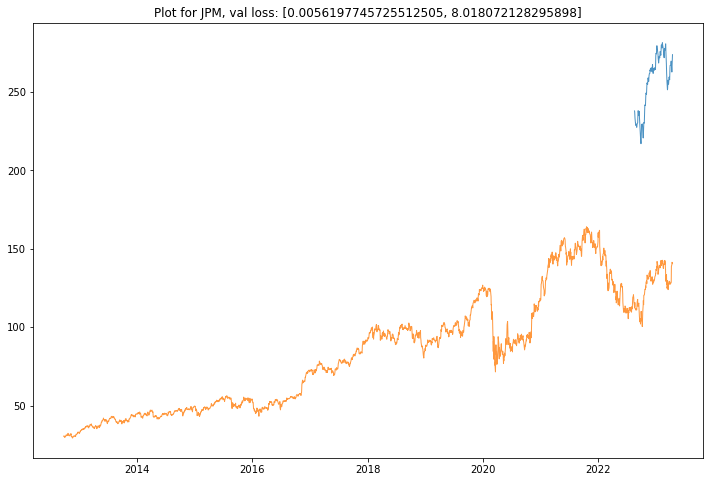

*****Training for V
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0041 - mean_absolute_percentage_error: 30.5047 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 5.8111
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0086 - mean_absolute_percentage_error: 64.4912 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 10.4940
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0057 - mean_absolute_percentage_error: 44.0034 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 10.1301
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 28.5338 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 4.7722
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0031 - mean_absolute_percentage_error: 28.3497 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.4116
Epoch 6/100
114/114 [============

114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 10.0327 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 12.6076
Epoch 45/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0021 - mean_absolute_percentage_error: 16.7303 - val_loss: 0.0085 - val_mean_absolute_percentage_error: 9.8912
Epoch 46/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 13.1141 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.4403
Val loss for V: [0.0013837374281138182, 3.440340280532837]


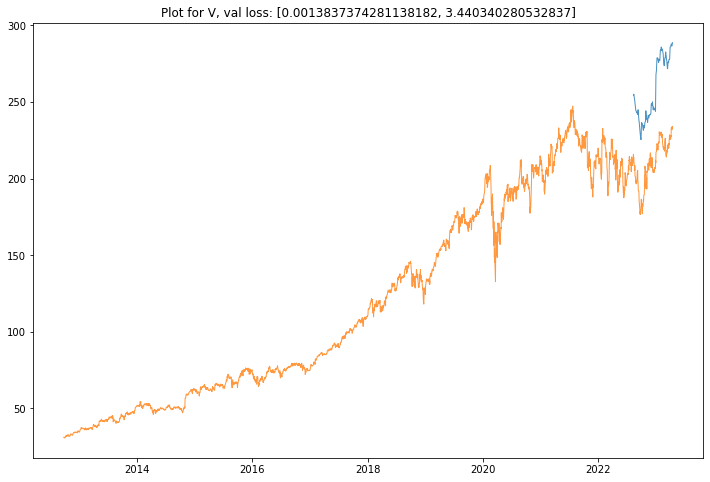

*****Training for LLY
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0042 - mean_absolute_percentage_error: 87.3239 - val_loss: 0.0449 - val_mean_absolute_percentage_error: 33.7388
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0039 - mean_absolute_percentage_error: 111.3295 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 25.6750
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 48.1837 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 26.1141
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 42.2035 - val_loss: 0.0297 - val_mean_absolute_percentage_error: 26.6629
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 9.4896e-04 - mean_absolute_percentage_error: 42.3721 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 26.4375
Epoch 6/100
114/114 [==

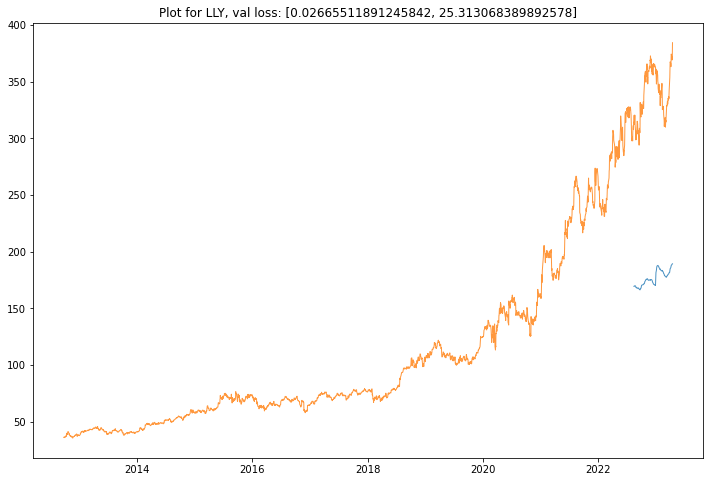

*****Training for PG
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0081 - mean_absolute_percentage_error: 37.7456 - val_loss: 0.0421 - val_mean_absolute_percentage_error: 22.1383
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0078 - mean_absolute_percentage_error: 38.2893 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 7.6060
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0107 - mean_absolute_percentage_error: 46.5491 - val_loss: 0.0124 - val_mean_absolute_percentage_error: 9.5895
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0066 - mean_absolute_percentage_error: 38.1145 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 7.7601
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 24.0258 - val_loss: 0.0082 - val_mean_absolute_percentage_error: 7.6821
Epoch 6/100
114/114 [============

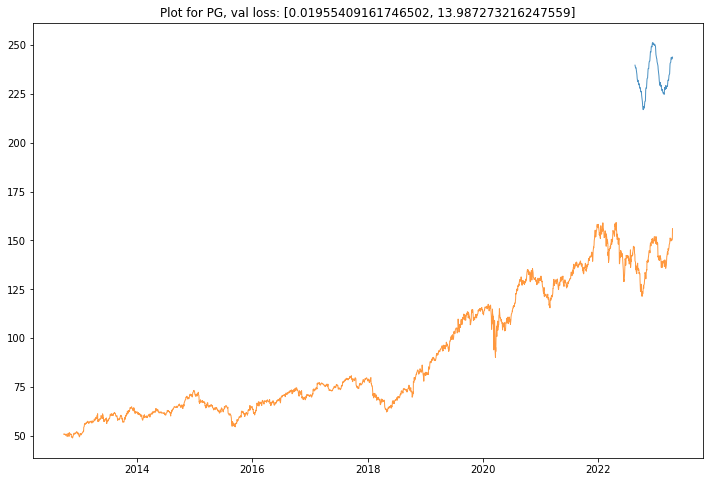

*****Training for AVGO
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0033 - mean_absolute_percentage_error: 113.7634 - val_loss: 0.0110 - val_mean_absolute_percentage_error: 9.2207
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 347.6653 - val_loss: 0.0074 - val_mean_absolute_percentage_error: 9.0581
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 266.7516 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 8.2958
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0013 - mean_absolute_percentage_error: 47.1010 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 8.4527
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0026 - mean_absolute_percentage_error: 85.8396 - val_loss: 0.0135 - val_mean_absolute_percentage_error: 11.5146
Epoch 6/100
114/114 [=======

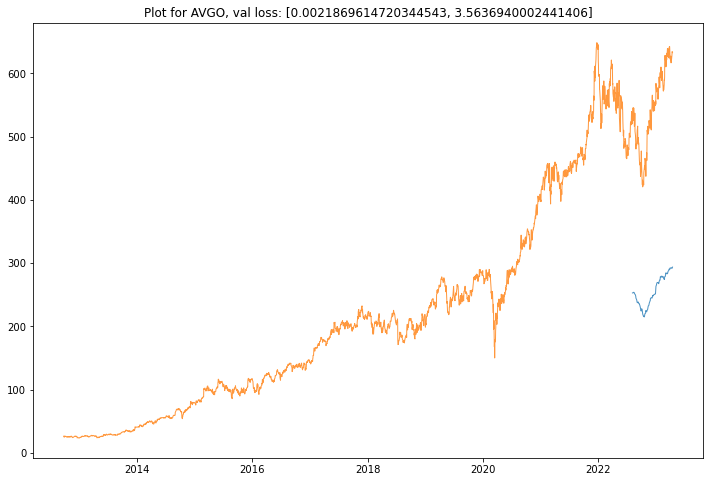

*****Training for MA
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0037 - mean_absolute_percentage_error: 31.5190 - val_loss: 0.0019 - val_mean_absolute_percentage_error: 4.1861
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0113 - mean_absolute_percentage_error: 98.4296 - val_loss: 0.0271 - val_mean_absolute_percentage_error: 17.9057
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0065 - mean_absolute_percentage_error: 59.0003 - val_loss: 0.0029 - val_mean_absolute_percentage_error: 5.0942
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0058 - mean_absolute_percentage_error: 59.4525 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 5.5830
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0039 - mean_absolute_percentage_error: 34.4804 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 3.8522
Epoch 6/100
114/114 [============

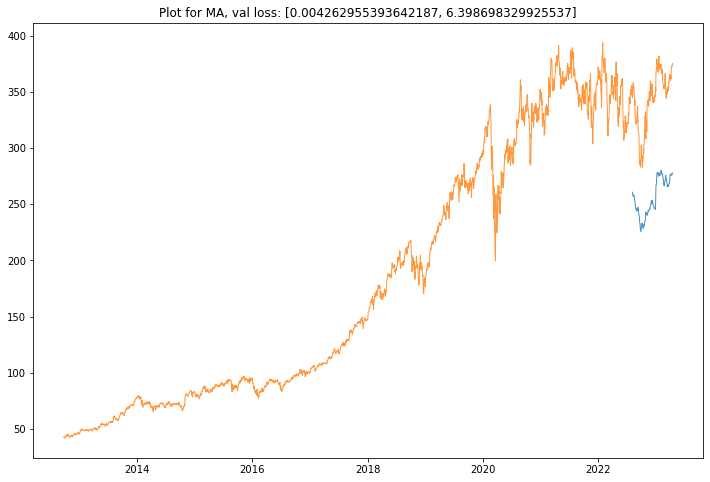

*****Training for HD
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0058 - mean_absolute_percentage_error: 44.6247 - val_loss: 0.0486 - val_mean_absolute_percentage_error: 24.5559
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0081 - mean_absolute_percentage_error: 82.2001 - val_loss: 0.0470 - val_mean_absolute_percentage_error: 23.5421
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0076 - mean_absolute_percentage_error: 80.7376 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 15.7741
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0074 - mean_absolute_percentage_error: 83.3714 - val_loss: 0.0293 - val_mean_absolute_percentage_error: 17.6988
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 64.8046 - val_loss: 0.0443 - val_mean_absolute_percentage_error: 23.0057
Epoch 6/100
114/114 [========

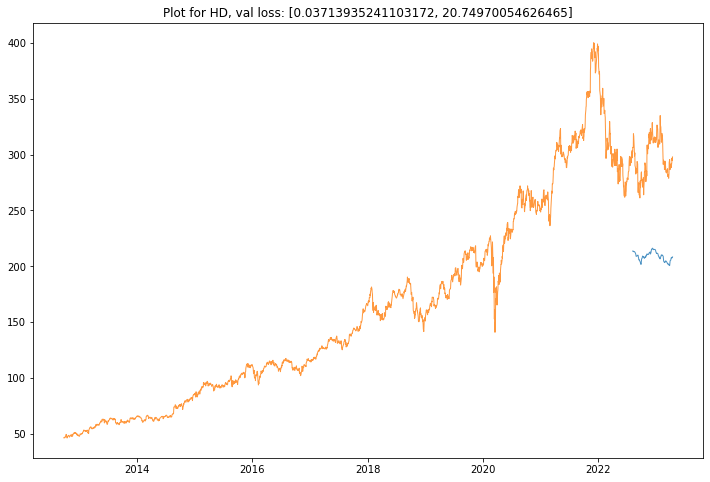

*****Training for CVX
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0090 - mean_absolute_percentage_error: 96086.0625 - val_loss: 0.0634 - val_mean_absolute_percentage_error: 40.1520
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0040 - mean_absolute_percentage_error: 96137.7266 - val_loss: 0.0755 - val_mean_absolute_percentage_error: 46.7216
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0031 - mean_absolute_percentage_error: 66825.9922 - val_loss: 0.0739 - val_mean_absolute_percentage_error: 45.6555
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0028 - mean_absolute_percentage_error: 82038.7734 - val_loss: 0.0676 - val_mean_absolute_percentage_error: 43.6277
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0023 - mean_absolute_percentage_error: 56166.0469 - val_loss: 0.0556 - val_mean_absolute_percentage_error: 38.0651
Epoch 6/100
1

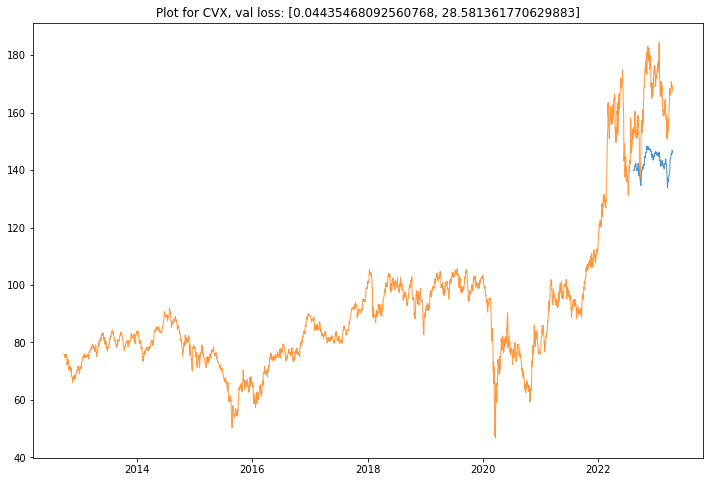

*****Training for MRK
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0073 - mean_absolute_percentage_error: 48.4868 - val_loss: 0.0136 - val_mean_absolute_percentage_error: 19.2991
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0055 - mean_absolute_percentage_error: 80.1123 - val_loss: 0.0054 - val_mean_absolute_percentage_error: 10.8351
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0037 - mean_absolute_percentage_error: 58.9754 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 7.6413
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0023 - mean_absolute_percentage_error: 36.6987 - val_loss: 0.0046 - val_mean_absolute_percentage_error: 10.0517
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0012 - mean_absolute_percentage_error: 15.4212 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 6.7012
Epoch 6/100
114/114 [=========

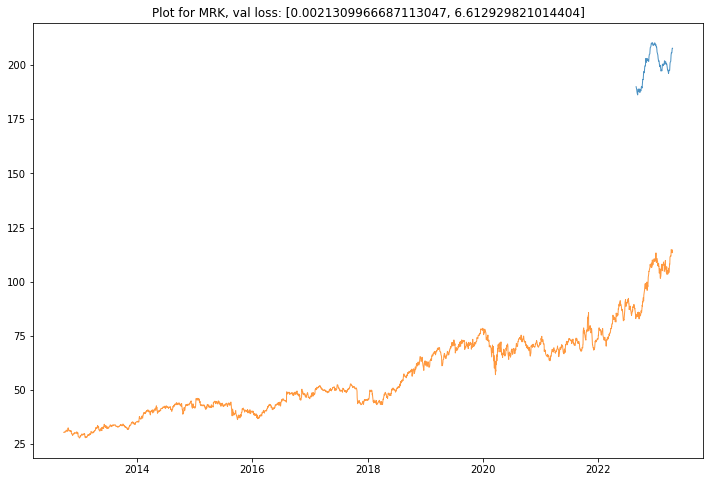

*****Training for PEP
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0046 - mean_absolute_percentage_error: 29.3172 - val_loss: 0.0720 - val_mean_absolute_percentage_error: 33.1937
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0057 - mean_absolute_percentage_error: 37.8529 - val_loss: 0.0292 - val_mean_absolute_percentage_error: 20.1717
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0056 - mean_absolute_percentage_error: 37.6403 - val_loss: 0.0393 - val_mean_absolute_percentage_error: 23.7777
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0058 - mean_absolute_percentage_error: 38.3265 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 13.8169
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0060 - mean_absolute_percentage_error: 38.8741 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 16.9123
Epoch 6/100
114/114 [=======

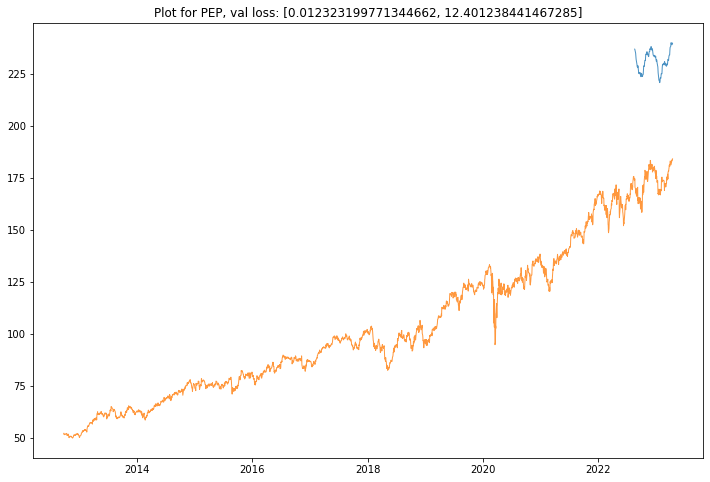

*****Training for KO
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0097 - mean_absolute_percentage_error: 45.7653 - val_loss: 0.0072 - val_mean_absolute_percentage_error: 7.7289
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0052 - mean_absolute_percentage_error: 34.4606 - val_loss: 0.0064 - val_mean_absolute_percentage_error: 7.3805
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0035 - mean_absolute_percentage_error: 27.5049 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 4.6155
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0027 - mean_absolute_percentage_error: 21.5649 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 4.4079
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0019 - mean_absolute_percentage_error: 16.1345 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 14.7234
Epoch 6/100
114/114 [============

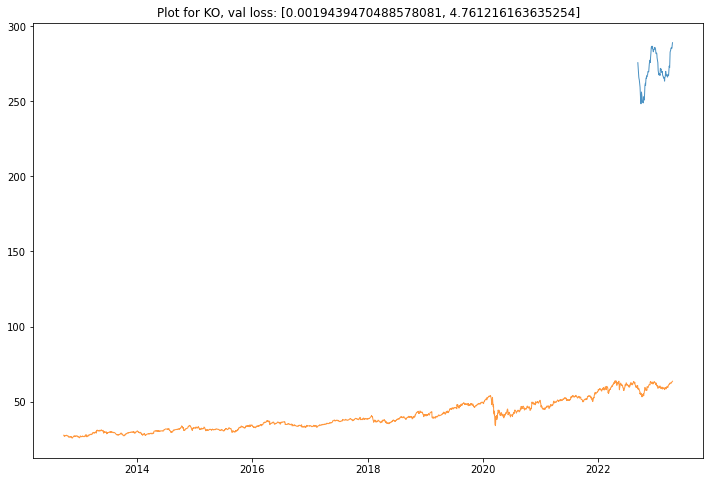

*****Training for COST
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0024 - mean_absolute_percentage_error: 34.8769 - val_loss: 0.0787 - val_mean_absolute_percentage_error: 33.1541
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 69.4518 - val_loss: 0.0649 - val_mean_absolute_percentage_error: 29.7876
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 75.5005 - val_loss: 0.1087 - val_mean_absolute_percentage_error: 39.2421
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 72.3919 - val_loss: 0.0588 - val_mean_absolute_percentage_error: 27.8363
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 76.8303 - val_loss: 0.0836 - val_mean_absolute_percentage_error: 33.9145
Epoch 6/100
114/114 [======

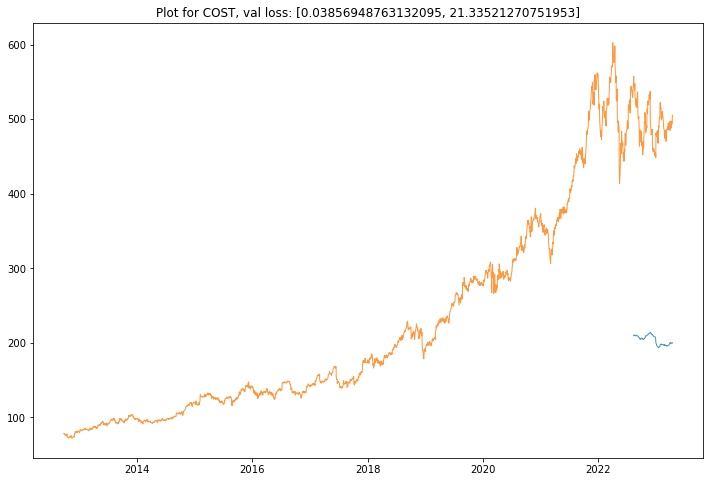

*****Training for PFE
Epoch 1/100
114/114 [==============================] - 6s 32ms/step - loss: 0.0047 - mean_absolute_percentage_error: 28.8866 - val_loss: 0.0501 - val_mean_absolute_percentage_error: 26.0751
Epoch 2/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0051 - mean_absolute_percentage_error: 34.1357 - val_loss: 0.0555 - val_mean_absolute_percentage_error: 27.6580
Epoch 3/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0032 - mean_absolute_percentage_error: 26.2990 - val_loss: 0.0532 - val_mean_absolute_percentage_error: 26.8439
Epoch 4/100
114/114 [==============================] - 3s 27ms/step - loss: 0.0032 - mean_absolute_percentage_error: 26.7988 - val_loss: 0.0597 - val_mean_absolute_percentage_error: 28.7679
Epoch 5/100
114/114 [==============================] - 3s 26ms/step - loss: 0.0028 - mean_absolute_percentage_error: 24.8123 - val_loss: 0.0546 - val_mean_absolute_percentage_error: 27.3789
Epoch 6/100
114/114 [=======

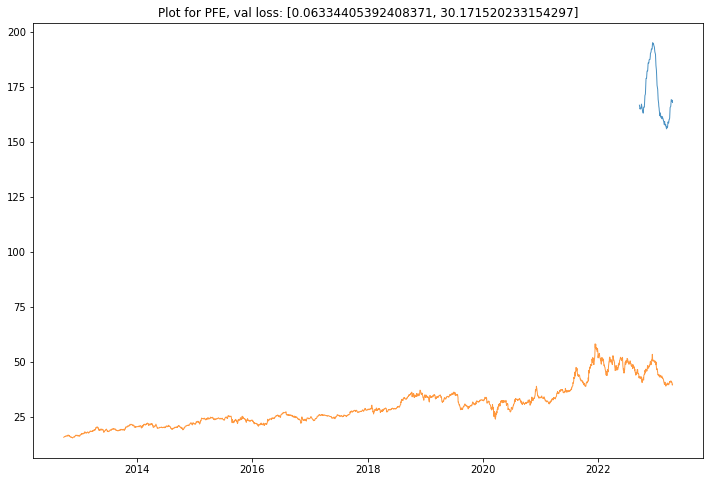

*****Training for WMT
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0139 - mean_absolute_percentage_error: 36209.4414 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 5.5834
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0157 - mean_absolute_percentage_error: 89073.0078 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 3.6610
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0118 - mean_absolute_percentage_error: 73224.6172 - val_loss: 0.0018 - val_mean_absolute_percentage_error: 4.0303
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0116 - mean_absolute_percentage_error: 45498.1406 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 3.8975
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0100 - mean_absolute_percentage_error: 52829.2070 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 6.1743
Epoch 6/100
114/11

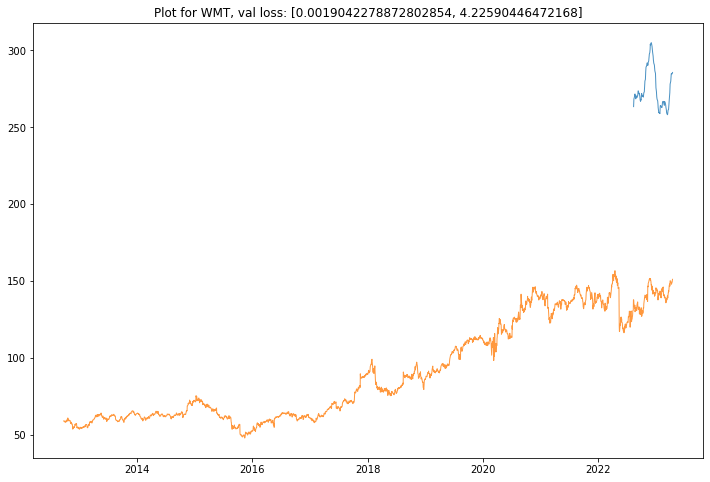

*****Training for MCD
Epoch 1/100
114/114 [==============================] - 6s 29ms/step - loss: 0.0044 - mean_absolute_percentage_error: 32.0009 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 16.9483
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0074 - mean_absolute_percentage_error: 62.2671 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 14.9524
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0073 - mean_absolute_percentage_error: 55.4278 - val_loss: 0.0099 - val_mean_absolute_percentage_error: 11.3792
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0085 - mean_absolute_percentage_error: 58.5980 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 7.3624
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0072 - mean_absolute_percentage_error: 55.0634 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 8.4040
Epoch 6/100
114/114 [=========

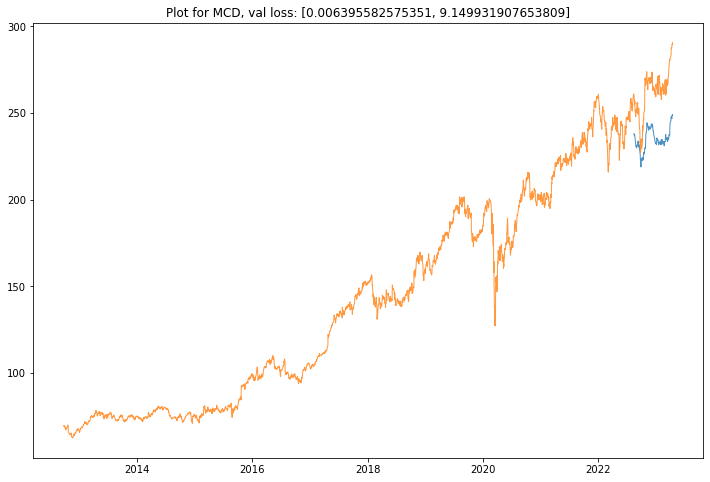

*****Training for BAC
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0081 - mean_absolute_percentage_error: 26.8097 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 13.9737
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0134 - mean_absolute_percentage_error: 48.2643 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 13.8319
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0054 - mean_absolute_percentage_error: 32.9022 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 4.8681
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0030 - mean_absolute_percentage_error: 18.2176 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 4.9081
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0025 - mean_absolute_percentage_error: 15.5496 - val_loss: 0.0027 - val_mean_absolute_percentage_error: 5.1279
Epoch 6/100
114/114 [==========

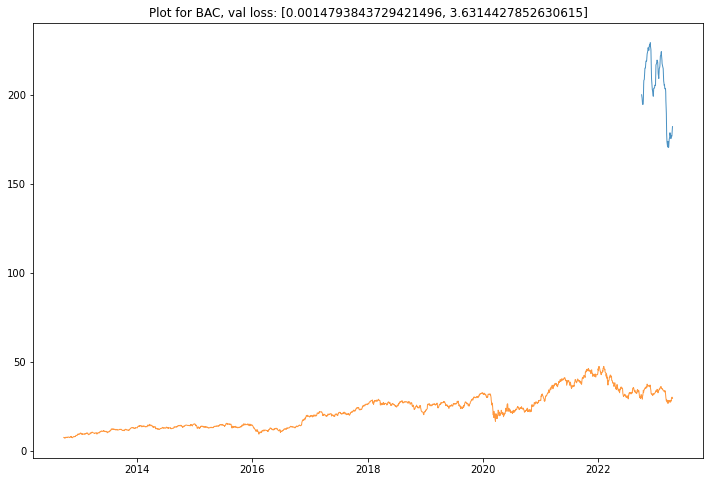

*****Training for CRM
Epoch 1/100
114/114 [==============================] - 5s 29ms/step - loss: 0.0077 - mean_absolute_percentage_error: 58.3016 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 15.9365
Epoch 2/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0079 - mean_absolute_percentage_error: 70.4645 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 15.1938
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0069 - mean_absolute_percentage_error: 75.1370 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 12.9321
Epoch 4/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0087 - mean_absolute_percentage_error: 79.2984 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 10.9319
Epoch 5/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0092 - mean_absolute_percentage_error: 81.6695 - val_loss: 0.0101 - val_mean_absolute_percentage_error: 11.3731
Epoch 6/100
114/114 [=======

Epoch 44/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 15.1844 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 10.1363
Epoch 45/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 16.7456 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 4.0883
Epoch 46/100
114/114 [==============================] - 3s 25ms/step - loss: 8.7547e-04 - mean_absolute_percentage_error: 17.0434 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 8.3906
Epoch 47/100
114/114 [==============================] - 3s 25ms/step - loss: 7.2283e-04 - mean_absolute_percentage_error: 13.9565 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 8.0149
Val loss for CRM: [0.005681175272911787, 8.014908790588379]


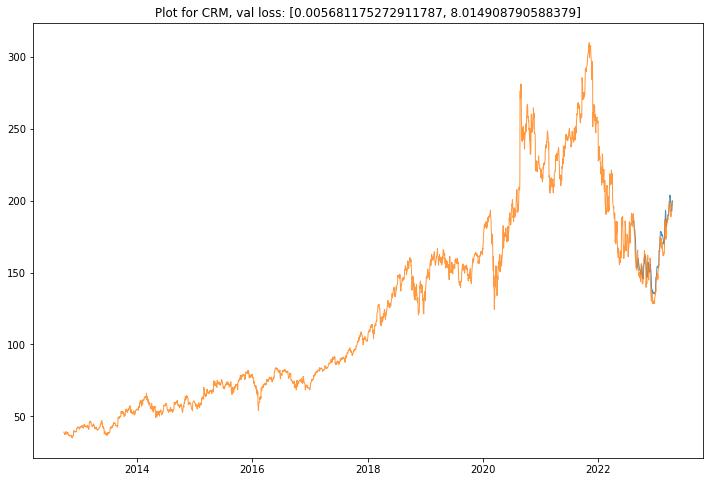

In [106]:
EPOCHS = 100
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
    
    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [tensorboard,early_stopping]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    model.fit_generator(
        train_generator, 
        validation_data=valid_generator, 
        shuffle=False,
        epochs=EPOCHS, 
        verbose=1, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    
    
    # --Plots while training
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    
    %matplotlib inline
    plt.figure(figsize=(12, 8))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")

In [331]:
#model.history.history()
predicted_ticker

CRM   Adj Close
Date                              
2022-08-16  235.024017  189.589996
2022-08-17  236.596176  187.960007
2022-08-18  236.697205  187.929993
2022-08-19  235.490051  183.770004
2022-08-22  232.001923  176.979996
...                ...         ...
2023-04-17  240.469009  197.080002
2023-04-18  242.177414  198.500000
2023-04-19  244.647690  198.919998
2023-04-20  246.115555  197.509995
2023-04-21  245.995148  199.029999

[172 rows x 2 columns]

In [110]:
len(stocks_data)

28

# Generating Final Data Frame for the Predicted Data
* We will now generate the predicted stocks distribution using the best models fit above 

Val loss for AAPL: 0.011210400611162186


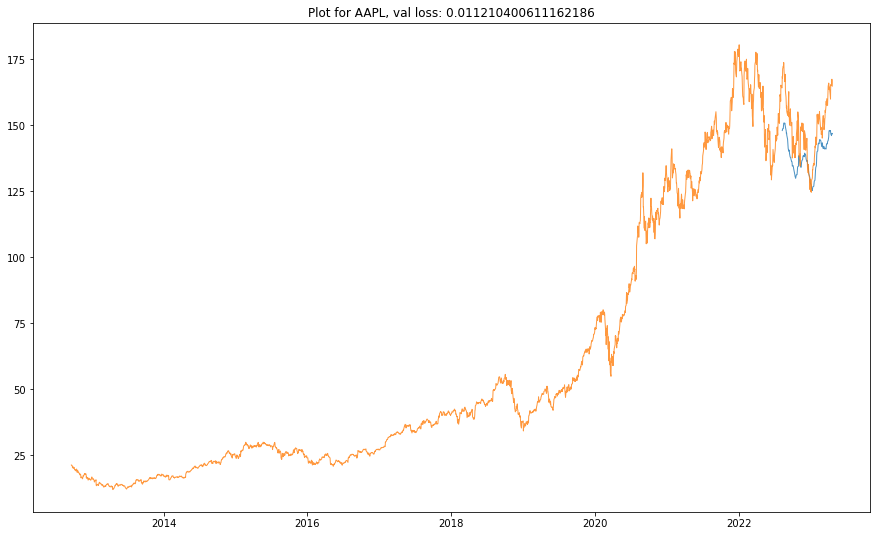

--------------------------
Final Train Loss: 0.0008
Final Test Loss: 0.0052
--------------------------
Final Train MAPE: 372.60101318359375
Final Test MAPE: 8.764100074768066
Val loss for MSFT: 0.0045214309357106686


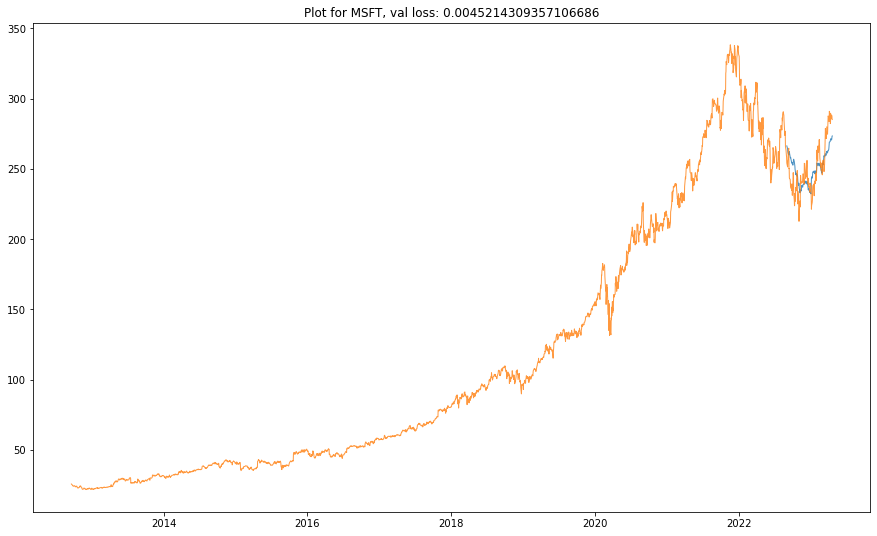

--------------------------
Final Train Loss: 0.0014
Final Test Loss: 0.0017
--------------------------
Final Train MAPE: 347.4216003417969
Final Test MAPE: 6.71150016784668
Val loss for AMZN: 0.0034685335122048855


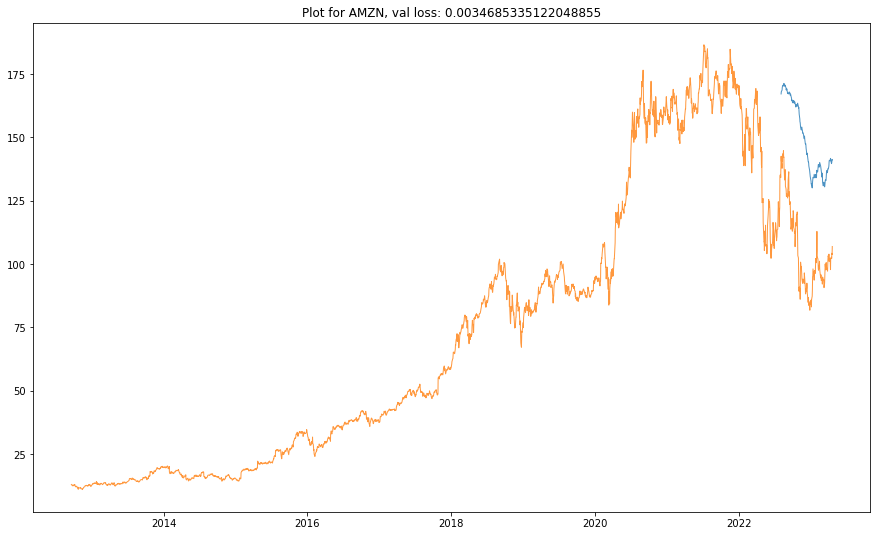

--------------------------
Final Train Loss: 0.01
Final Test Loss: 0.0661
--------------------------
Final Train MAPE: 362.2322998046875
Final Test MAPE: 45.08610153198242
Val loss for NVDA: 0.08941540867090225


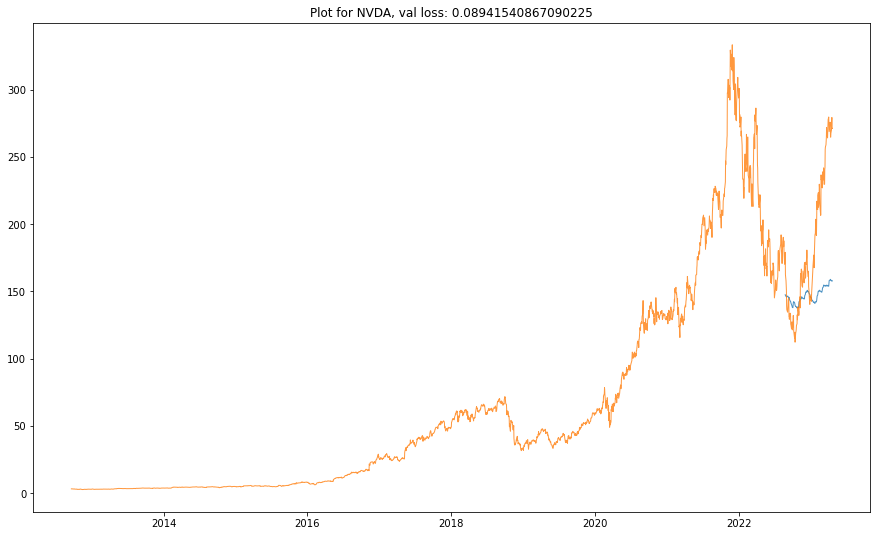

--------------------------
Final Train Loss: 0.001
Final Test Loss: 0.0305
--------------------------
Final Train MAPE: 1426.9942626953125
Final Test MAPE: 21.671600341796875
Val loss for GOOGL: 0.0012709327274933457


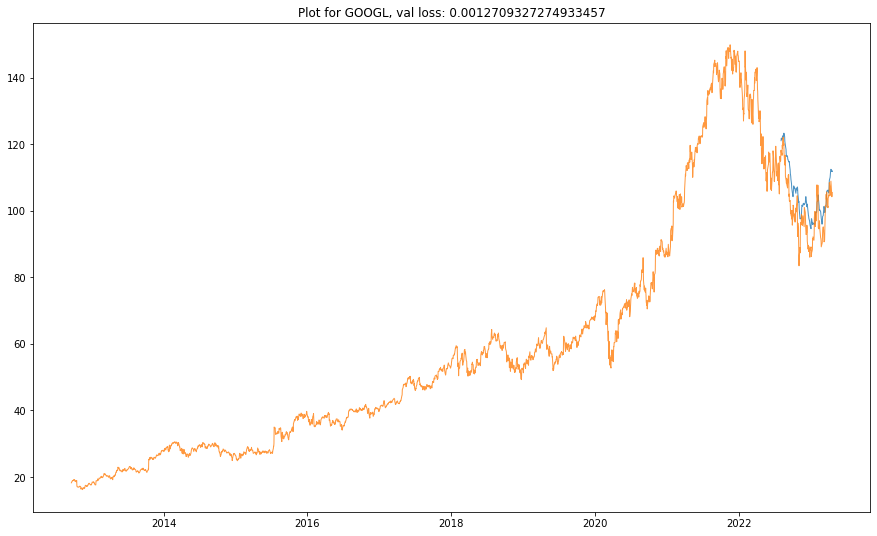

--------------------------
Final Train Loss: 0.0004
Final Test Loss: 0.0028
--------------------------
Final Train MAPE: 170.0063934326172
Final Test MAPE: 10.489399909973145
Val loss for GOOG: 0.02836872823536396


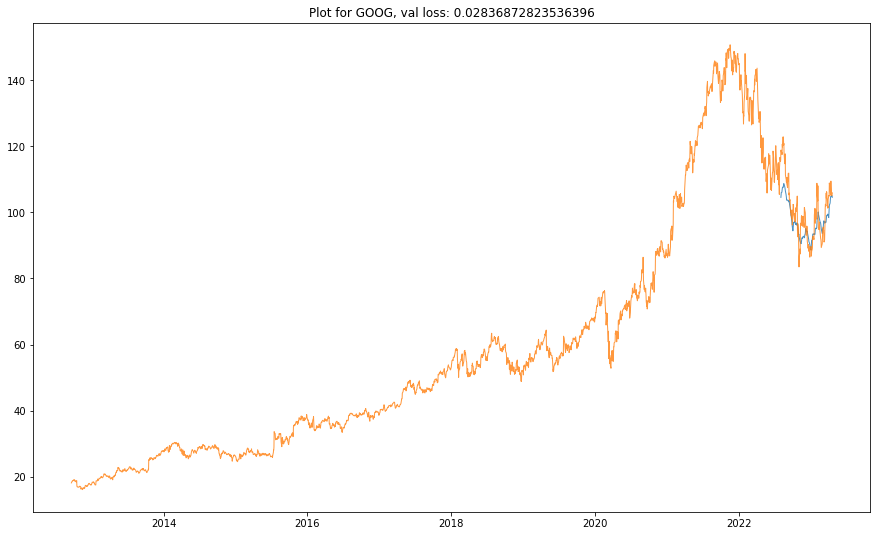

--------------------------
Final Train Loss: 0.0012
Final Test Loss: 0.0017
--------------------------
Final Train MAPE: 153.9051971435547
Final Test MAPE: 7.901199817657471
Val loss for TSLA: 0.019769761711359024


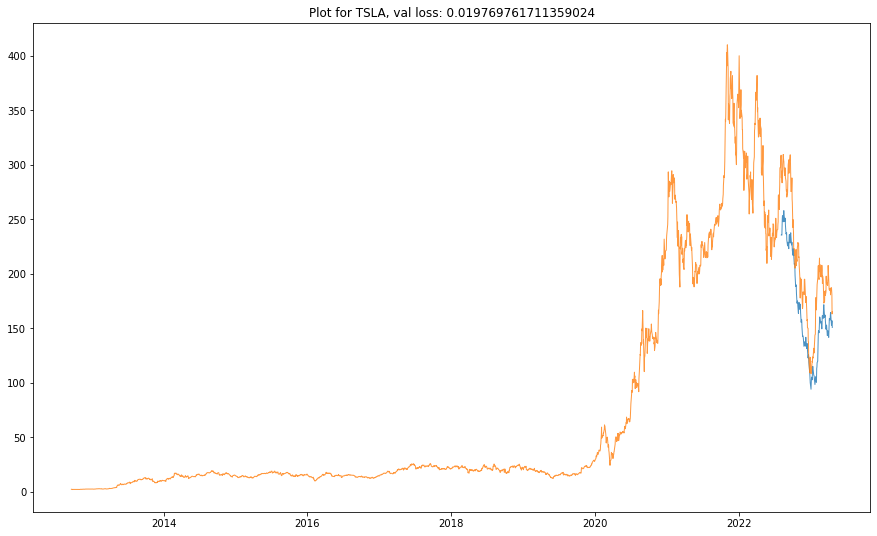

--------------------------
Final Train Loss: 0.0174
Final Test Loss: 0.0107
--------------------------
Final Train MAPE: 1042.424560546875
Final Test MAPE: 30.752500534057617
Val loss for META: 0.016848862171173096


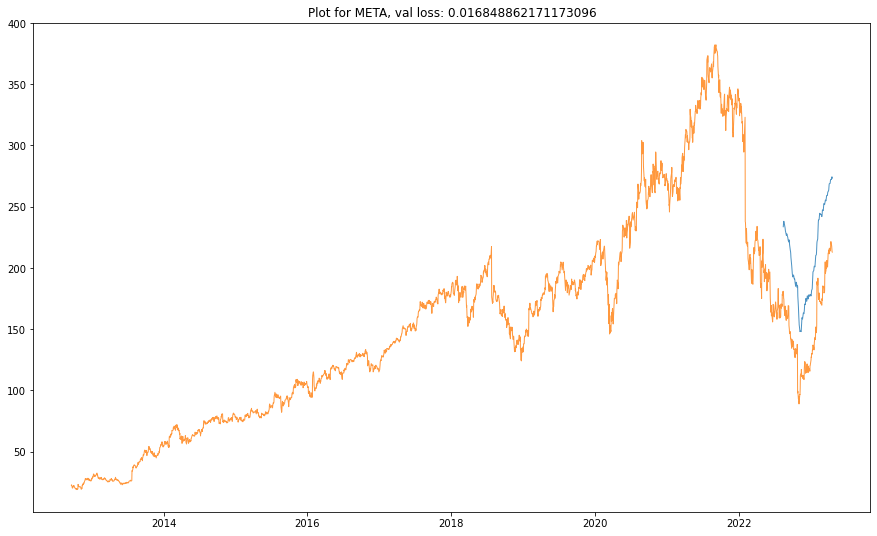

--------------------------
Final Train Loss: 0.0136
Final Test Loss: 0.027
--------------------------
Final Train MAPE: 128.24159240722656
Final Test MAPE: 49.451698303222656
Val loss for UNH: 0.007442013826221228


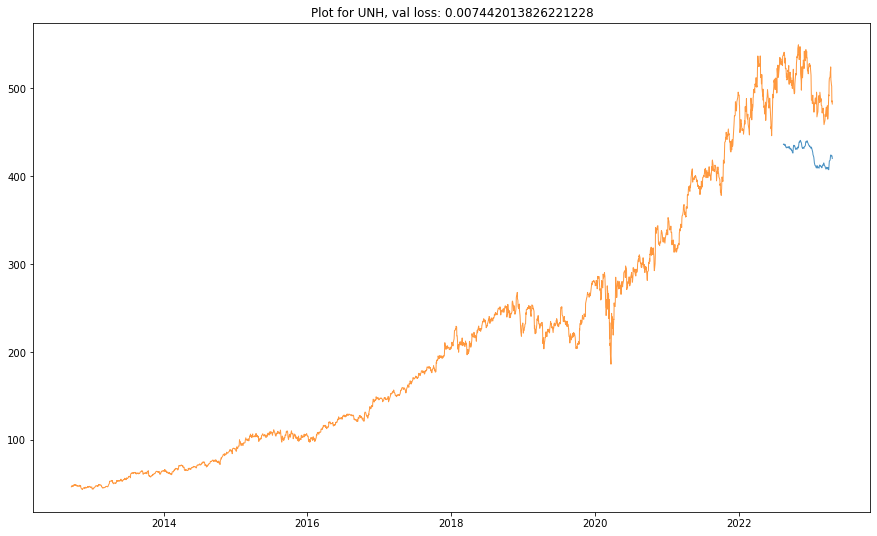

--------------------------
Final Train Loss: 0.0009
Final Test Loss: 0.0258
--------------------------
Final Train MAPE: 250.04359436035156
Final Test MAPE: 15.572999954223633
Val loss for XOM: 0.032508496195077896


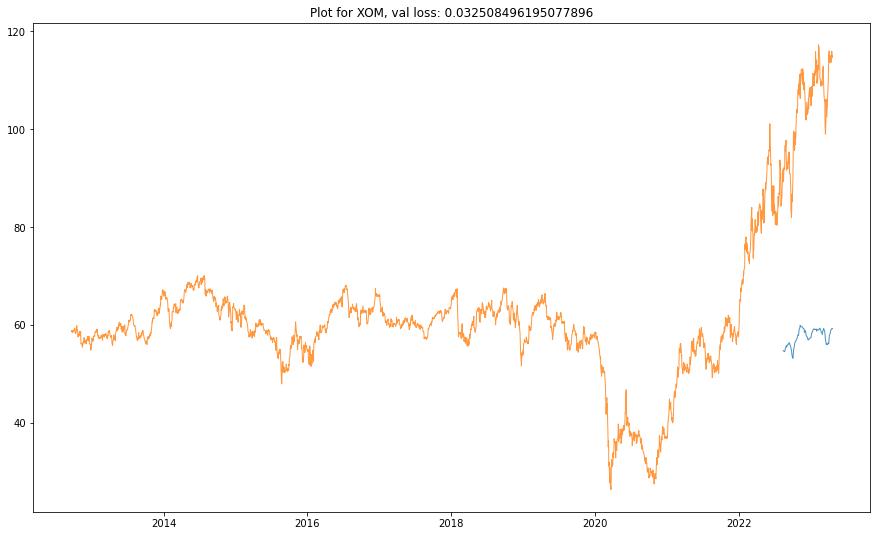

--------------------------
Final Train Loss: 0.0036
Final Test Loss: 0.2745
--------------------------
Final Train MAPE: 13.518099784851074
Final Test MAPE: 44.65439987182617
Val loss for JNJ: 0.004791471175849438


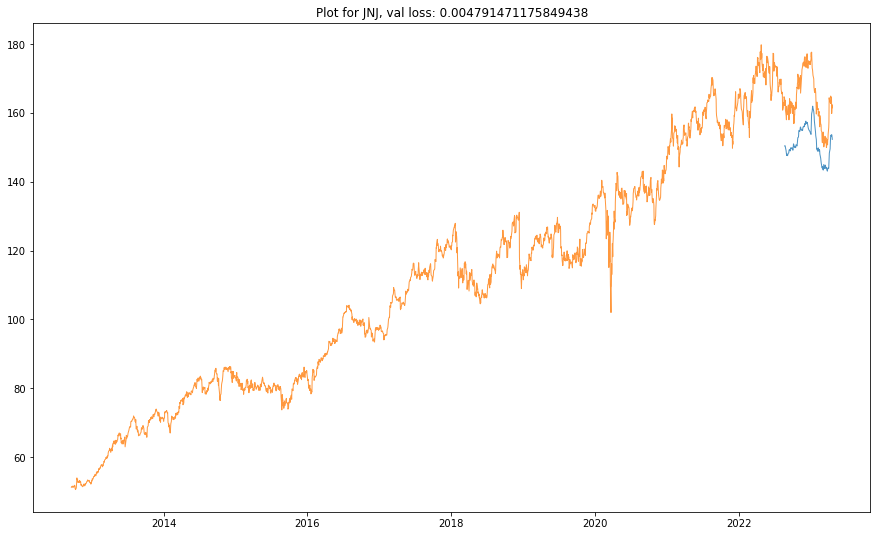

--------------------------
Final Train Loss: 0.004
Final Test Loss: 0.0105
--------------------------
Final Train MAPE: 57.12879943847656
Final Test MAPE: 7.855100154876709
Val loss for JPM: 0.0056197745725512505


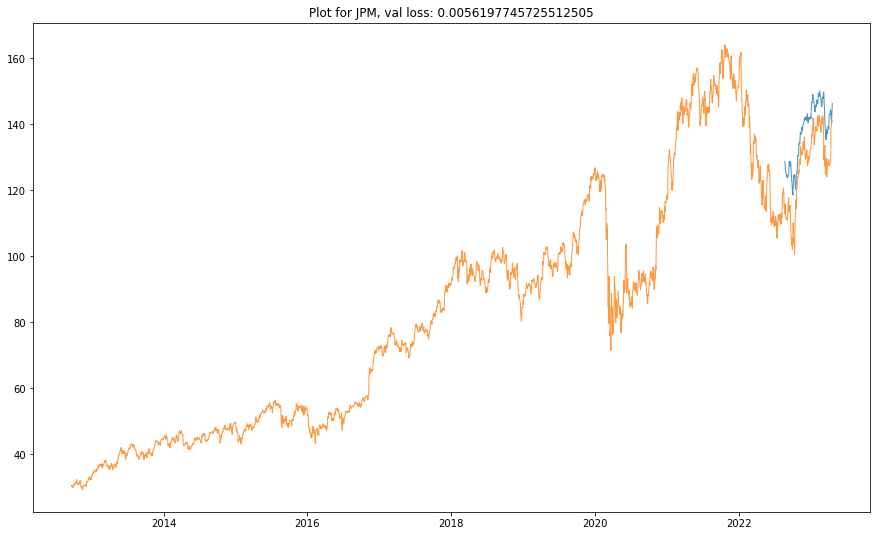

--------------------------
Final Train Loss: 0.0019
Final Test Loss: 0.0069
--------------------------
Final Train MAPE: 118.40290069580078
Final Test MAPE: 11.882100105285645
Val loss for V: 0.0013837374281138182


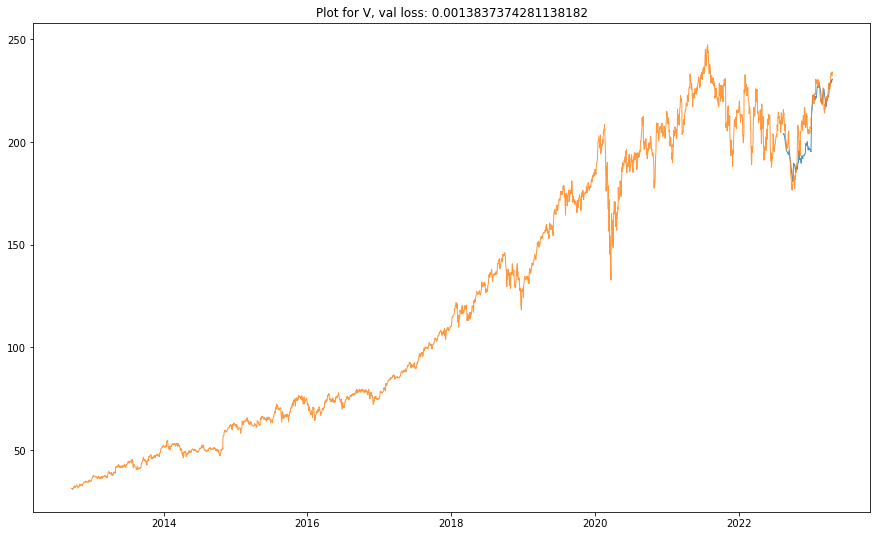

--------------------------
Final Train Loss: 0.0009
Final Test Loss: 0.0013
--------------------------
Final Train MAPE: 156.10679626464844
Final Test MAPE: 8.773799896240234
Val loss for LLY: 0.02665511891245842


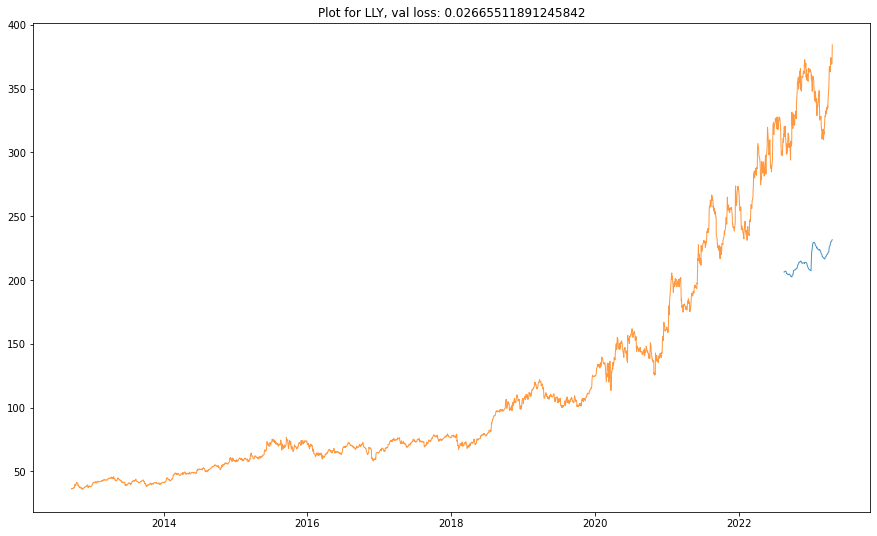

--------------------------
Final Train Loss: 0.0009
Final Test Loss: 0.1308
--------------------------
Final Train MAPE: 204.03359985351562
Final Test MAPE: 36.3911018371582
Val loss for PG: 0.01955409161746502


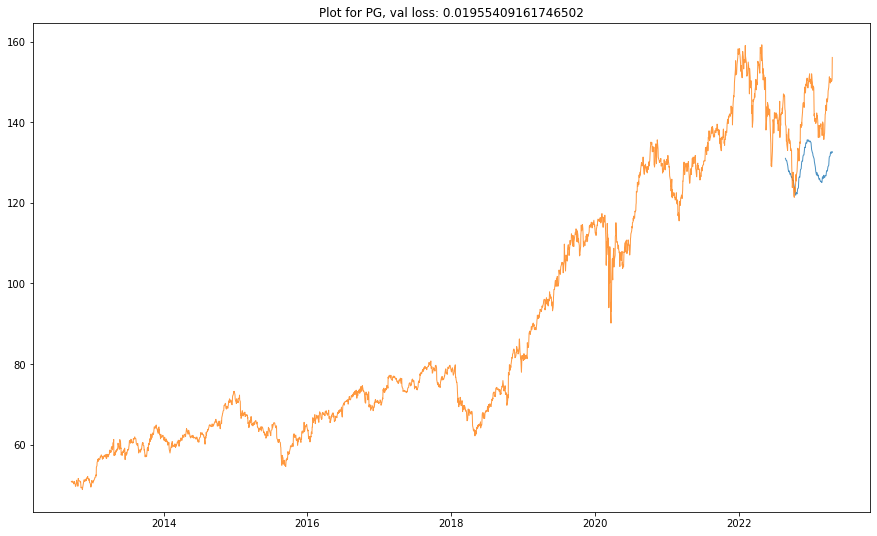

--------------------------
Final Train Loss: 0.0141
Final Test Loss: 0.0128
--------------------------
Final Train MAPE: 72.4197006225586
Final Test MAPE: 8.601799964904785
Val loss for AVGO: 0.0021869614720344543


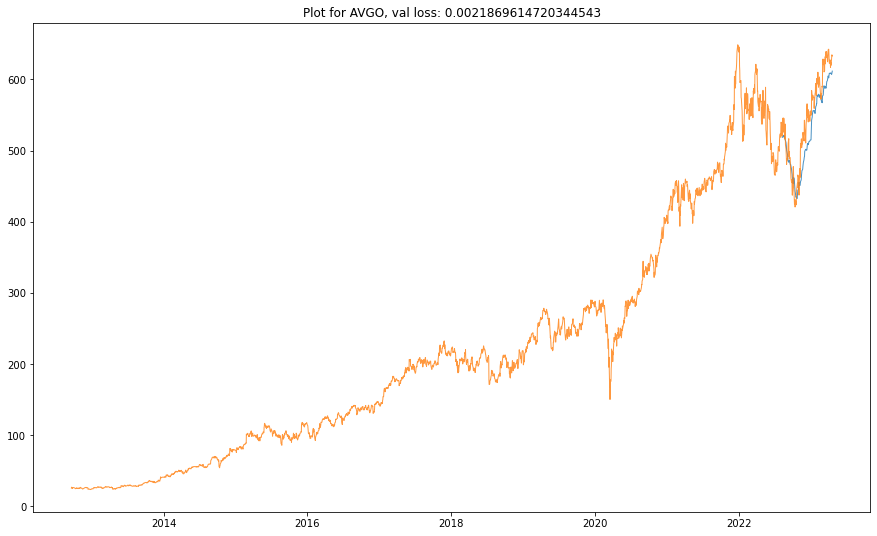

--------------------------
Final Train Loss: 0.0003
Final Test Loss: 0.0019
--------------------------
Final Train MAPE: 452.7538146972656
Final Test MAPE: 12.987500190734863
Val loss for MA: 0.004262955393642187


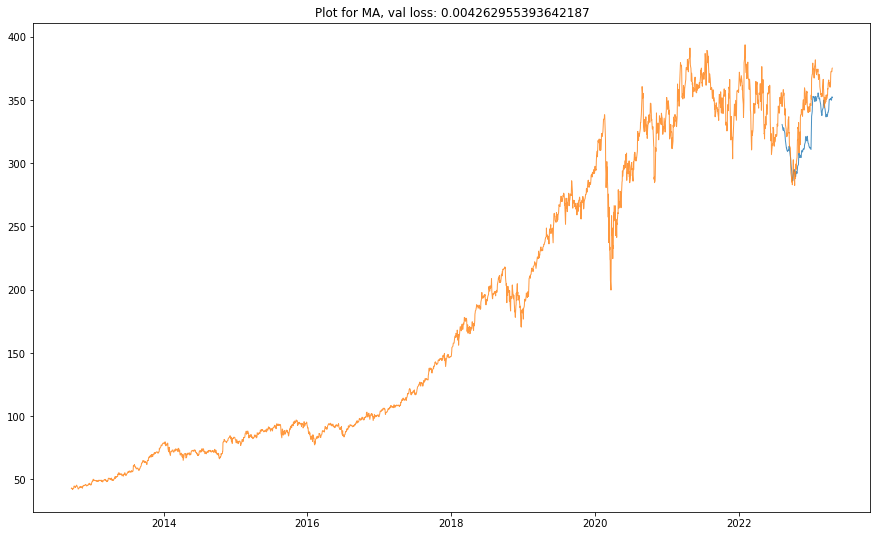

--------------------------
Final Train Loss: 0.001
Final Test Loss: 0.0037
--------------------------
Final Train MAPE: 195.12710571289062
Final Test MAPE: 9.044599533081055
Val loss for HD: 0.03713935241103172


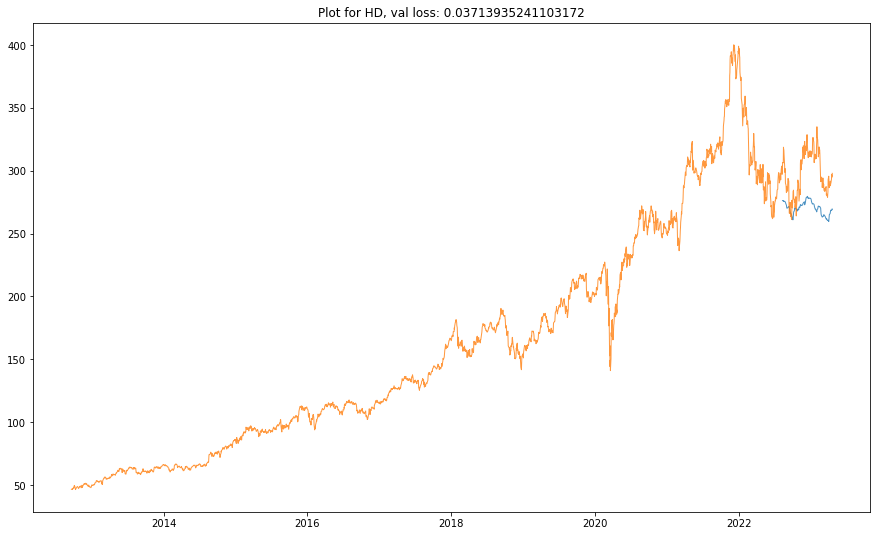

--------------------------
Final Train Loss: 0.0129
Final Test Loss: 0.0077
--------------------------
Final Train MAPE: 144.43919372558594
Final Test MAPE: 9.105199813842773
Val loss for CVX: 0.04435468092560768


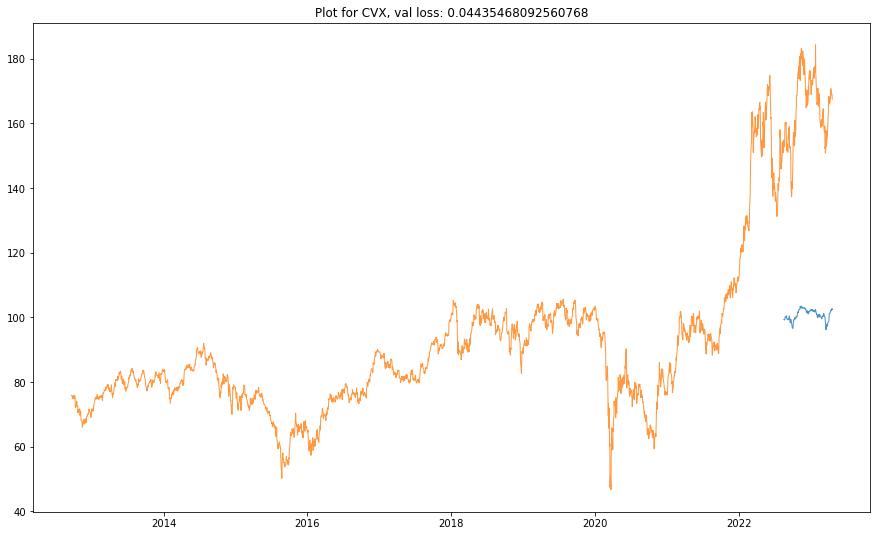

--------------------------
Final Train Loss: 0.0047
Final Test Loss: 0.2227
--------------------------
Final Train MAPE: 24.12070083618164
Final Test MAPE: 38.72529983520508
Val loss for MRK: 0.0021309966687113047


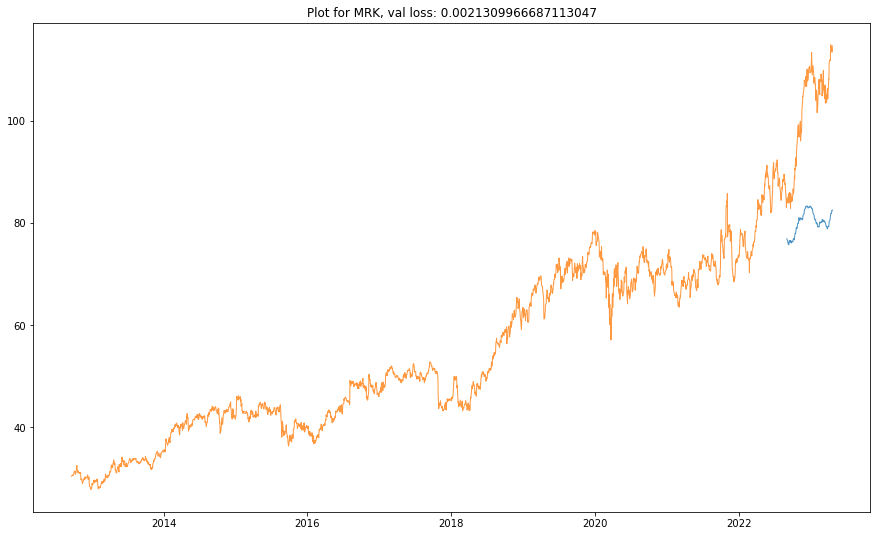

--------------------------
Final Train Loss: 0.0042
Final Test Loss: 0.0704
--------------------------
Final Train MAPE: 68.21900177001953
Final Test MAPE: 20.765600204467773
Val loss for PEP: 0.012323199771344662


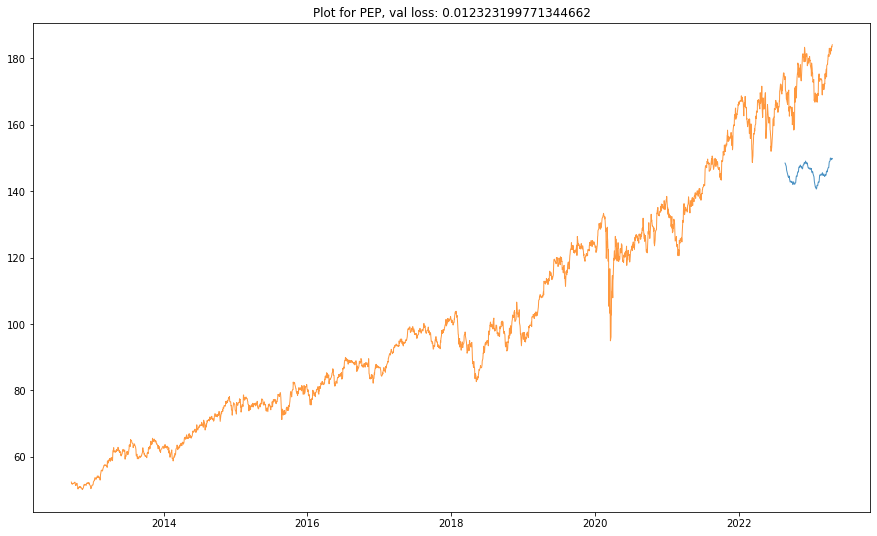

--------------------------
Final Train Loss: 0.0047
Final Test Loss: 0.0448
--------------------------
Final Train MAPE: 68.49259948730469
Final Test MAPE: 16.036800384521484
Val loss for KO: 0.0019439470488578081


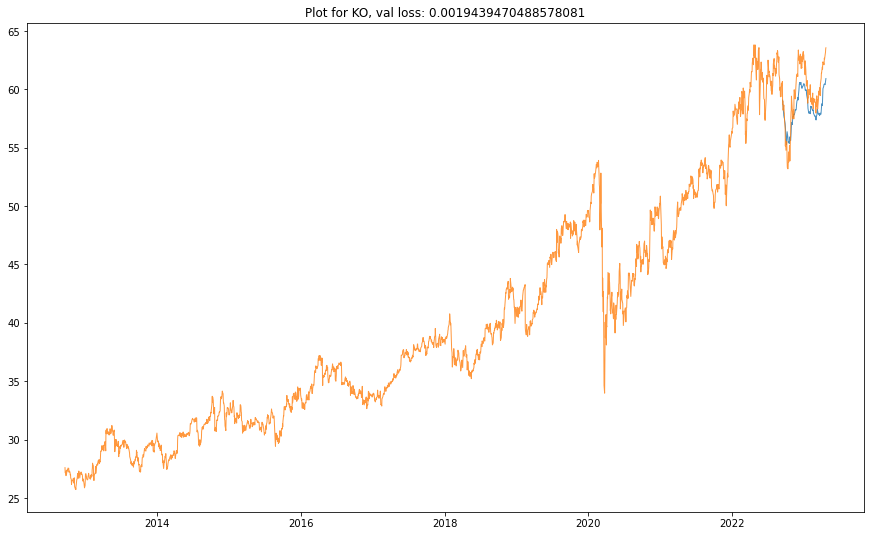

--------------------------
Final Train Loss: 0.0079
Final Test Loss: 0.0022
--------------------------
Final Train MAPE: 62.372501373291016
Final Test MAPE: 4.365099906921387
Val loss for COST: 0.03856948763132095


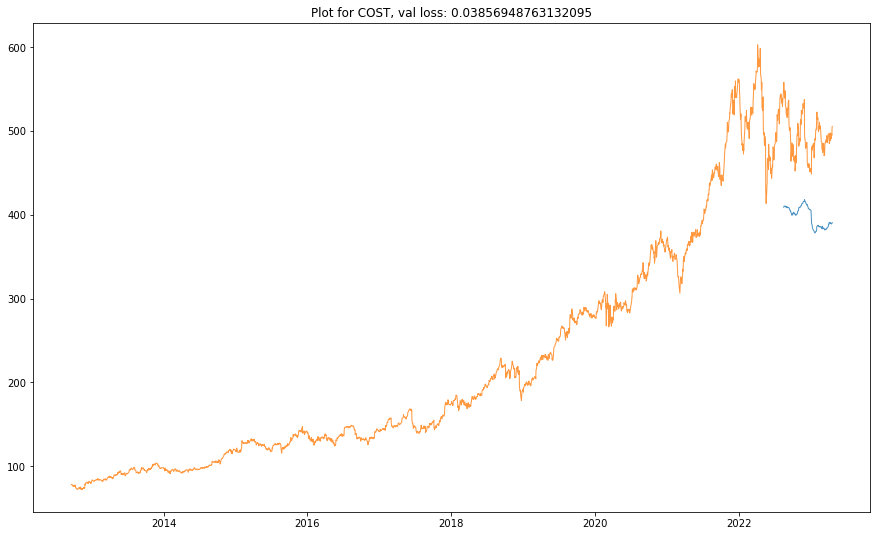

--------------------------
Final Train Loss: 0.0027
Final Test Loss: 0.0344
--------------------------
Final Train MAPE: 167.4459991455078
Final Test MAPE: 19.197500228881836
Val loss for PFE: 0.06334405392408371


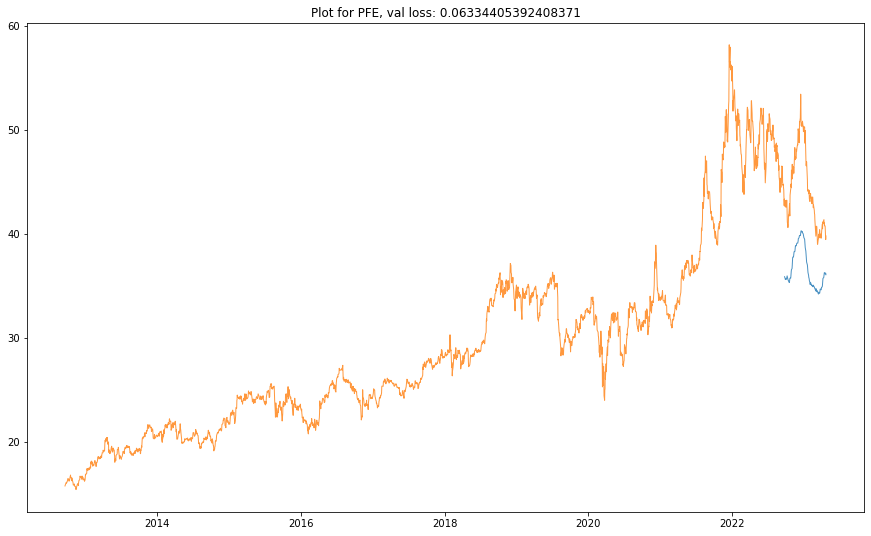

--------------------------
Final Train Loss: 0.0048
Final Test Loss: 0.0344
--------------------------
Final Train MAPE: 43.73910140991211
Final Test MAPE: 16.757699966430664
Val loss for WMT: 0.0019042278872802854


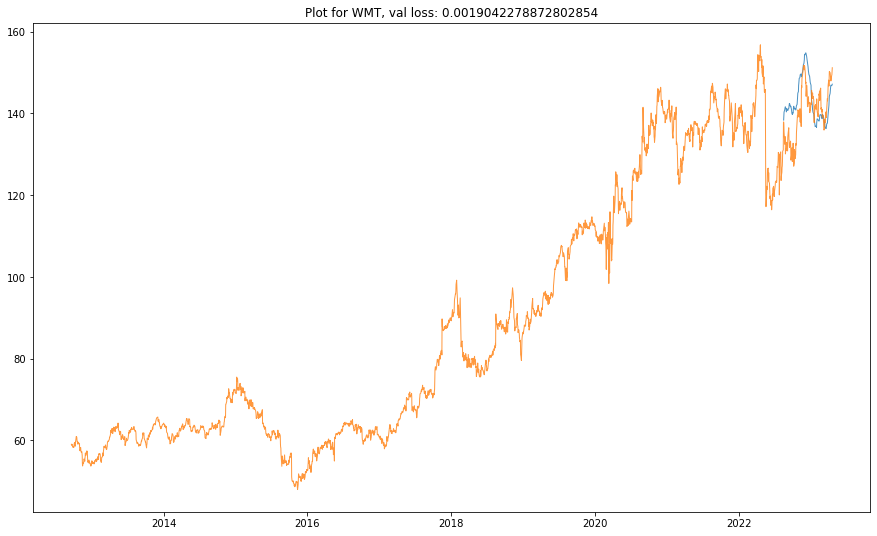

--------------------------
Final Train Loss: 0.0013
Final Test Loss: 0.0036
--------------------------
Final Train MAPE: 93.30650329589844
Final Test MAPE: 4.98390007019043
Val loss for MCD: 0.006395582575351


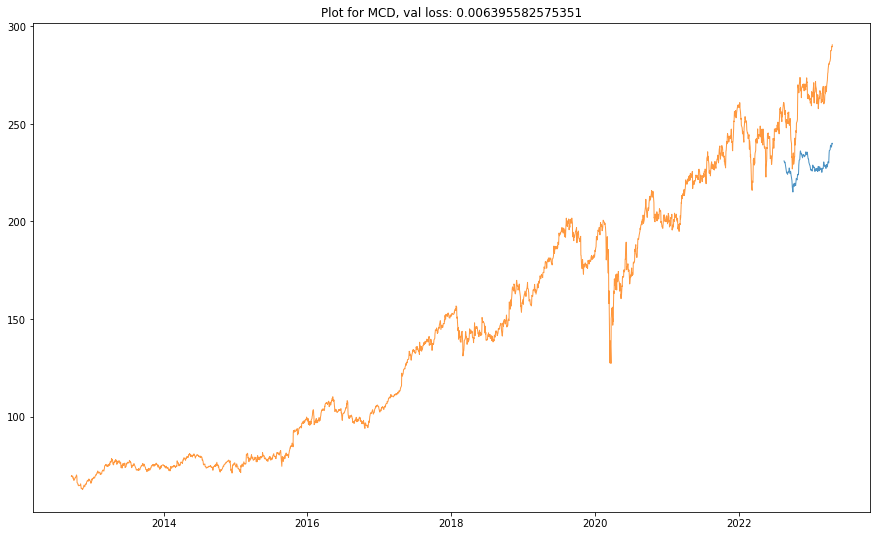

--------------------------
Final Train Loss: 0.0033
Final Test Loss: 0.0233
--------------------------
Final Train MAPE: 108.52100372314453
Final Test MAPE: 12.655900001525879
Val loss for BAC: 0.0014793843729421496


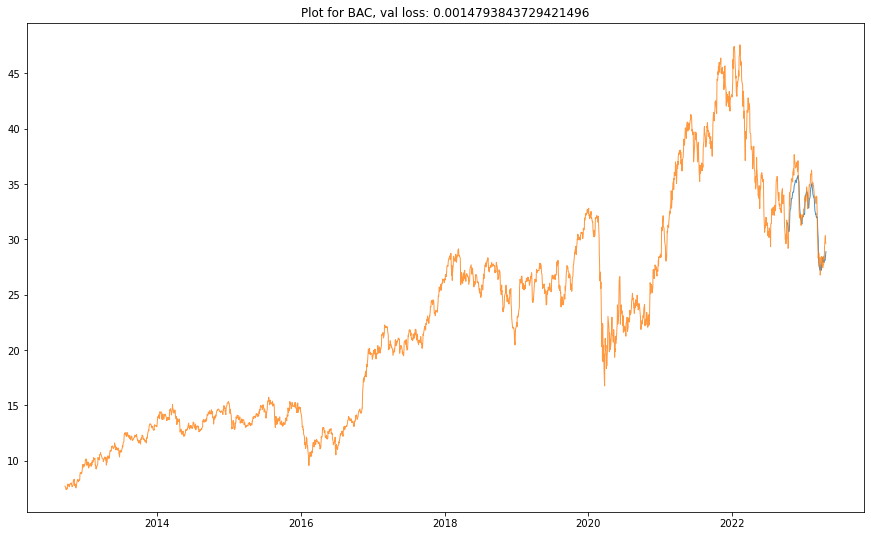

--------------------------
Final Train Loss: 0.0008
Final Test Loss: 0.0009
--------------------------
Final Train MAPE: 85.95210266113281
Final Test MAPE: 9.707599639892578
Val loss for CRM: 0.005681175272911787


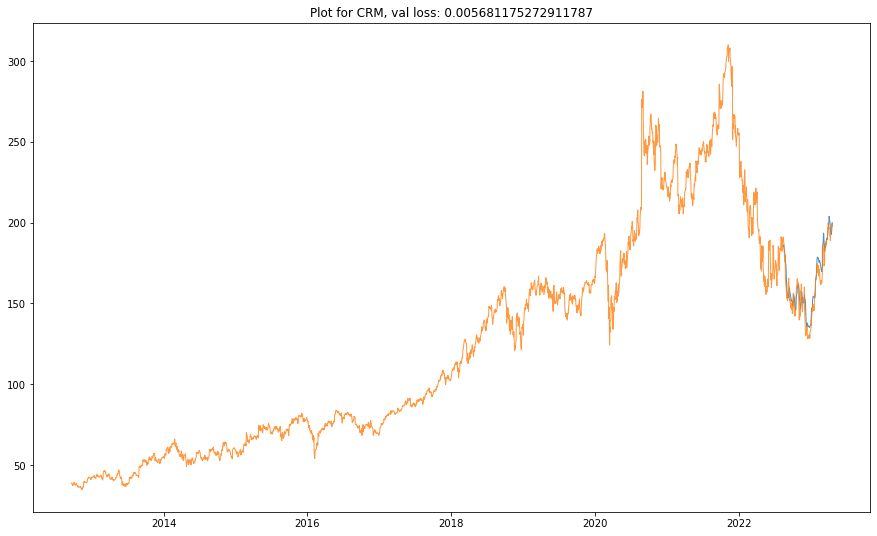

--------------------------
Final Train Loss: 0.0035
Final Test Loss: 0.0006
--------------------------
Final Train MAPE: 102.23870086669922
Final Test MAPE: 13.758500099182129


In [112]:
total_test_mape =0
total_train_mape =0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE*26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    test_acc = np.mean(mean_absolute_percentage_error(original_test,predicted_ticker[ticker]))
    
    train_predict = model.predict_generator(train_generator)
    train_predicted_df = pd.DataFrame(y_scaler.inverse_transform(train_predict))
    train_predicted_df = train_predicted_df.rename(columns={0: ticker})
    original_train = stocks_data[ticker]['y_train'].iloc[window_length:]
    train_predicted_df.index = original_train.index
    
    train_predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    train_acc = np.mean(mean_absolute_percentage_error(original_train,train_predicted_ticker[ticker]))
    
    total_train_mape+=train_acc
    total_test_mape+=test_acc
    
    %matplotlib inline
    plt.figure(figsize=(15, 9))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    #plt.plot(train_predicted_ticker[ticker], linewidth=1, alpha=0.8)
    #plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    #plot_model_performance(modelF,model,train_x,test_x,"accuracy", "val_accuracy")
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")
    train_loss = model.evaluate_generator(train_generator);
    test_loss  = model.evaluate_generator(test_generator);
    print('--------------------------')
    print(f'Final Train Loss: {np.round(train_loss,4)}')
    print(f'Final Test Loss: {np.round(test_loss,4)}') 
    print('--------------------------')
    print(f'Final Train MAPE: {np.round(train_acc,4)}')
    print(f'Final Test MAPE: {np.round(test_acc,4)}') 
    #print('\n')

In [113]:
print(f'Final MAPE score: Train={np.round(total_train_mape/len(stocks_data))}')
print(f'Final MAPE score: Test={np.round(total_test_mape/len(stocks_data))}')

Final MAPE score: Train=232.0
Final MAPE score: Test=18.0


## Write Predictions to a CSV File

In [114]:
count = 0

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    x_scaler = ds['x_scaler']
    y_scaler = ds['y_scaler']
    
    filepath='models/{}.weights.best.hdf5'.format(ticker)
    OUTPUT_SIZE = 1
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, OUTPUT_SIZE * 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.load_weights(filepath)

    model.compile(loss='mean_squared_error', optimizer='adam')
    
#     val_loss = model.evaluate_generator(valid_generator)
#     print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    if count > 0:
        predicted_ticker = pd.concat([predicted_df[ticker], predicted_ticker], axis=1)
    else: 
        predicted_ticker = predicted_df[ticker]
        
    count += 1

In [115]:
predicted_ticker.to_csv('predicted_adj_close_50.csv')

## Build RETURNS Dataframe to Predict Portfolios:
* We will use PANDAS pct_change method to build returns. This method basically returns the difference of value to the previous value

In [118]:
data = pd.read_csv('predicted_adj_close_50.csv')
data.index = data['Date']
data = data.drop(['Date'],axis=1)
data = data.sort_index(ascending=True, axis=0)
#data = data.iloc[0:91]
returns = data.pct_change()[1:]
returns

CRM       BAC       MCD       WMT       PFE      COST   
Date                                                                     
2022-08-04       NaN       NaN       NaN       NaN       NaN       NaN  \
2022-08-05       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-08       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-09       NaN       NaN       NaN       NaN       NaN       NaN   
2022-08-10       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-04-17 -0.001042 -0.001428 -0.002915 -0.000779 -0.003250 -0.001580   
2023-04-18  0.014209  0.008086  0.003735 -0.000132  0.000186 -0.001200   
2023-04-19  0.014995  0.010197  0.003695  0.000999  0.002117  0.002184   
2023-04-20  0.008056  0.007180  0.001108  0.001042 -0.000643  0.000888   
2023-04-21 -0.000850  0.002330 -0.001458  0.000547 -0.003899  0.000924   

                  KO       PEP       MRK       CVX  ...       XOM       UNH   
Date                                                ...                       
2022-08-04       NaN       NaN       NaN       NaN  ...       NaN       NaN  \
2022-08-05       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-08       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-09       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2022-08-10       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2023-04-17 -0.000971 -0.001955 -0.000249 -0.001114  ...  0.001626 -0.002758   
2023-04-18  0.002489  0.002730  0.004122  0.004148  ...  0.001446  0.001173   
2023-04-19  0.002151 -0.000343  0.002883  0.002675  ...  0.001405 -0.000803   
2023-04-20  0.002425  0.000272  0.001381 -0.000335  ...  0.001414 -0.001769   
2023-04-21  0.001504 -0.000838 -0.000459 -0.002765  ... -0.001023 -0.005342   

                META      TSLA      GOOG     GOOGL      NVDA      AMZN   
Date                                                                     
2022-08-04       NaN       NaN  0.008788       NaN       NaN       NaN  \
2022-08-05       NaN       NaN  0.005162  0.006185       NaN  0.005178   
2022-08-08       NaN -0.000715  0.000843 -0.001195       NaN  0.003341   
2022-08-09       NaN  0.036193  0.005904 -0.001658       NaN  0.000577   
2022-08-10       NaN  0.026760  0.004296  0.003612       NaN  0.006397   
...              ...       ...       ...       ...       ...       ...   
2023-04-17 -0.000724 -0.045782 -0.000996 -0.001844 -0.003508 -0.008018   
2023-04-18  0.006130  0.012826  0.002307 -0.003875  0.002253  0.002063   
2023-04-19  0.002171  0.014339  0.000907  0.001655  0.000556  0.006669   
2023-04-20 -0.000577 -0.005269 -0.001590  0.000275 -0.000531  0.003013   
2023-04-21 -0.003462 -0.034910 -0.003555 -0.001910 -0.001845 -0.001156   

                MSFT      AAPL  
Date                            
2022-08-04       NaN       NaN  
2022-08-05       NaN       NaN  
2022-08-08       NaN       NaN  
2022-08-09       NaN       NaN  
2022-08-10       NaN       NaN  
...              ...       ...  
2023-04-17 -0.003223 -0.003706  
2023-04-18  0.001512  0.003654  
2023-04-19  0.005210  0.001407  
2023-04-20  0.003803  0.000841  
2023-04-21  0.000337 -0.001194  

[180 rows x 28 columns]

In [119]:
returns.isna().sum()

CRM       9
BAC      46
MCD      12
WMT      10
PFE      36
COST     10
KO       28
PEP      15
MRK      22
CVX      11
HD        6
MA        4
AVGO      5
PG       17
LLY      12
V        10
JPM      14
JNJ      14
XOM       8
UNH       9
META      8
TSLA      2
GOOG      0
GOOGL     1
NVDA     16
AMZN      1
MSFT     22
AAPL      5
dtype: int64

In [120]:
Covariance = returns.cov()
Correlation = returns.corr()
np.round(Correlation,3)

CRM    BAC    MCD    WMT    PFE   COST     KO    PEP    MRK    CVX   
CRM    1.000  0.557  0.269  0.065 -0.033  0.047  0.248  0.197  0.104  0.298  \
BAC    0.557  1.000  0.287  0.286  0.207  0.144  0.251  0.255  0.228  0.411   
MCD    0.269  0.287  1.000  0.378  0.535  0.198  0.640  0.689  0.628  0.698   
WMT    0.065  0.286  0.378  1.000  0.720  0.759  0.434  0.447  0.501  0.363   
PFE   -0.033  0.207  0.535  0.720  1.000  0.617  0.545  0.547  0.625  0.466   
COST   0.047  0.144  0.198  0.759  0.617  1.000  0.225  0.221  0.289  0.241   
KO     0.248  0.251  0.640  0.434  0.545  0.225  1.000  0.599  0.467  0.472   
PEP    0.197  0.255  0.689  0.447  0.547  0.221  0.599  1.000  0.689  0.530   
MRK    0.104  0.228  0.628  0.501  0.625  0.289  0.467  0.689  1.000  0.633   
CVX    0.298  0.411  0.698  0.363  0.466  0.241  0.472  0.530  0.633  1.000   
HD     0.067  0.097  0.605  0.345  0.444  0.205  0.661  0.451  0.433  0.527   
MA     0.552  0.514  0.601  0.129  0.173 -0.102  0.391  0.388  0.358  0.555   
AVGO   0.465  0.379  0.392  0.042  0.202 -0.069  0.488  0.309  0.151  0.247   
PG     0.100  0.142  0.632  0.545  0.815  0.483  0.532  0.650  0.639  0.498   
LLY    0.263  0.341  0.277 -0.090 -0.044 -0.443  0.164  0.191  0.152  0.196   
V      0.508  0.477  0.564  0.117  0.170 -0.113  0.430  0.361  0.346  0.517   
JPM    0.435  0.642  0.778  0.334  0.451  0.149  0.574  0.563  0.552  0.711   
JNJ    0.135  0.282  0.614  0.208  0.444 -0.150  0.448  0.533  0.529  0.490   
XOM    0.177  0.409  0.506  0.152  0.147 -0.092  0.476  0.234  0.277  0.607   
UNH    0.132  0.165  0.757  0.465  0.628  0.185  0.600  0.707  0.705  0.620   
META   0.389  0.106  0.293 -0.035 -0.060  0.067  0.203  0.224  0.151  0.274   
TSLA   0.338  0.240  0.657  0.221  0.276  0.119  0.266  0.521  0.467  0.563   
GOOG   0.463  0.203  0.598  0.095  0.138 -0.046  0.484  0.355  0.231  0.418   
GOOGL  0.481  0.286  0.412  0.236  0.254  0.207  0.374  0.239  0.177  0.319   
NVDA   0.254  0.079  0.700  0.386  0.524  0.305  0.586  0.541  0.380  0.492   
AMZN   0.308  0.235  0.425  0.360  0.292  0.452  0.108  0.316  0.296  0.420   
MSFT   0.499  0.305  0.489  0.135  0.228  0.095  0.252  0.345  0.366  0.467   
AAPL   0.421  0.280  0.455  0.426  0.303  0.458  0.218  0.488  0.347  0.372   

       ...    XOM    UNH   META   TSLA   GOOG  GOOGL   NVDA   AMZN   MSFT   
CRM    ...  0.177  0.132  0.389  0.338  0.463  0.481  0.254  0.308  0.499  \
BAC    ...  0.409  0.165  0.106  0.240  0.203  0.286  0.079  0.235  0.305   
MCD    ...  0.506  0.757  0.293  0.657  0.598  0.412  0.700  0.425  0.489   
WMT    ...  0.152  0.465 -0.035  0.221  0.095  0.236  0.386  0.360  0.135   
PFE    ...  0.147  0.628 -0.060  0.276  0.138  0.254  0.524  0.292  0.228   
COST   ... -0.092  0.185  0.067  0.119 -0.046  0.207  0.305  0.452  0.095   
KO     ...  0.476  0.600  0.203  0.266  0.484  0.374  0.586  0.108  0.252   
PEP    ...  0.234  0.707  0.224  0.521  0.355  0.239  0.541  0.316  0.345   
MRK    ...  0.277  0.705  0.151  0.467  0.231  0.177  0.380  0.296  0.366   
CVX    ...  0.607  0.620  0.274  0.563  0.418  0.319  0.492  0.420  0.467   
HD     ...  0.567  0.584  0.199  0.319  0.542  0.428  0.517  0.200  0.295   
MA     ...  0.448  0.470  0.411  0.586  0.658  0.499  0.499  0.309  0.687   
AVGO   ...  0.292  0.256  0.413  0.289  0.569  0.555  0.398  0.116  0.646   
PG     ...  0.039  0.611  0.204  0.424  0.265  0.262  0.601  0.312  0.404   
LLY    ...  0.392  0.235  0.091  0.248  0.430  0.279  0.057  0.125  0.472   
V      ...  0.497  0.485  0.420  0.561  0.704  0.618  0.477  0.319  0.760   
JPM    ...  0.558  0.648  0.350  0.595  0.547  0.452  0.567  0.366  0.569   
JNJ    ...  0.428  0.634  0.145  0.469  0.520  0.356  0.352  0.257  0.500   
XOM    ...  1.000  0.419  0.054  0.203  0.440  0.269  0.354  0.032  0.226   
UNH    ...  0.419  1.000  0.148  0.617  0.485  0.336  0.710  0.252  0.425   
META   ...  0.054  0.148  1.000  0.506  0.667  0.607  0.352  0.470  0.644   
TSLA   ...  0.203  0.61

In [121]:
Covariance

CRM       BAC       MCD           WMT           PFE          COST   
CRM    0.000175  0.000070  0.000015  3.119085e-06 -1.770527e-06  1.830881e-06  \
BAC    0.000070  0.000087  0.000011  9.934477e-06  7.910762e-06  4.253954e-06   
MCD    0.000015  0.000011  0.000019  5.775366e-06  9.335828e-06  2.531387e-06   
WMT    0.000003  0.000010  0.000006  1.289195e-05  1.064146e-05  8.027419e-06   
PFE   -0.000002  0.000008  0.000009  1.064146e-05  1.598106e-05  7.717603e-06   
COST   0.000002  0.000004  0.000003  8.027419e-06  7.717603e-06  8.670728e-06   
KO     0.000012  0.000008  0.000010  5.735127e-06  7.763537e-06  2.511579e-06   
PEP    0.000007  0.000006  0.000008  4.094256e-06  5.485896e-06  1.695535e-06   
MRK    0.000004  0.000006  0.000008  5.161143e-06  7.098628e-06  2.514032e-06   
CVX    0.000017  0.000016  0.000013  5.668017e-06  7.993486e-06  3.112748e-06   
HD     0.000003  0.000003  0.000008  3.652577e-06  5.276240e-06  1.773819e-06   
MA     0.000048  0.000031  0.000017  3.076969e-06  4.658230e-06 -1.998523e-06   
AVGO   0.000035  0.000019  0.000010  8.560894e-07  4.546374e-06 -1.155590e-06   
PG     0.000004  0.000004  0.000008  5.896162e-06  9.917838e-06  4.375037e-06   
LLY    0.000014  0.000013  0.000005 -1.241256e-06 -7.205395e-07 -5.112214e-06   
V      0.000048  0.000031  0.000017  2.976151e-06  4.894841e-06 -2.342198e-06   
JPM    0.000047  0.000046  0.000027  9.523675e-06  1.476227e-05  3.558055e-06   
JNJ    0.000008  0.000012  0.000011  3.100039e-06  7.810286e-06 -1.867838e-06   
XOM    0.000010  0.000015  0.000009  2.256389e-06  2.522565e-06 -1.118729e-06   
UNH    0.000005  0.000005  0.000010  4.947236e-06  7.849265e-06  1.611428e-06   
META   0.000057  0.000011  0.000014 -1.390497e-06 -2.743339e-06  2.187667e-06   
TSLA   0.000128  0.000070  0.000082  2.273886e-05  3.348724e-05  1.005897e-05   
GOOG   0.000035  0.000011  0.000015  1.978026e-06  3.287464e-06 -7.789287e-07   
GOOGL  0.000049  0.000021  0.000014  6.473135e-06  8.031142e-06  4.661601e-06   
NVDA   0.000015  0.000003  0.000014  6.179229e-06  9.536561e-06  4.089237e-06   
AMZN   0.000024  0.000014  0.000011  7.509846e-06  7.218999e-06  7.734134e-06   
MSFT   0.000037  0.000017  0.000012  2.760667e-06  5.283619e-06  1.635993e-06   
AAPL   0.000030  0.000014  0.000011  8.236440e-06  6.535705e-06  7.251164e-06   

             KO       PEP       MRK       CVX  ...           XOM       UNH   
CRM    0.000012  0.000007  0.000004  0.000017  ...  9.642909e-06  0.000005  \
BAC    0.000008  0.000006  0.000006  0.000016  ...  1.489022e-05  0.000005   
MCD    0.000010  0.000008  0.000008  0.000013  ...  9.053114e-06  0.000010   
WMT    0.000006  0.000004  0.000005  0.000006  ...  2.256389e-06  0.000005   
PFE    0.000008  0.000005  0.000007  0.000008  ...  2.522565e-06  0.000008   
COST   0.000003  0.000002  0.000003  0.000003  ... -1.118729e-06  0.000002   
KO     0.000013  0.000006  0.000005  0.000008  ...  7.352388e-06  0.000007   
PEP    0.000006  0.000007  0.000005  0.000006  ...  2.519203e-06  0.000005   
MRK    0.000005  0.000005  0.000008  0.000008  ...  3.348240e-06  0.000006   
CVX    0.000008  0.000006  0.000008  0.000019  ...  1.101306e-05  0.000008   
HD     0.000007  0.000003  0.000004  0.000007  ...  6.830993e-06  0.000005   
MA     0.000010  0.000007  0.000007  0.000016  ...  1.215123e-05  0.000009   
AVGO   0.000010  0.000005  0.000002  0.000006  ...  6.750273e-06  0.000004   
PG     0.000006  0.000005  0.000006  0.000007  ...  4.936519e-07  0.000006   
LLY    0.000002  0.000002  0.000002  0.000003  ...  6.349621e-06  0.000003   
V      0.000011  0.000007  0.000007  0.000016  ...  1.448859e-05  0.000010   
JPM    0.000017  0.000012  0.000013  0.000025  ...  1.871848e-05  0.000016   
JNJ    0.000007  0.000006  0.000006  0.000009  ...  7.506540e-06  0.000008   
XOM    0.000007  0.000003  0.000003  0.000011  ...  1.684648e-05  0.000005   
UNH    0.000007  0.000005  0.000006  0.000008  ...  5.093706e-06  0.000009   
META   0.000008  0.00000

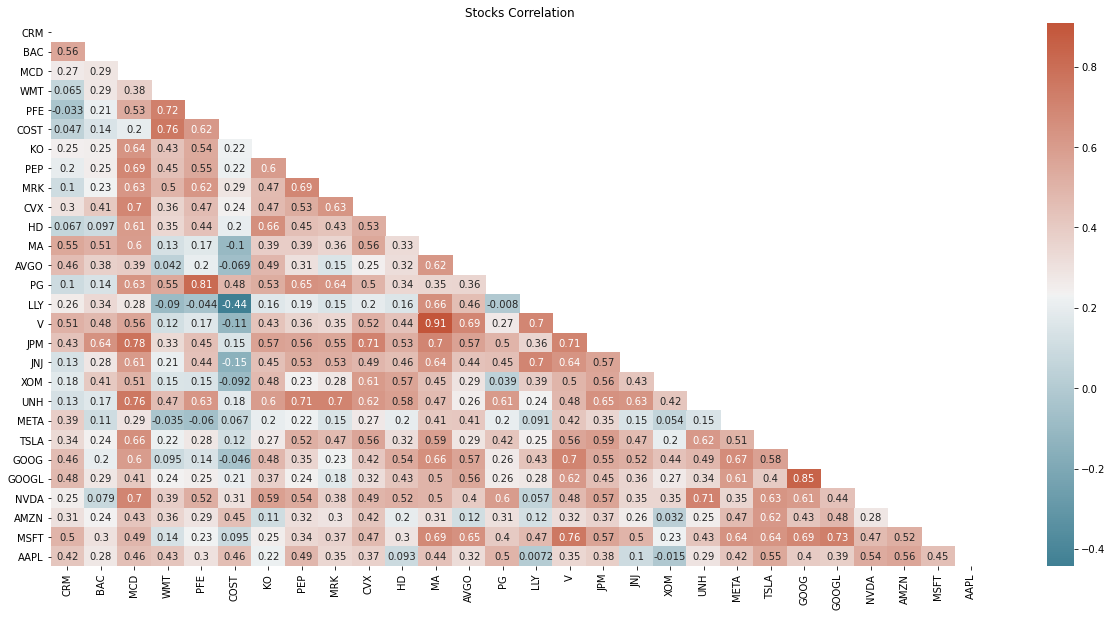

In [122]:
correlation_matrix_plot(Correlation)

In [123]:
companies = SP500_top30[0:28]#['AAPL', 'MSFT', 'META', 'TSLA', 'UNH', 'GOOGL']
mean_Covariance = Covariance.mean()
mean_Covariance

CRM      0.000032
BAC      0.000020
MCD      0.000014
WMT      0.000006
PFE      0.000008
COST     0.000003
KO       0.000009
PEP      0.000007
MRK      0.000007
CVX      0.000013
HD       0.000006
MA       0.000022
AVGO     0.000014
PG       0.000007
LLY      0.000007
V        0.000024
JPM      0.000028
JNJ      0.000011
XOM      0.000008
UNH      0.000008
META     0.000027
TSLA     0.000095
GOOG     0.000019
GOOGL    0.000022
NVDA     0.000013
AMZN     0.000014
MSFT     0.000019
AAPL     0.000014
dtype: float64

### Check if a particular pair of stock can be paired together
* If a pair of stock meets both Covariance and correlation thresholds then they can be paired together. The plot below shows pairable stocks in blue and unpairable ones in red.

In [124]:
def get_pairable(data, Covariance, Correlation):
    Pairable = np.zeros(Covariance.shape)
    plt.figure(figsize=(16,7))

    for i in range(len(companies)):
        for j in range(len(companies)-i):
            if((Covariance[i,j] > mean_Covariance[i])\
               or (Covariance[i,j] > mean_Covariance[j])\
               or Correlation[i][j]>0.5):
                plt.plot(i, j, 'o', color='red', alpha=0.5) 
            else:
                plt.plot(i, j, 'o', color='blue', alpha=0.5)
                Pairable[i,j] = 1

    plt.xlim(-1,len(companies)+1)
    plt.ylim(-1,len(companies)+1)
    plt.xticks(range(len(companies)), companies, rotation=40)    
    plt.yticks(range(len(companies)), companies)
    #plt.set_xticklabels(companies,fontsize=10,rotation=40)
    plt.legend()
    return Pairable

No handles with labels found to put in legend.


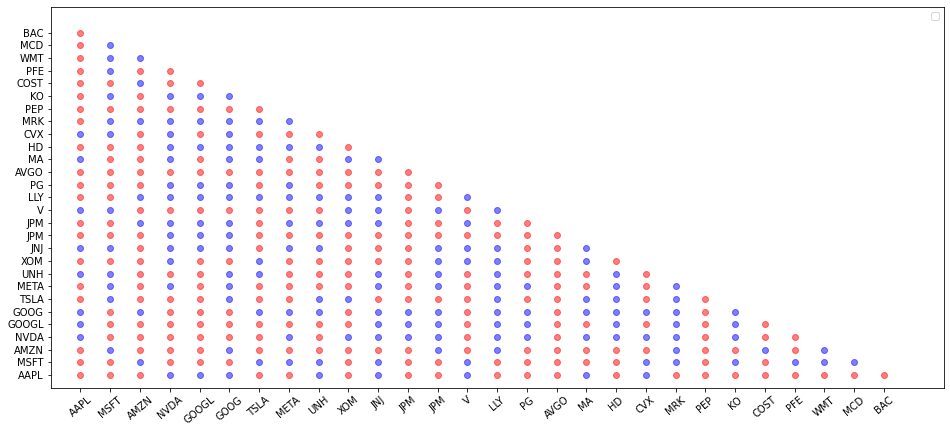

In [125]:
Pairable = get_pairable(data,np.array(Covariance), np.array(Correlation))

In [126]:
Pairable

array([[0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 1., 0., 1

##  Risk-Adjusted Returns
The **Sharpe ratio**—also known as the modified Sharpe ratio or the Sharpe index—is a way to measure the performance of an investment by taking risk into account. It can be used to evaluate a single security or an entire investment portfolio. In either case, the higher the ratio, the better the investment in terms of risk-adjusted returns.

The Sharpe Ratio is calculated by determining an asset or a portfolio’s “excess return” for a given period of time. This amount is divided by the portfolio’s standard deviation, which is a measure of its volatility. To calculate the Sharpe Ratio, use this formula:

        * Sharpe Ratio = (Rp – Rf) / Standard deviation
**Rp**: return of portfolio/mean return

**Rf**: risk-free rate of 3.7% ie current risk free rate of US market

**Standard Deviation**: standard deviation of the portfolio’s excess return

**Sharpe ratio > 1** is considered **good**

**Sharpe ratio > 2** is considered **very good**

**Sharpe ratio > 3** is considered **excellent**

*Limitations:* Sharpe ratio assumes that an investment’s average returns are normally distributed on a curve.Unfortunately, normal distributions don’t represent the real world of financial markets very well. Over the short term, investment returns don’t follow a normal distribution. Market volatility can be higher or lower, while the distribution of returns on a curve cluster around the tails. This can render standard deviation less effective as a measure of risk.


In [205]:
# Function to calculate the Shapre Ratio
Rf = 0/100;#3.7/100  #risk_free_rate
stocks_rng = range(len(companies))

def sharpe_ratio(pair, portfolio_weights, meanR, cov):
    #print("SR",pair,portfolio_weights, meanR, cov)
    #print (meanR.T)
    Rp = portfolio_weights.dot(meanR.T) 
    SigmaP = portfolio_weights.dot(cov.dot(portfolio_weights.T)) * len(returns)
    s_ratio = (Rp - Rf)/np.sqrt(SigmaP)
    print (s_ratio)#, Rp, SigmaP, Rf)
    return s_ratio


In [206]:
stocks_rng

range(0, 28)

**Checking whether other stocks can be added to selected pair**
* Only those pairs are selected in a portfolio that are not correlated with each other.

In [207]:
def check_pairs(pair):
    not_in_pair = []
    for i in stocks_rng:
        if(i not in pair):
            not_in_pair.append(i)
        else:
            continue
            
    for tick in not_in_pair:
        total_pair = len(pair)
        for i in pair:
            if(Pairable[tick,i]!=1 or Pairable[i,tick]!=1):
                total_pair -= 1
        if(float(total_pair)/len(pair) > 0.5):
            pair.add(tick)              
    return pair

* Just some checks to see what the covariance and correlations 

In [208]:
#symbols = [companies[s] for s in pair] 
symbols =['AAPL', 'MSFT', 'GOOGL', 'META']
len(returns)
returns[symbols[3]].mean()*len(returns)
returns[symbols].cov()

AAPL      MSFT     GOOGL      META
AAPL   0.000029  0.000014  0.000016  0.000025
MSFT   0.000014  0.000033  0.000032  0.000042
GOOGL  0.000016  0.000032  0.000056  0.000051
META   0.000025  0.000042  0.000051  0.000121

Analyzing returns for:  PEP


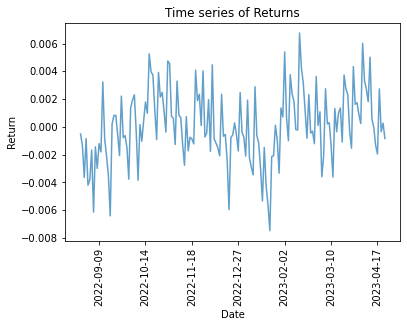

In [209]:
ticker = companies[21]
print("Analyzing returns for: ", ticker)
plt.title('Time series of Returns')
returns[ticker].plot(alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel("Return")
plt.show()

### Selecting Optimized Portfolios
We create all possible combinations of pairs in given list of tickers. For example if we have **n** tickers, then possible pairs will be **C(n,2)= n!/(2!*(n-2)!)**

* For each pair, we then check which other stock can be added together by checking it's correlation and covariance values, and they are added in same portfolio.

* Portfolis with good, better, best Sharpe Ratio are saved separately.

In [210]:
portfolio_collection = []
optim = {'good':[],'better':[],'best': []}

def select(combo):
    pair = set(combo)
    pair = check_pairs(pair)
    #print("new pair by checking pairable: ", pair)
    if pair in portfolio_collection:
        #print('returning')
        return
    portfolio_collection.append(pair)
    #print("portfoilio: ", portfolio_collection)
    sharpe_r = 0
    eff_weights = np.ones(len(pair))

    symbols = [companies[s] for s in pair]  
    mean_returns = np.array(returns[symbols].mean()) * len(returns)
    sub_cov_mat = np.array(returns[symbols].cov())        
    print(symbols)#, mean_returns, sub_cov_mat)
    for _ in range(10):
        weights = [np.random.randint(50,500) for _ in pair]
        weights = np.array(weights, dtype=float)
        weights /= weights.sum()
        s_r = sharpe_ratio(pair, weights, mean_returns, sub_cov_mat)
        #print(pair)
        print(weights)
        #print(mean_returns)
        #print(sub_cov_mat)
        if( s_r > sharpe_r):
            sharpe_r = s_r
            eff_weights = weights
        
    if (sharpe_r >= 1 and sharpe_r < 2) :
        optim['good'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if (sharpe_r >= 2 and sharpe_r < 3) :
        optim['better'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if(sharpe_r >=3) :
        optim['best'].append([[companies[s] for s in pair],eff_weights,sharpe_r])

In [211]:
#(returns["MSFT"].mean())/returns["MSFT"].std()

* Make stocks combinations with each pair containing 2 stocks and rest of the stocks to be added later

In [212]:
from itertools import combinations
count=0
run = list(combinations(stocks_rng,2))
for combo in run:
    count +=1
    if(Pairable[combo[0],combo[1]]!=1 or Pairable[combo[1],combo[0]]!=1):
        continue
    else:
        #print("taking the combo")
        print(combo)
        select(combo)
print("number of combinations: ", count)

(0, 3)
['AAPL', 'NVDA', 'JNJ', 'JPM', 'V', 'LLY']
1.168626057583484
[0.23934426 0.07868852 0.31278689 0.0347541  0.15803279 0.17639344]
1.7962468386133361
[0.09692513 0.31885027 0.07085561 0.07820856 0.17580214 0.25935829]
1.5113179681393571
[0.19280875 0.20792079 0.12871287 0.10057322 0.17300677 0.19697759]
1.6845869272962597
[0.11023622 0.21627297 0.12808399 0.10131234 0.19947507 0.24461942]
1.4361544391406211
[0.15250345 0.1626091  0.20073496 0.16444649 0.16674322 0.15296279]
1.4893772019796772
[0.19963117 0.20470263 0.13831259 0.16090364 0.09912402 0.19732596]
1.5914082007042774
[0.15579515 0.22318059 0.10727763 0.03180593 0.26792453 0.21401617]
1.6333470666284828
[0.28311499 0.15866084 0.04002911 0.08151383 0.10407569 0.33260553]
1.4420485244957686
[0.17650303 0.1318257  0.14120243 0.25206839 0.15388858 0.14451186]
1.59939271312952
[0.11590296 0.09272237 0.10727763 0.24150943 0.23989218 0.20269542]
(0, 4)
['AAPL', 'GOOGL', 'JNJ', 'JPM', 'V', 'LLY']
0.5547739796727167
[0.21938023 0

['MSFT', 'NVDA', 'META', 'JNJ', 'JPM', 'V', 'LLY']
1.6458819120252166
[0.12981244 0.23889437 0.17077986 0.13178677 0.11648569 0.04343534
 0.16880553]
1.7099088940394547
[0.14206128 0.31545961 0.11699164 0.03969359 0.06545961 0.14554318
 0.17479109]
1.4788501261191125
[0.17750533 0.1663113  0.03731343 0.20469083 0.20095949 0.03091684
 0.18230277]
1.542523422290365
[0.06745818 0.26767404 0.17377226 0.21694549 0.13545602 0.06044253
 0.07825148]
1.4434249807349446
[0.21570859 0.04154809 0.21343199 0.14797951 0.07626636 0.17188389
 0.13318156]
2.0078250543854077
[0.05697823 0.24839949 0.0793854  0.03521127 0.13252241 0.13060179
 0.31690141]
1.5615272811490126
[0.08503203 0.04717531 0.2341293  0.22539313 0.15375655 0.11298777
 0.14152592]
1.5805009118781401
[0.05930087 0.04993758 0.26029963 0.1835206  0.12734082 0.20911361
 0.11048689]
1.69352885234361
[0.17384615 0.23282051 0.16871795 0.10666667 0.03897436 0.03128205
 0.24769231]
1.5837705999047837
[0.12463158 0.17515789 0.14357895 0.179789

In [213]:
portfolio_collection

[{0, 3, 10, 12, 13, 14},
 {0, 4, 10, 12, 13, 14},
 {0, 5, 8, 10, 12, 13, 14},
 {0, 5, 6, 8, 10, 12, 14, 17},
 {0, 3, 4, 10, 12, 13, 14},
 {0, 10, 12, 13},
 {0, 3, 5, 10, 12, 17},
 {0, 3, 5, 10, 12, 17, 19},
 {1, 2, 20, 25},
 {1, 6, 8, 10, 14},
 {1, 7, 10, 12, 13, 14},
 {1, 7, 8, 10, 12, 13, 14},
 {1, 10, 12, 13},
 {1, 19},
 {1, 2, 5, 6, 7, 14, 20},
 {1, 22},
 {1, 24},
 {1, 26},
 {2, 5, 12, 14},
 {2, 5, 7, 10, 12, 14},
 {2, 5, 6, 8, 10, 12, 14},
 {2, 23},
 {3, 7, 10, 12, 14},
 {3, 9, 12, 13, 14},
 {3, 11},
 {3, 7, 9, 10, 12, 13, 14},
 {3, 7, 10, 12, 14, 15},
 {3, 7, 10, 12, 14, 18},
 {3, 7, 10, 12, 14, 20},
 {3, 22},
 {4, 11},
 {4, 10, 12, 13, 14},
 {4, 15},
 {4, 18},
 {4, 20},
 {4, 22},
 {5, 6, 8, 10, 12, 14},
 {5, 7, 10, 12, 14},
 {0, 3, 5, 7, 8, 10, 12, 14},
 {5, 11},
 {5, 7, 10, 12, 14, 15},
 {5, 6, 7, 8, 10, 12, 14, 18},
 {2, 5, 6, 14, 20},
 {5, 22},
 {1, 5, 6, 8, 10, 12, 14},
 {6, 9, 14, 17},
 {5, 6, 8, 10, 12, 14, 17},
 {1, 3, 7, 10, 12, 13, 14},
 {3, 5, 7, 10, 12, 14},
 {3, 5, 7

### Look at DataFrame for Good Portfolios

In [214]:
good = pd.DataFrame.from_dict(optim['good'])
good.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [215]:
def build_portfolio_return(df_ret):
    portfolio_return = []
    for row in df_ret.iterrows():
        print(row[1][0])
        print(row[1][1])
        mean = np.array(returns[row[1][0]].mean()) * len(returns)
        portfolio_weights = np.array(row[1][1])
        Rp = portfolio_weights.dot(mean.T) 
        portfolio_return.append(round(Rp * 100, 2))
        #print('Rp:', Rp)
    return portfolio_return

In [216]:
good['Portfolio_Returns'] = build_portfolio_return(good)

['AAPL', 'NVDA', 'JNJ', 'JPM', 'V', 'LLY']
[0.09692513 0.31885027 0.07085561 0.07820856 0.17580214 0.25935829]
['AAPL', 'GOOGL', 'JNJ', 'JPM', 'V', 'LLY']
[0.09358289 0.07620321 0.17245989 0.28743316 0.05681818 0.31350267]
['AAPL', 'GOOG', 'UNH', 'JNJ', 'JPM', 'V', 'LLY']
[0.17684887 0.07202572 0.10032154 0.03858521 0.26752412 0.19614148
 0.14855305]
['AAPL', 'NVDA', 'GOOGL', 'JNJ', 'JPM', 'V', 'LLY']
[0.04866412 0.19179389 0.05916031 0.10400763 0.20992366 0.27576336
 0.11068702]
['AAPL', 'JNJ', 'JPM', 'V']
[0.24181697 0.23513694 0.23513694 0.28790915]
['AAPL', 'NVDA', 'GOOG', 'JNJ', 'JPM', 'MA']
[0.11231394 0.31461434 0.05277402 0.18132612 0.17320704 0.16576455]
['AAPL', 'NVDA', 'GOOG', 'JNJ', 'JPM', 'MA', 'CVX']
[0.0416     0.19893333 0.05333333 0.168      0.20693333 0.17173333
 0.15946667]
['MSFT', 'META', 'JNJ', 'JPM', 'V', 'LLY']
[0.06045651 0.14620605 0.04318322 0.28624306 0.21838371 0.24552745]
['MSFT', 'META', 'UNH', 'JNJ', 'JPM', 'V', 'LLY']
[0.12707444 0.14698909 0.10905642 0

In [217]:
def build_portfolio_voltality(df_ret):
    portfolio_volatility = []
    for row in df_ret.iterrows():
        portfolio = row[1][0]
        portfolio_weights = row[1][1]
        portfolio_data = data[portfolio]
        portfolio = portfolio_data.mul(portfolio_weights,axis=1).sum(axis=1)
        volatility = np.std(portfolio)
        portfolio_volatility.append(volatility)
    return portfolio_volatility

In [218]:
good['Portfolio_Volatility'] = build_portfolio_voltality(good)
good

Portfolio   
0                 [AAPL, NVDA, JNJ, JPM, V, LLY]  \
1                [AAPL, GOOGL, JNJ, JPM, V, LLY]   
2            [AAPL, GOOG, UNH, JNJ, JPM, V, LLY]   
3          [AAPL, NVDA, GOOGL, JNJ, JPM, V, LLY]   
4                            [AAPL, JNJ, JPM, V]   
5               [AAPL, NVDA, GOOG, JNJ, JPM, MA]   
6          [AAPL, NVDA, GOOG, JNJ, JPM, MA, CVX]   
7                 [MSFT, META, JNJ, JPM, V, LLY]   
8            [MSFT, META, UNH, JNJ, JPM, V, LLY]   
9                            [MSFT, JNJ, JPM, V]   
10                        [AMZN, JPM, GOOG, LLY]   
11             [AMZN, GOOG, META, JNJ, JPM, LLY]   
12                   [NVDA, META, JNJ, JPM, LLY]   
13                                   [JPM, NVDA]   
14           [NVDA, META, XOM, JNJ, JPM, V, LLY]   
15               [NVDA, META, JNJ, JPM, LLY, PG]   
16               [NVDA, META, JNJ, JPM, LLY, HD]   
17                                    [NVDA, KO]   
18                                  [JPM, GOOGL]   
19                     [GOOGL, JNJ, JPM, V, LLY]   
20                   [GOOG, META, JNJ, JPM, LLY]   
21  [AAPL, NVDA, GOOG, META, UNH, JNJ, JPM, LLY]   
22                                   [JPM, GOOG]   
23               [GOOG, META, JNJ, JPM, LLY, PG]   
24             [NVDA, GOOG, META, JNJ, JPM, LLY]   
25         [NVDA, GOOG, META, JNJ, JPM, LLY, PG]   
26         [NVDA, GOOG, META, JNJ, JPM, LLY, HD]   
27            [NVDA, GOOGL, META, JNJ, JPM, LLY]   
28   [AAPL, NVDA, GOOG, META, JNJ, JPM, LLY, MA]   
29                       [XOM, JNJ, JPM, V, LLY]   

                                                                                                                                                                    Weights   
0                                            [0.09692513368983957, 0.31885026737967914, 0.07085561497326204, 0.07820855614973261, 0.17580213903743316, 0.25935828877005346]  \
1                                             [0.09358288770053476, 0.07620320855614973, 0.17245989304812834, 0.2874331550802139, 0.056818181818181816, 0.3135026737967914]   
2                          [0.17684887459807075, 0.0720257234726688, 0.10032154340836012, 0.03858520900321544, 0.267524115755627, 0.19614147909967847, 0.14855305466237942]   
3                          [0.04866412213740458, 0.191793893129771, 0.05916030534351145, 0.10400763358778627, 0.2099236641221374, 0.27576335877862596, 0.11068702290076336]   
4                                                                                       [0.24181696726786908, 0.23513694054776219, 0.23513694054776219, 0.2879091516366065]   
5                                            [0.11231393775372124, 0.31461434370771313, 0.05277401894451962, 0.18132611637347767, 0.17320703653585928, 0.16576454668470908]   
6                                                  [0.0416, 0.19893333333333332, 0.05333333333333334, 0.168, 0.20693333333333333, 0.17173333333333332, 0.15946666666666667]   
7                                               [0.06045650832819247, 0.1462060456508328, 0.0431832202344232, 0.2862430598396052, 0.21838371375694016, 0.24552745219000616]   
8                        [0.12707444286391656, 0.14698909435751542, 0.10905642484589853, 0.09577999051683263, 0.13703176861071598, 0.18207681365576103, 0.2019914651493599]   
9                                                                                        [0.22240943555181128, 0.06486941870261162, 0.3951137320977254, 0.3176074136478517]   
10                                                                                        [0.12582056892778992, 0.1400437636761488, 0.2603938730853392, 0.4737417943107221]   
11                                           [0.11370814908401769, 0.09412507896399241, 0.24257738471257106, 0.27668982943777637, 0.060644346178142766, 0.2122552116234997]   
12                                                                [0.16739446870451238, 0.31004366812227074, 0.10043668122270742, 0.15138282387190685, 

In [219]:
optim['better']

[[['NVDA', 'XOM', 'JPM', 'V', 'LLY'],
  array([0.40771124, 0.07875308, 0.0680886 , 0.1435603 , 0.30188679]),
  2.114741145577115],
 [['NVDA', 'META', 'JNJ', 'JPM', 'LLY', 'MRK'],
  array([0.12      , 0.25101449, 0.08637681, 0.1715942 , 0.25043478,
         0.12057971]),
  2.0089093914360765],
 [['MSFT', 'NVDA', 'META', 'JNJ', 'JPM', 'V', 'LLY'],
  array([0.05697823, 0.24839949, 0.0793854 , 0.03521127, 0.13252241,
         0.13060179, 0.31690141]),
  2.0078250543854077],
 [['XOM', 'JPM', 'V', 'LLY'],
  array([0.28968903, 0.06792144, 0.29214403, 0.3502455 ]),
  2.041023144789117]]

In [220]:
better = pd.DataFrame.from_dict(optim['better'])
better.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [221]:
better['Portfolio_Returns'] = build_portfolio_return(better)
better['Portfolio_Volatility'] = build_portfolio_voltality(better)

['NVDA', 'XOM', 'JPM', 'V', 'LLY']
[0.40771124 0.07875308 0.0680886  0.1435603  0.30188679]
['NVDA', 'META', 'JNJ', 'JPM', 'LLY', 'MRK']
[0.12       0.25101449 0.08637681 0.1715942  0.25043478 0.12057971]
['MSFT', 'NVDA', 'META', 'JNJ', 'JPM', 'V', 'LLY']
[0.05697823 0.24839949 0.0793854  0.03521127 0.13252241 0.13060179
 0.31690141]
['XOM', 'JPM', 'V', 'LLY']
[0.28968903 0.06792144 0.29214403 0.3502455 ]


In [222]:
better

Portfolio   
0              [NVDA, XOM, JPM, V, LLY]  \
1      [NVDA, META, JNJ, JPM, LLY, MRK]   
2  [MSFT, NVDA, META, JNJ, JPM, V, LLY]   
3                    [XOM, JPM, V, LLY]   

                                                                                                                                                Weights   
0                                                [0.4077112387202625, 0.07875307629204266, 0.06808859721082855, 0.1435602953240361, 0.3018867924528302]  \
1                                        [0.12, 0.2510144927536232, 0.08637681159420289, 0.17159420289855074, 0.25043478260869567, 0.12057971014492753]   
2  [0.056978233034571064, 0.24839948783610755, 0.0793854033290653, 0.035211267605633804, 0.13252240717029448, 0.13060179257362356, 0.31690140845070425]   
3                                                                    [0.2896890343698854, 0.06792144026186579, 0.29214402618657936, 0.3502454991816694]   

   Sharpe Ratio  Portfolio_Returns  Portfolio_Volatility  
0      2.114741              10.43             41.874199  
1      2.008909              12.01             39.961426  
2      2.007825              11.14             45.365165  
3      2.041023              11.75             38.130437

In [455]:
#Defining MAPE function
#def MAPE(Y_actual,Y_Predicted):
#    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
#    return mape


# LSTM Model to Predict Future (30 days ahead)

*****Training for AAPL
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0053 - mean_absolute_percentage_error: 22696.7266 - val_loss: 0.0328 - val_mean_absolute_percentage_error: 18.7081
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0108 - mean_absolute_percentage_error: 162347.6406 - val_loss: 0.0413 - val_mean_absolute_percentage_error: 21.5137
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0058 - mean_absolute_percentage_error: 104618.7969 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 11.9142
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 16594.9648 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 15.4526
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0034 - mean_absolute_percentage_error: 40649.2031 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 16.6647
Epoch 6/50
114/

Epoch 43/50
114/114 [==============================] - 3s 25ms/step - loss: 5.9325e-04 - mean_absolute_percentage_error: 24642.9629 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 5.3800
Epoch 44/50
114/114 [==============================] - 3s 25ms/step - loss: 5.7328e-04 - mean_absolute_percentage_error: 17098.8887 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 6.1408
Epoch 45/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 27497.0469 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 3.9591
Epoch 46/50
114/114 [==============================] - 3s 25ms/step - loss: 5.5183e-04 - mean_absolute_percentage_error: 7511.3535 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 10.7076
Epoch 47/50
114/114 [==============================] - 3s 25ms/step - loss: 6.2064e-04 - mean_absolute_percentage_error: 9579.9404 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 6.8154
Epoch 48/50
114/114 [====

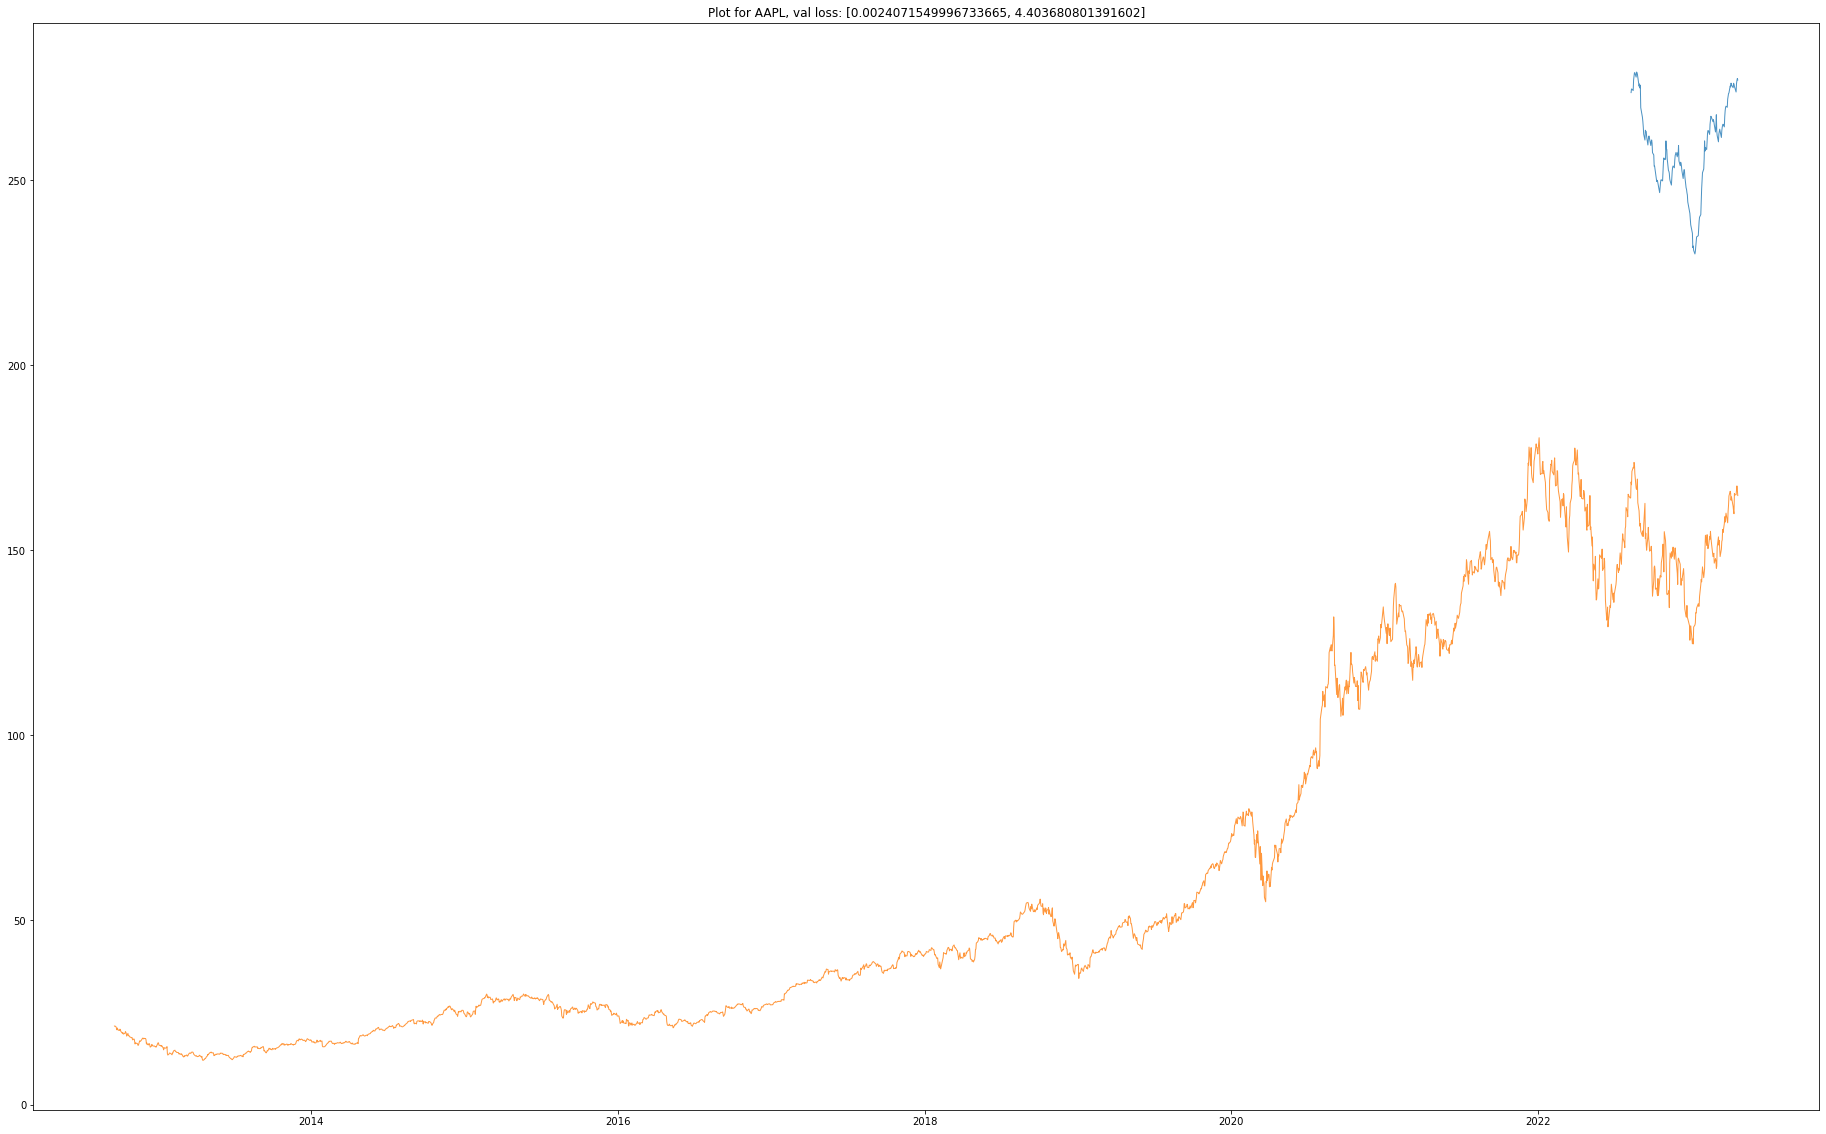

*****Training for MSFT
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0035 - mean_absolute_percentage_error: 52.0310 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 17.5250
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0085 - mean_absolute_percentage_error: 275.3714 - val_loss: 0.0648 - val_mean_absolute_percentage_error: 27.3763
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0041 - mean_absolute_percentage_error: 158.5421 - val_loss: 0.0630 - val_mean_absolute_percentage_error: 27.0183
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0021 - mean_absolute_percentage_error: 61.0220 - val_loss: 0.0353 - val_mean_absolute_percentage_error: 19.5342
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0020 - mean_absolute_percentage_error: 72.4272 - val_loss: 0.0304 - val_mean_absolute_percentage_error: 17.9955
Epoch 6/50
114/114 [==========

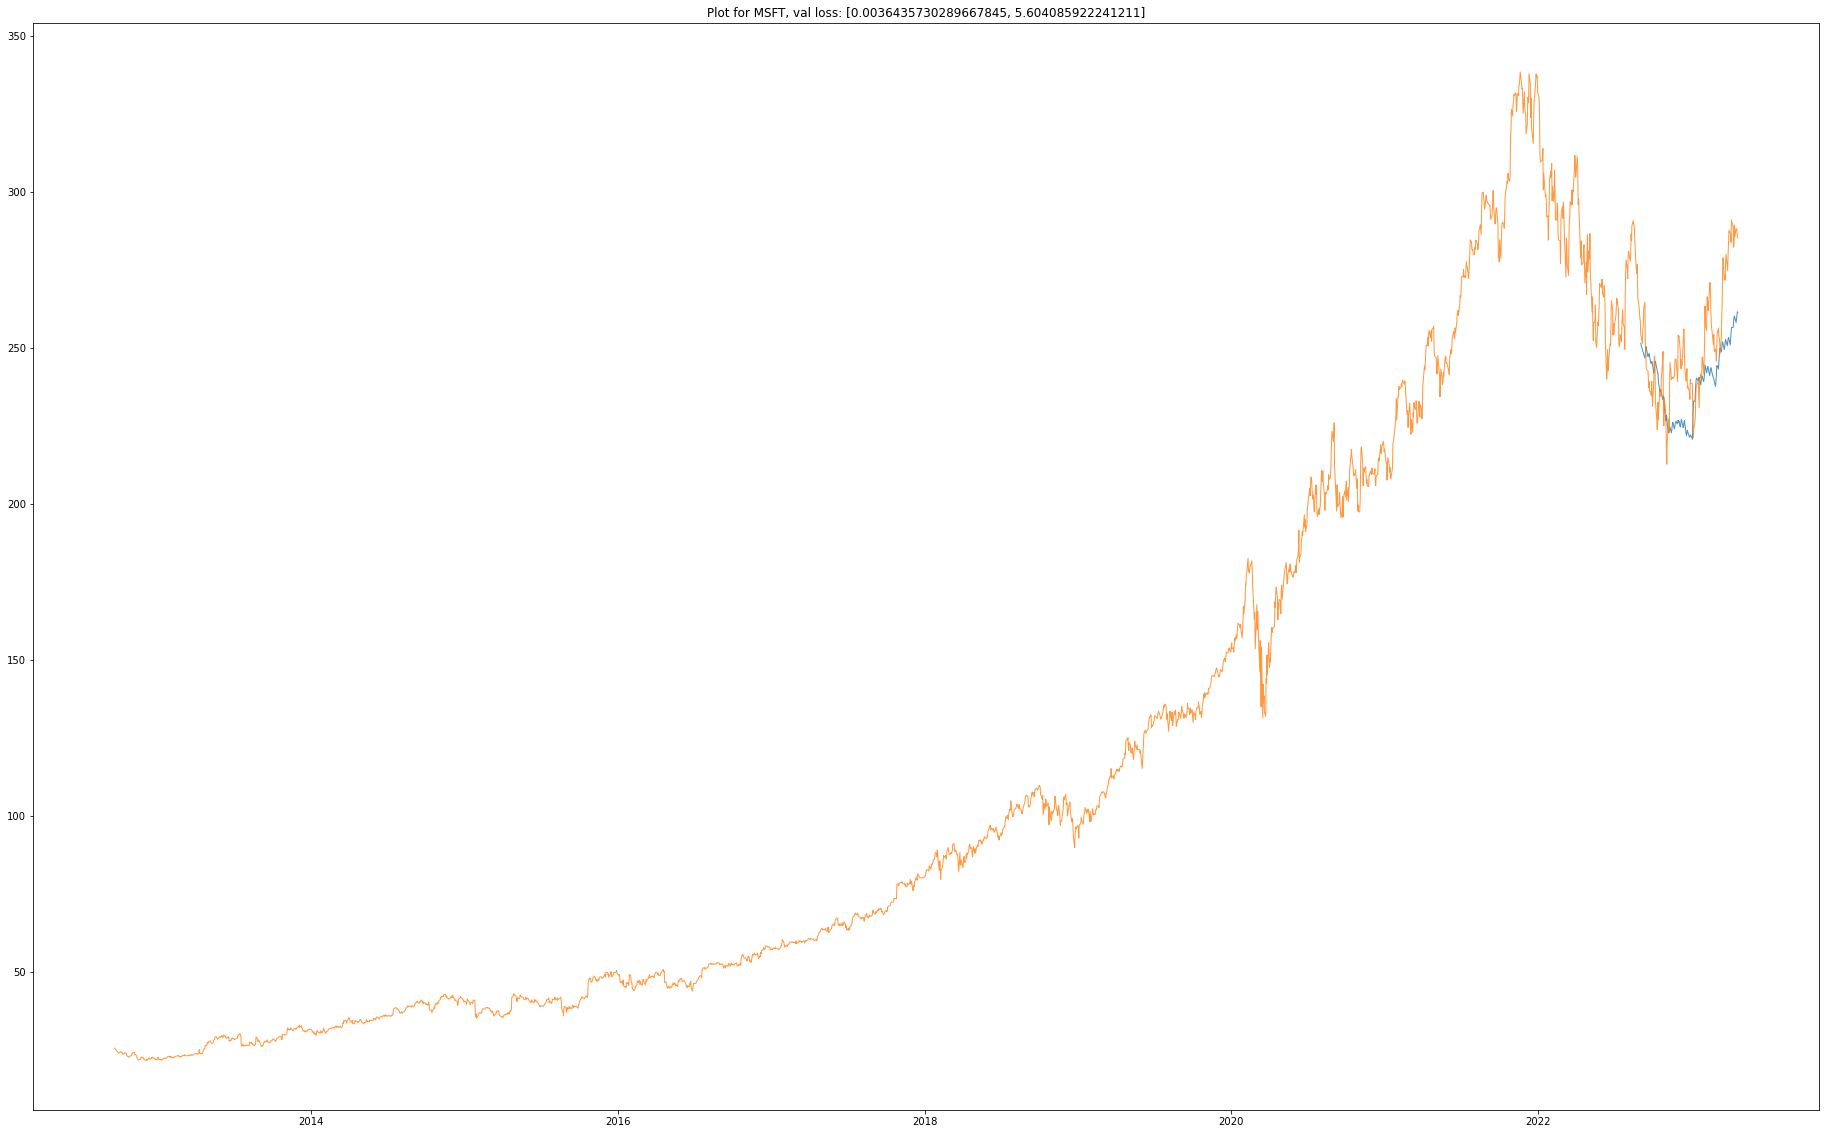

*****Training for AMZN
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0091 - mean_absolute_percentage_error: 62.6649 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 11.7990
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0235 - mean_absolute_percentage_error: 249.4394 - val_loss: 0.0076 - val_mean_absolute_percentage_error: 8.0824
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0310 - mean_absolute_percentage_error: 295.4196 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 7.7321
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0096 - mean_absolute_percentage_error: 151.0966 - val_loss: 0.0116 - val_mean_absolute_percentage_error: 10.5369
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0044 - mean_absolute_percentage_error: 38.8200 - val_loss: 0.0048 - val_mean_absolute_percentage_error: 6.2719
Epoch 6/50
114/114 [============

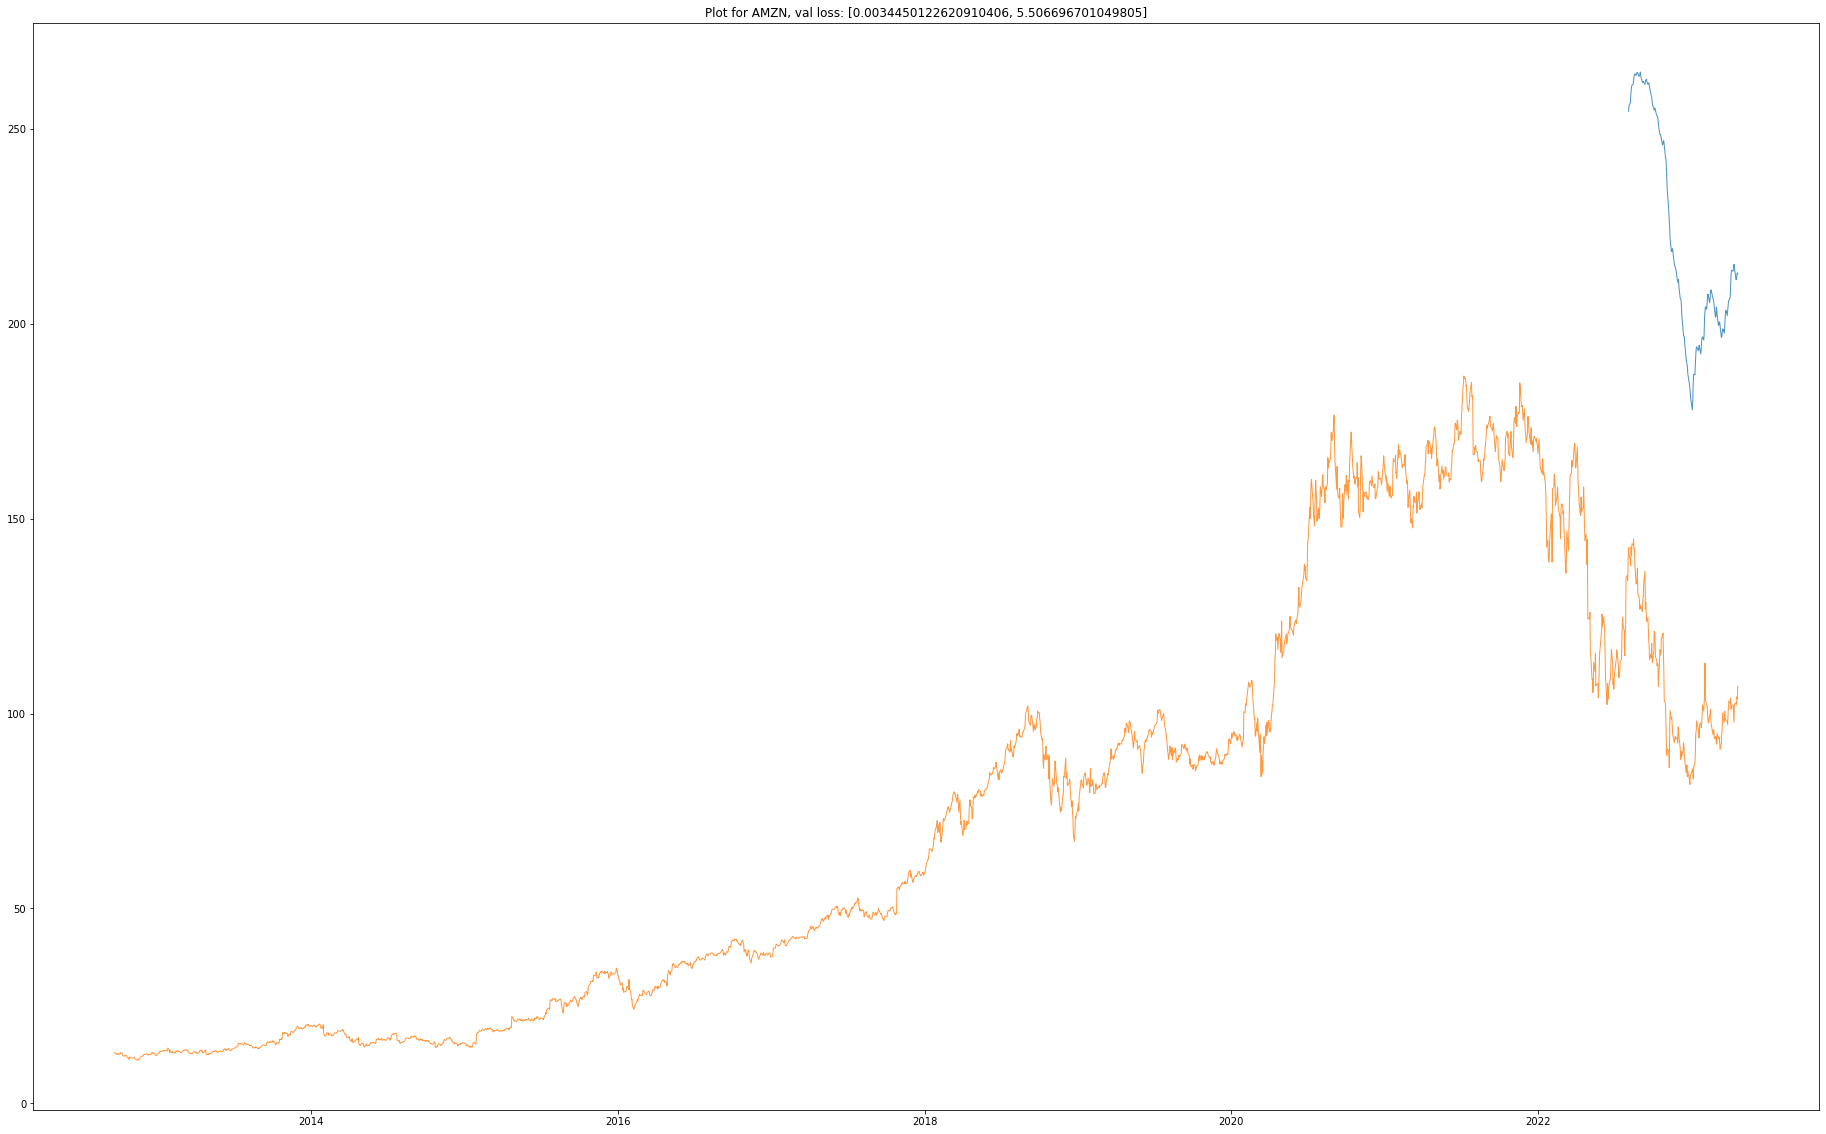

*****Training for NVDA
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0021 - mean_absolute_percentage_error: 331.1197 - val_loss: 0.1228 - val_mean_absolute_percentage_error: 43.4894
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0056 - mean_absolute_percentage_error: 1011.8405 - val_loss: 0.0902 - val_mean_absolute_percentage_error: 35.8676
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 866.4349 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 34.2288
Epoch 4/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0019 - mean_absolute_percentage_error: 502.5094 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 34.7509
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0019 - mean_absolute_percentage_error: 557.8491 - val_loss: 0.0791 - val_mean_absolute_percentage_error: 33.2955
Epoch 6/50
114/114 [======

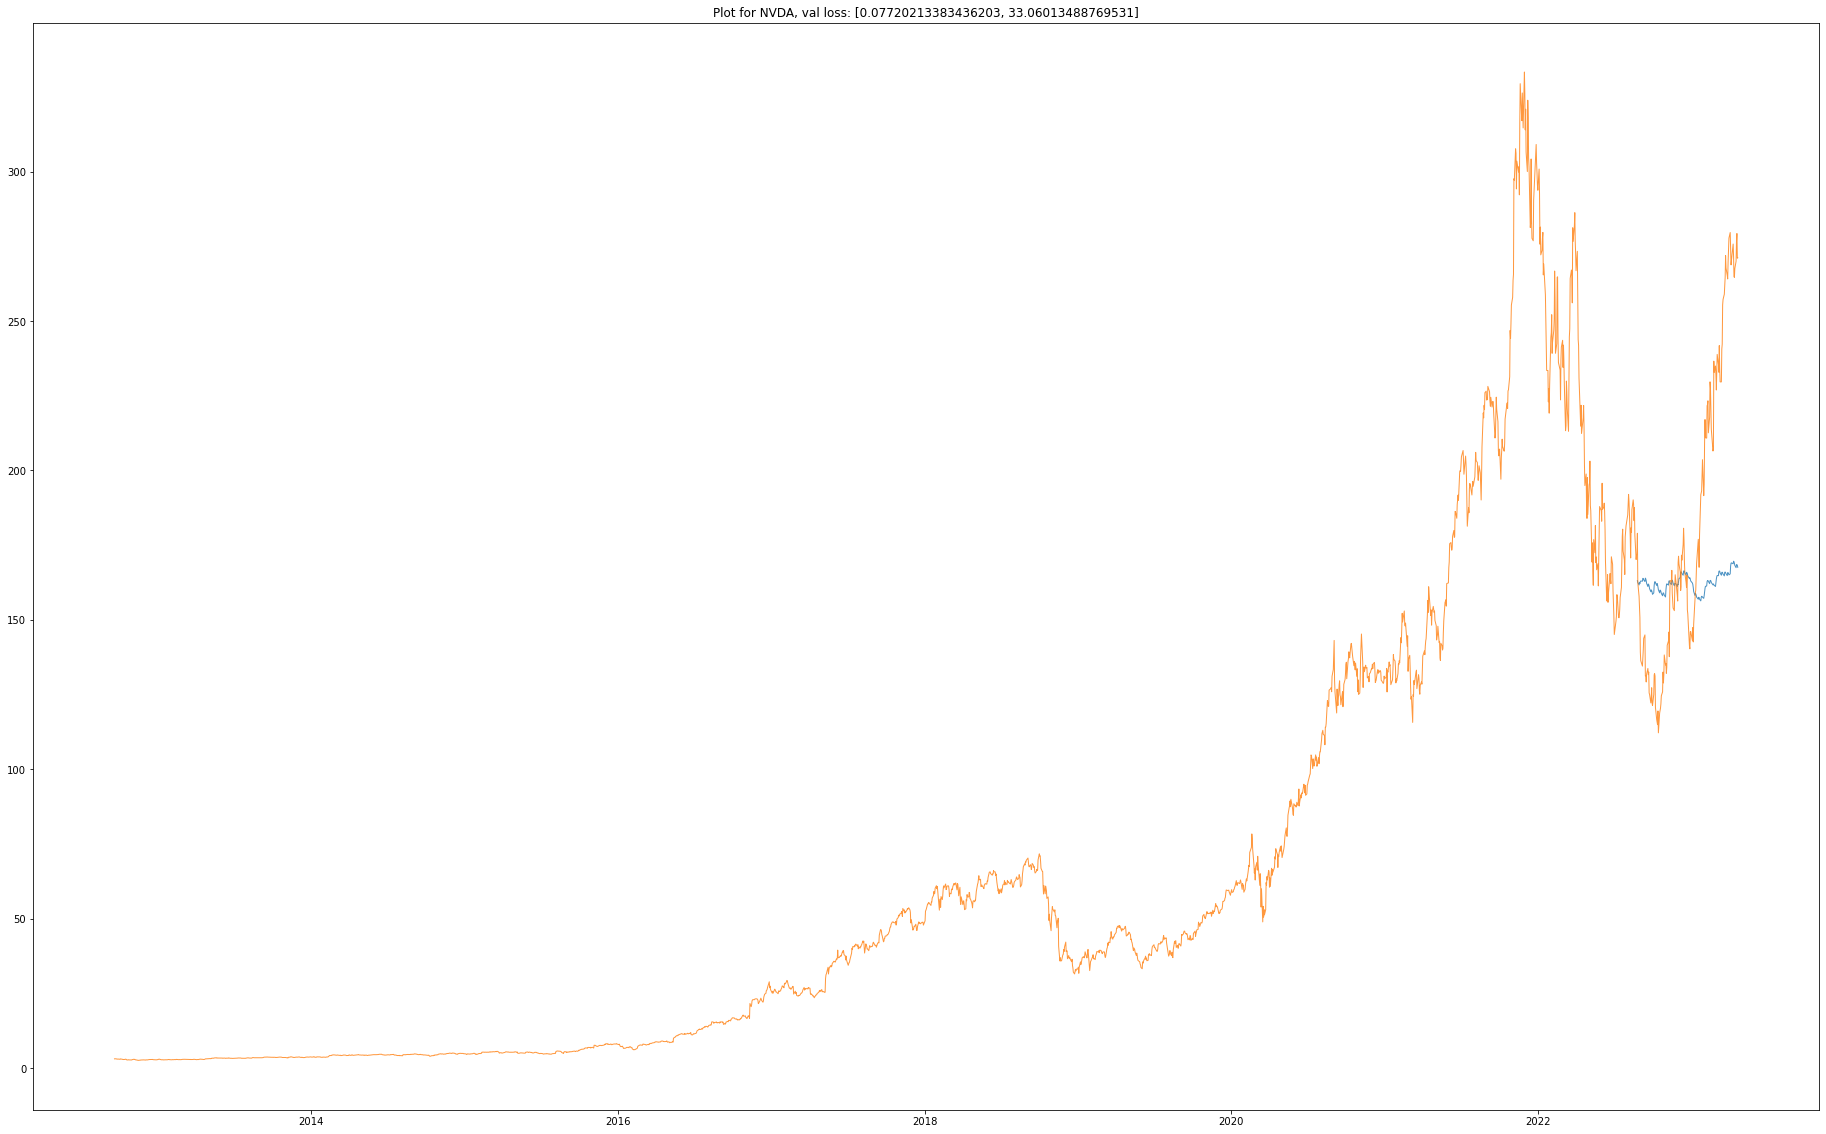

*****Training for GOOGL
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0044 - mean_absolute_percentage_error: 34.4781 - val_loss: 0.0745 - val_mean_absolute_percentage_error: 29.0124
Epoch 2/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0089 - mean_absolute_percentage_error: 77.1041 - val_loss: 0.0490 - val_mean_absolute_percentage_error: 23.2261
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0081 - mean_absolute_percentage_error: 75.0850 - val_loss: 0.0432 - val_mean_absolute_percentage_error: 21.6466
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0046 - mean_absolute_percentage_error: 54.1051 - val_loss: 0.0340 - val_mean_absolute_percentage_error: 19.0667
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0019 - mean_absolute_percentage_error: 23.0293 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 14.6394
Epoch 6/50
114/114 [===========

114/114 [==============================] - 3s 25ms/step - loss: 3.4222e-04 - mean_absolute_percentage_error: 9.8789 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 14.0295
Epoch 44/50
114/114 [==============================] - 3s 25ms/step - loss: 3.1970e-04 - mean_absolute_percentage_error: 9.7956 - val_loss: 0.0213 - val_mean_absolute_percentage_error: 15.3212
Epoch 45/50
114/114 [==============================] - 3s 25ms/step - loss: 3.9769e-04 - mean_absolute_percentage_error: 12.6218 - val_loss: 0.0106 - val_mean_absolute_percentage_error: 10.5201
Epoch 46/50
114/114 [==============================] - 3s 25ms/step - loss: 3.2163e-04 - mean_absolute_percentage_error: 10.7106 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 11.0837
Val loss for GOOGL: [0.011682921089231968, 11.083718299865723]


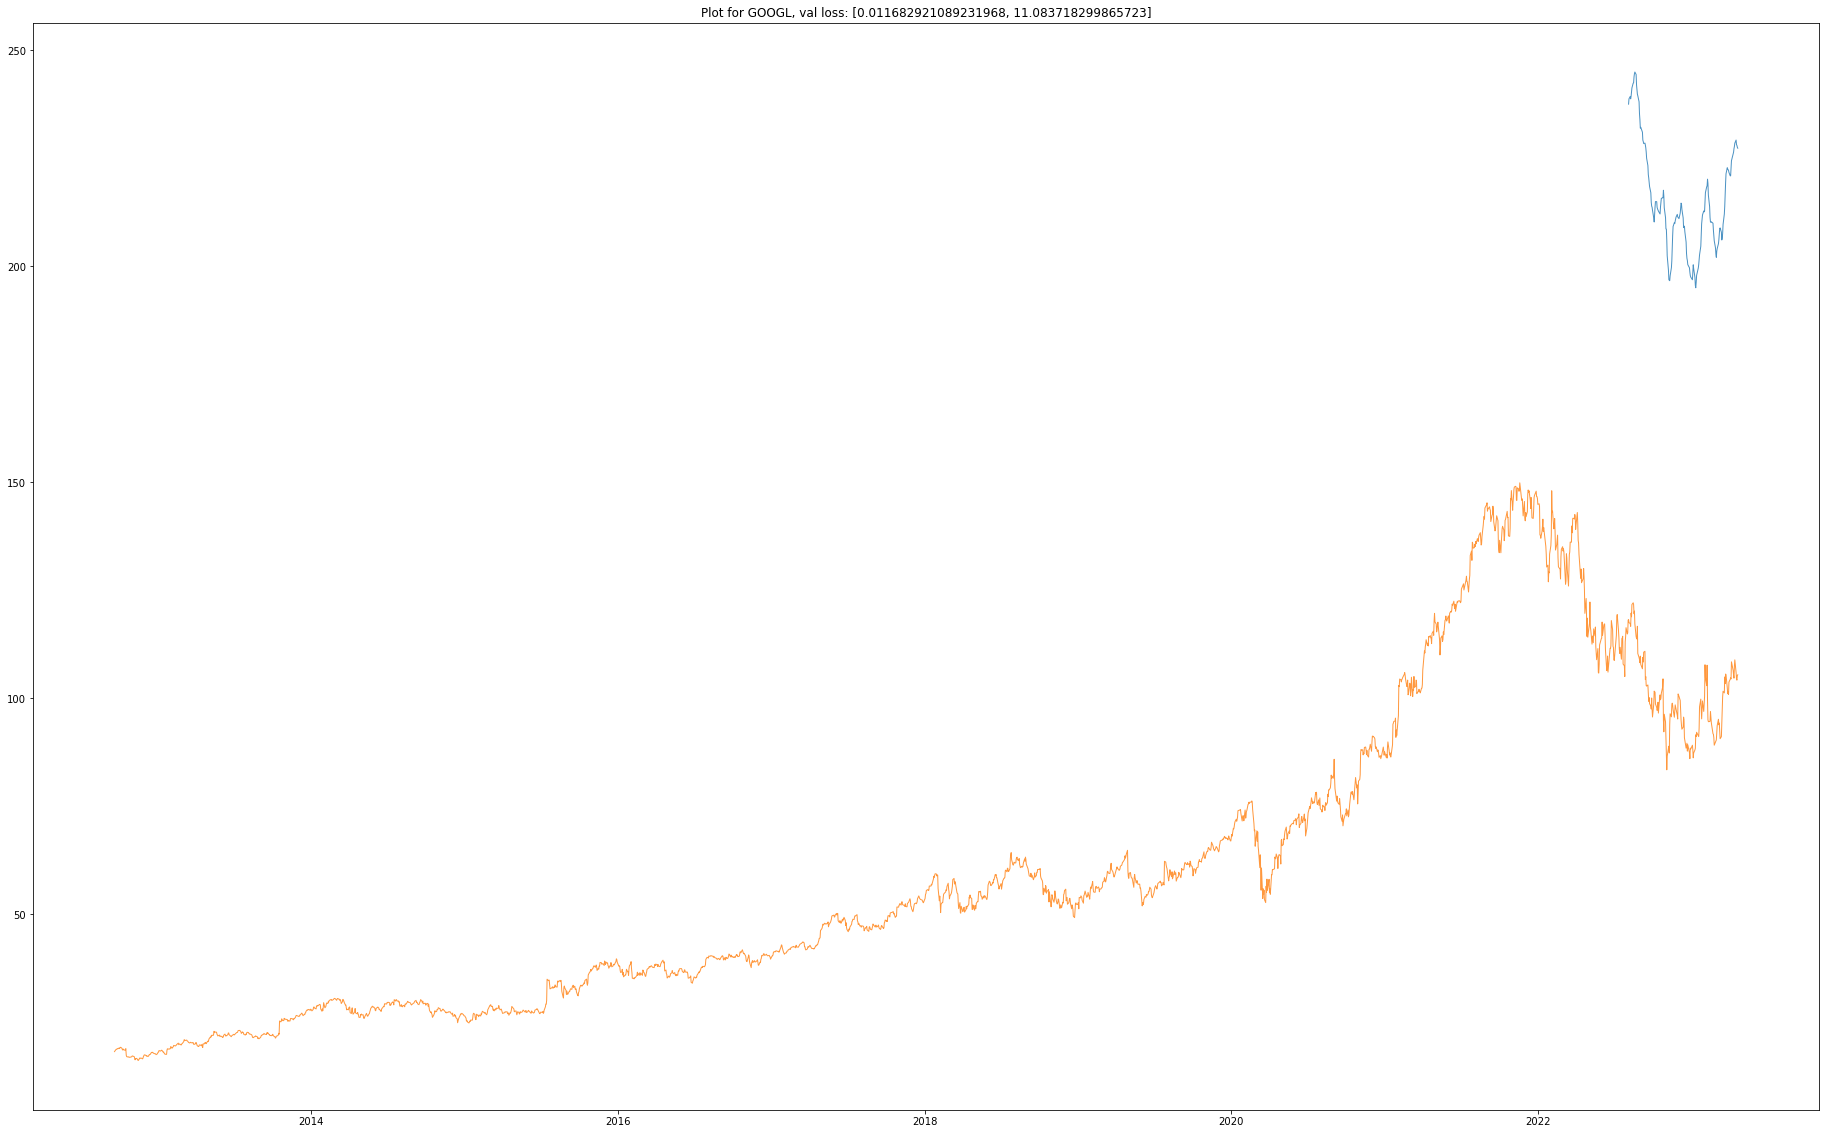

*****Training for GOOG
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0054 - mean_absolute_percentage_error: 41.4826 - val_loss: 0.0546 - val_mean_absolute_percentage_error: 24.7699
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0124 - mean_absolute_percentage_error: 96.1900 - val_loss: 0.0765 - val_mean_absolute_percentage_error: 29.5190
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0081 - mean_absolute_percentage_error: 73.7126 - val_loss: 0.0892 - val_mean_absolute_percentage_error: 31.8510
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0042 - mean_absolute_percentage_error: 49.0640 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 17.1461
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0018 - mean_absolute_percentage_error: 18.9421 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 16.0697
Epoch 6/50
114/114 [============

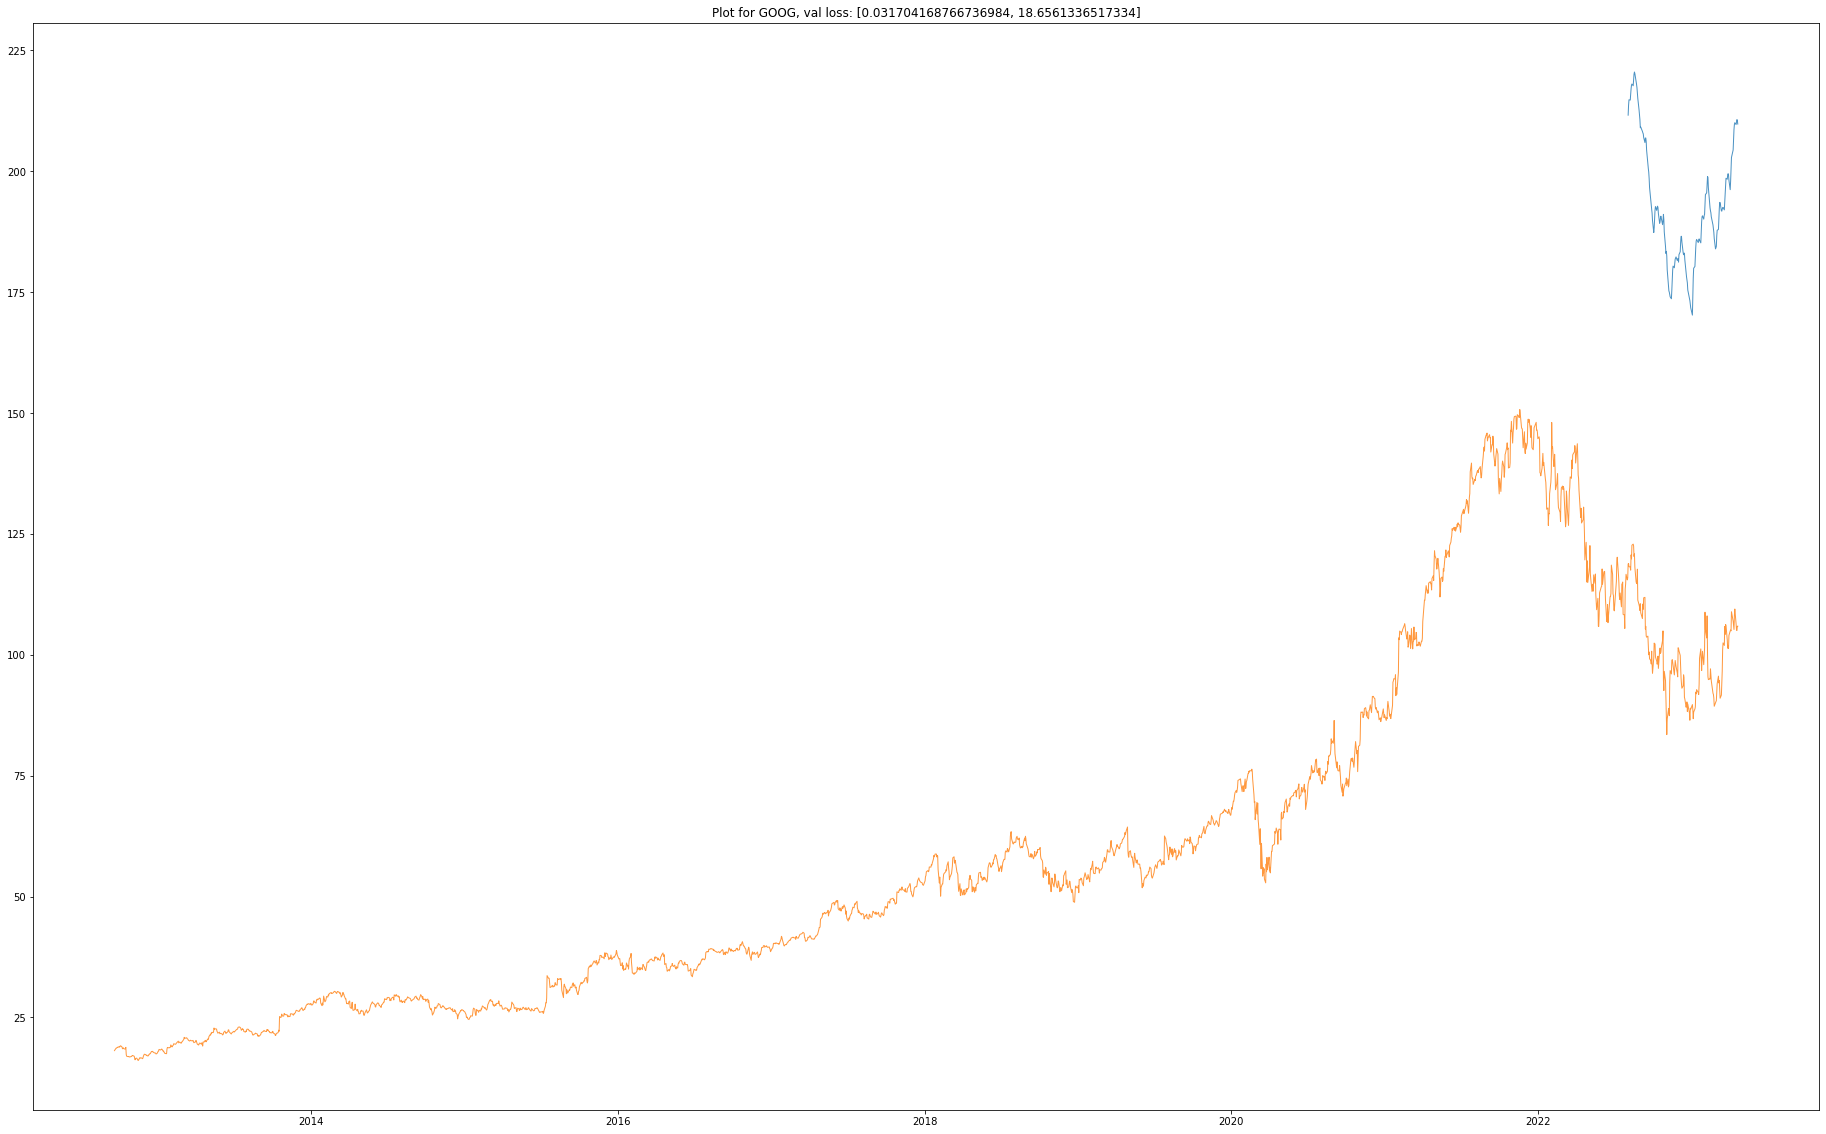

*****Training for TSLA
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0033 - mean_absolute_percentage_error: 142.9151 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 15.0990
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0110 - mean_absolute_percentage_error: 607.5588 - val_loss: 0.0667 - val_mean_absolute_percentage_error: 26.7465
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0052 - mean_absolute_percentage_error: 426.7175 - val_loss: 0.0272 - val_mean_absolute_percentage_error: 15.7958
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0023 - mean_absolute_percentage_error: 97.2097 - val_loss: 0.0376 - val_mean_absolute_percentage_error: 19.4802
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0023 - mean_absolute_percentage_error: 101.6199 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 11.5889
Epoch 6/50
114/114 [========

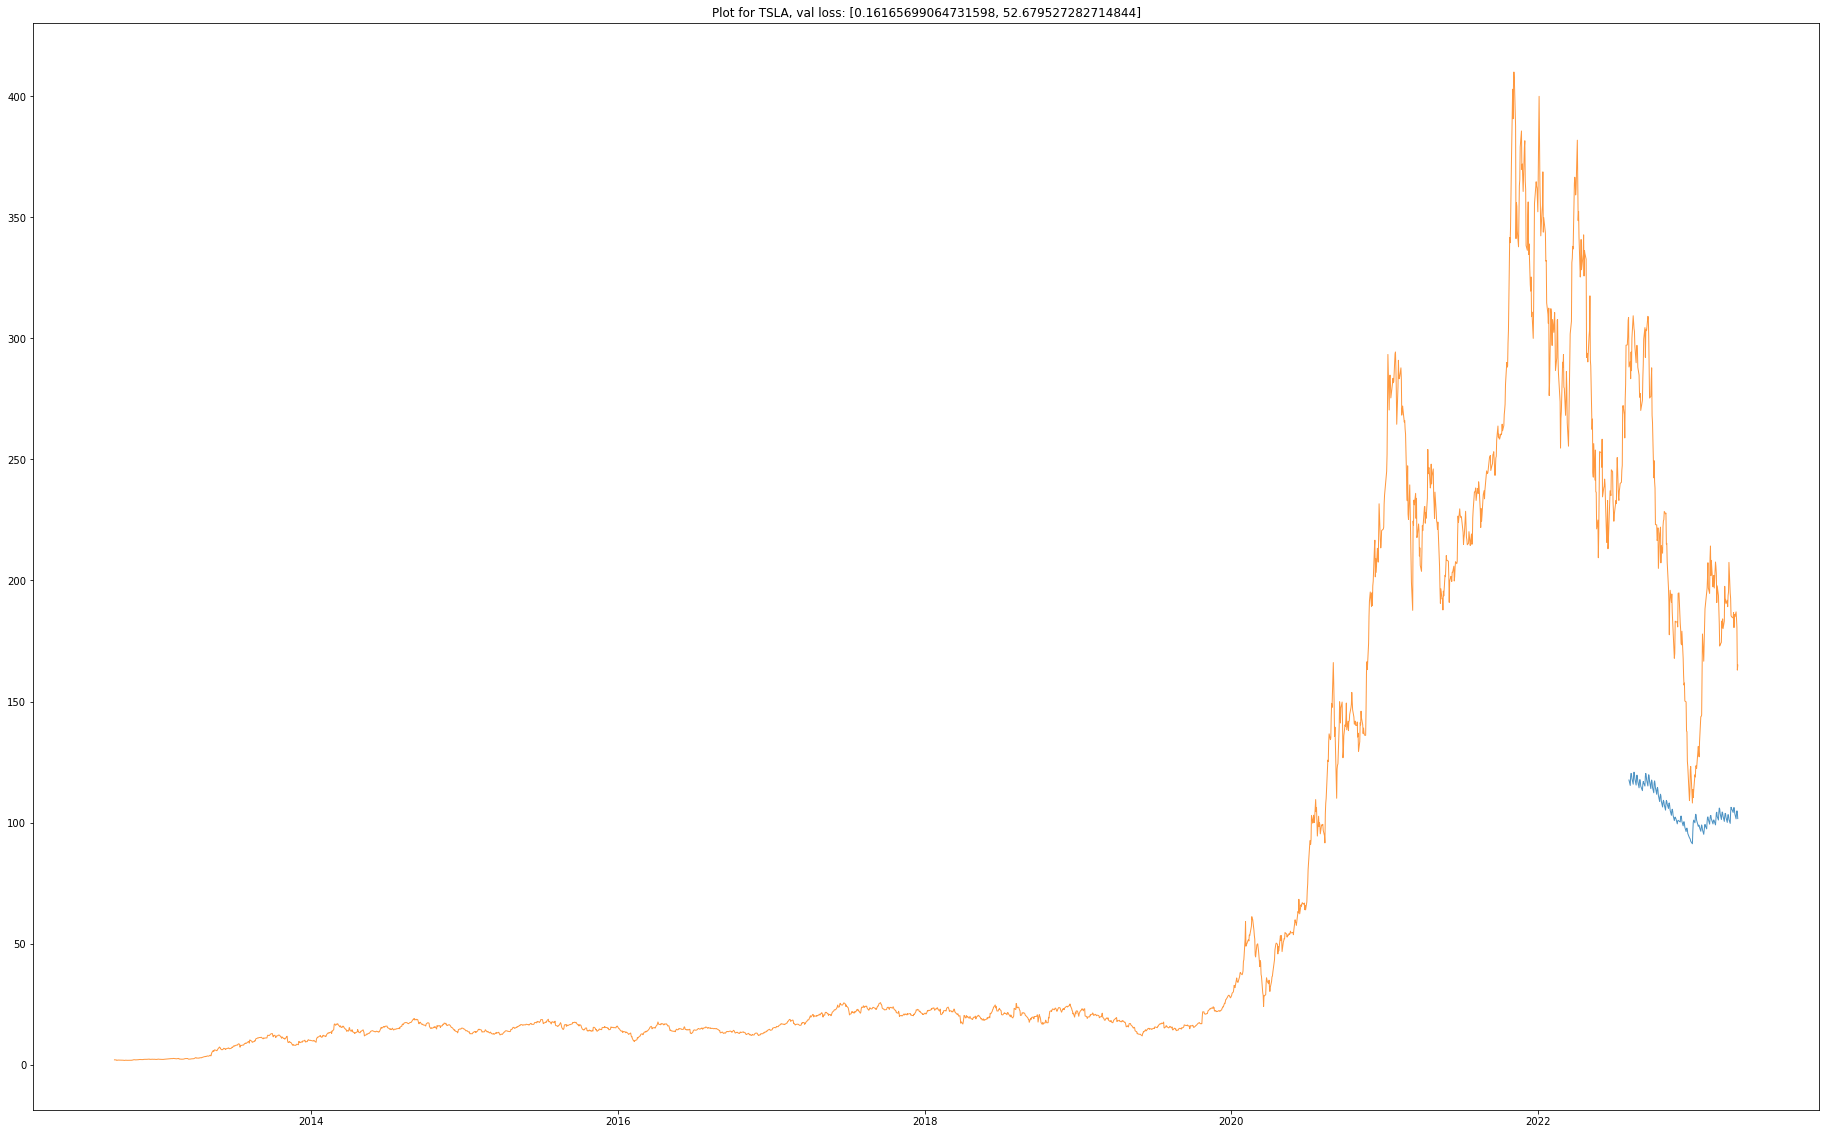

*****Training for META
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0122 - mean_absolute_percentage_error: 38.6522 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 18.8504
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0224 - mean_absolute_percentage_error: 166.7990 - val_loss: 0.0275 - val_mean_absolute_percentage_error: 20.9380
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0131 - mean_absolute_percentage_error: 113.6980 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 20.0547
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0055 - mean_absolute_percentage_error: 39.0685 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 17.7196
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0039 - mean_absolute_percentage_error: 32.6319 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 16.6926
Epoch 6/50
114/114 [==========

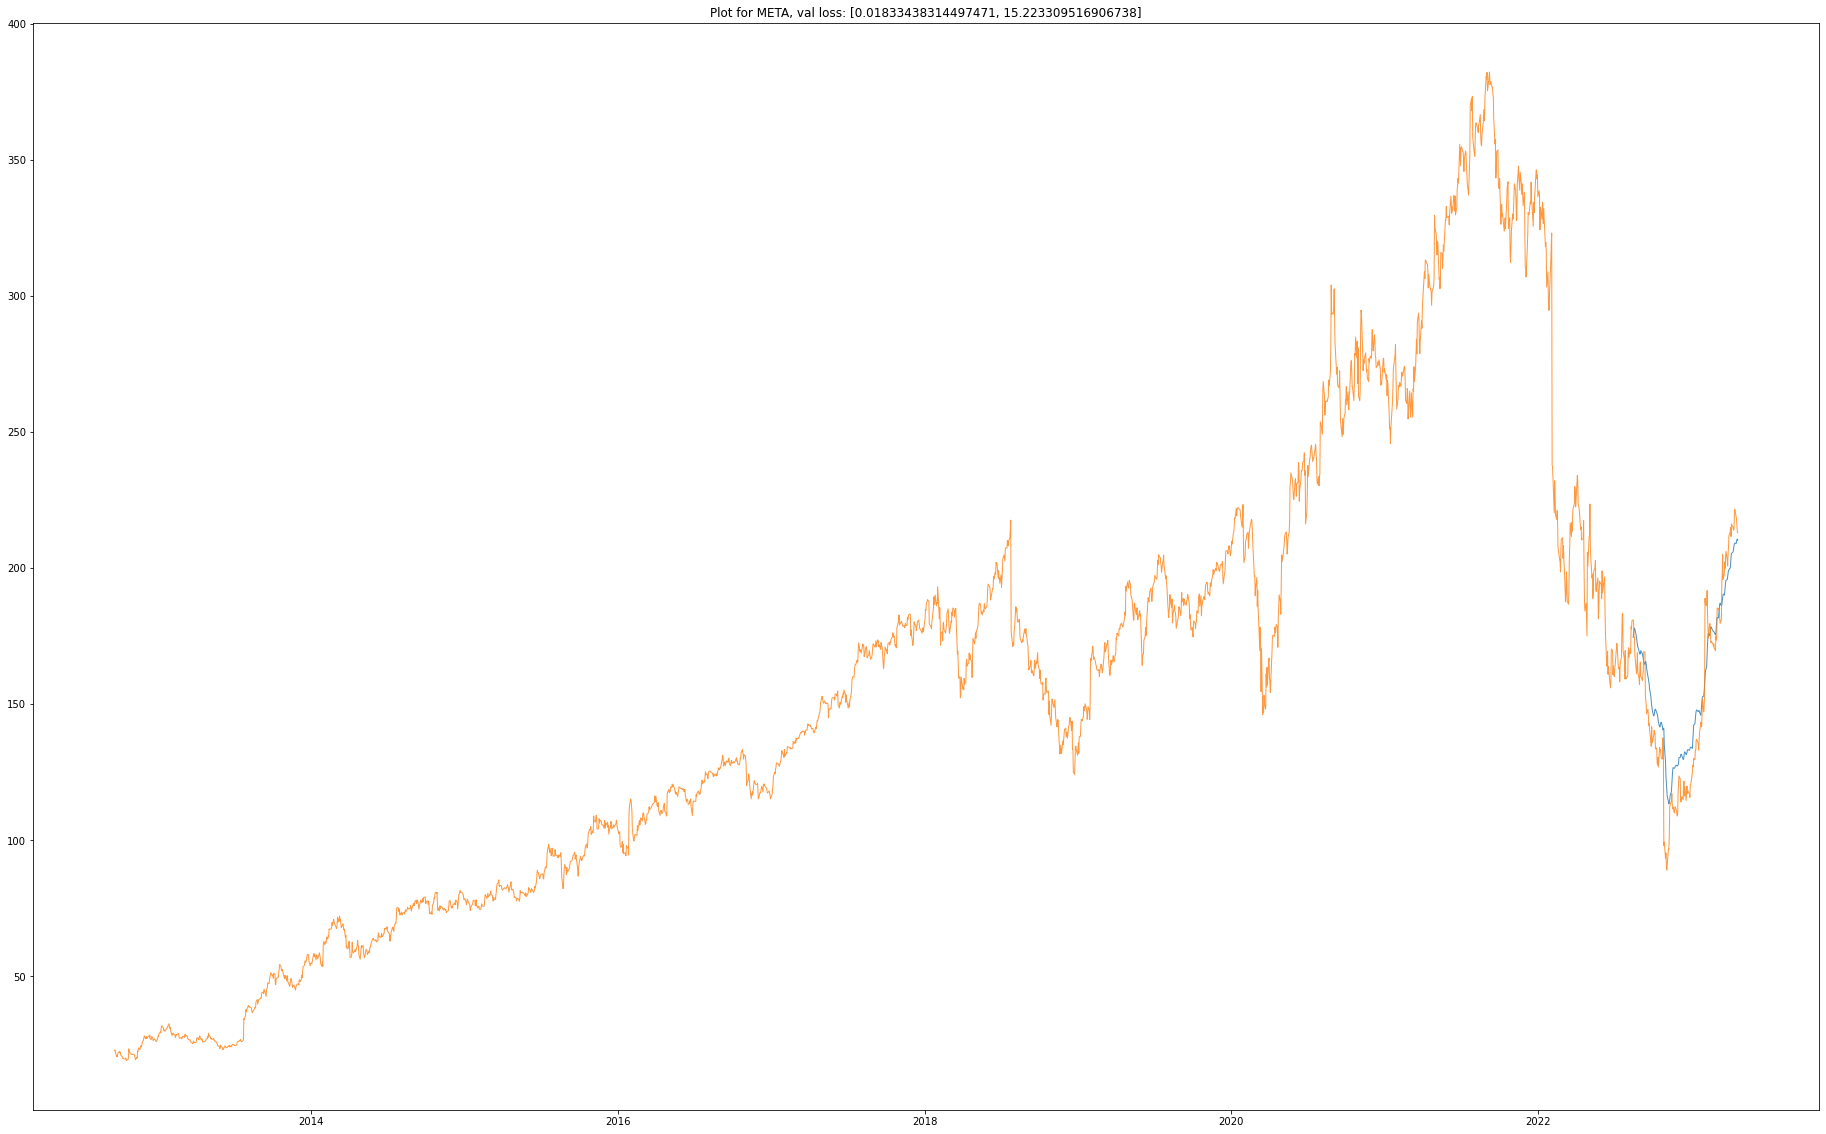

*****Training for UNH
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0047 - mean_absolute_percentage_error: 60.9085 - val_loss: 0.0306 - val_mean_absolute_percentage_error: 19.2465
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0093 - mean_absolute_percentage_error: 194.7421 - val_loss: 0.0337 - val_mean_absolute_percentage_error: 20.3559
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0072 - mean_absolute_percentage_error: 158.3949 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 19.6156
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0042 - mean_absolute_percentage_error: 109.2114 - val_loss: 0.0329 - val_mean_absolute_percentage_error: 20.6208
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0024 - mean_absolute_percentage_error: 47.9138 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 12.8643
Epoch 6/50
114/114 [==========

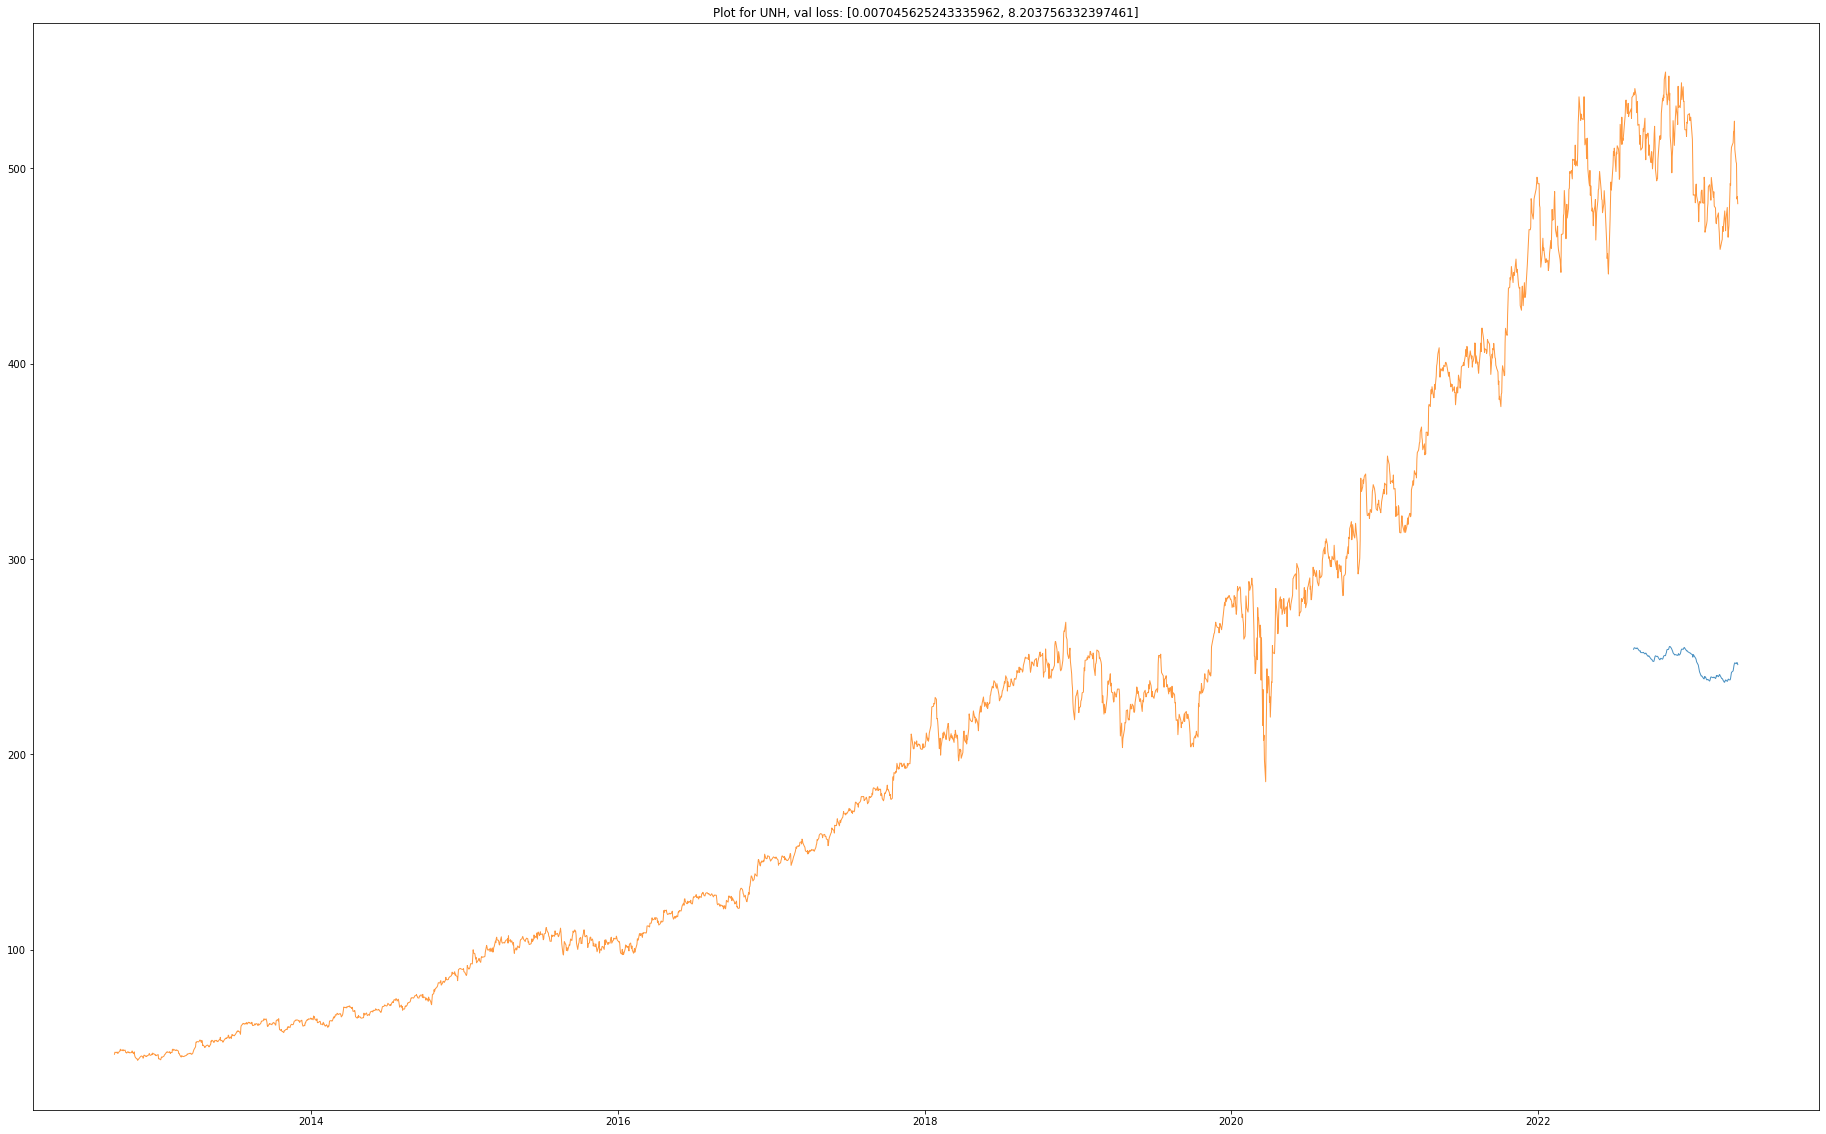

*****Training for XOM
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0220 - mean_absolute_percentage_error: 91932.3906 - val_loss: 0.0503 - val_mean_absolute_percentage_error: 49.5387
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0079 - mean_absolute_percentage_error: 88613.3047 - val_loss: 0.0983 - val_mean_absolute_percentage_error: 75.3117
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0079 - mean_absolute_percentage_error: 108515.3750 - val_loss: 0.0672 - val_mean_absolute_percentage_error: 60.7966
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0055 - mean_absolute_percentage_error: 65566.9609 - val_loss: 0.0406 - val_mean_absolute_percentage_error: 44.9588
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 48332.8906 - val_loss: 0.0515 - val_mean_absolute_percentage_error: 54.2113
Epoch 6/50
114/11

114/114 [==============================] - 3s 25ms/step - loss: 0.0014 - mean_absolute_percentage_error: 15995.7119 - val_loss: 0.0108 - val_mean_absolute_percentage_error: 23.1222
Epoch 44/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 32440.6914 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 18.6126
Epoch 45/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 24592.6484 - val_loss: 0.0067 - val_mean_absolute_percentage_error: 13.8515
Epoch 46/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 29724.8281 - val_loss: 0.0071 - val_mean_absolute_percentage_error: 12.6972
Epoch 47/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 58664.7383 - val_loss: 0.0115 - val_mean_absolute_percentage_error: 21.0483
Epoch 48/50
114/114 [==========================

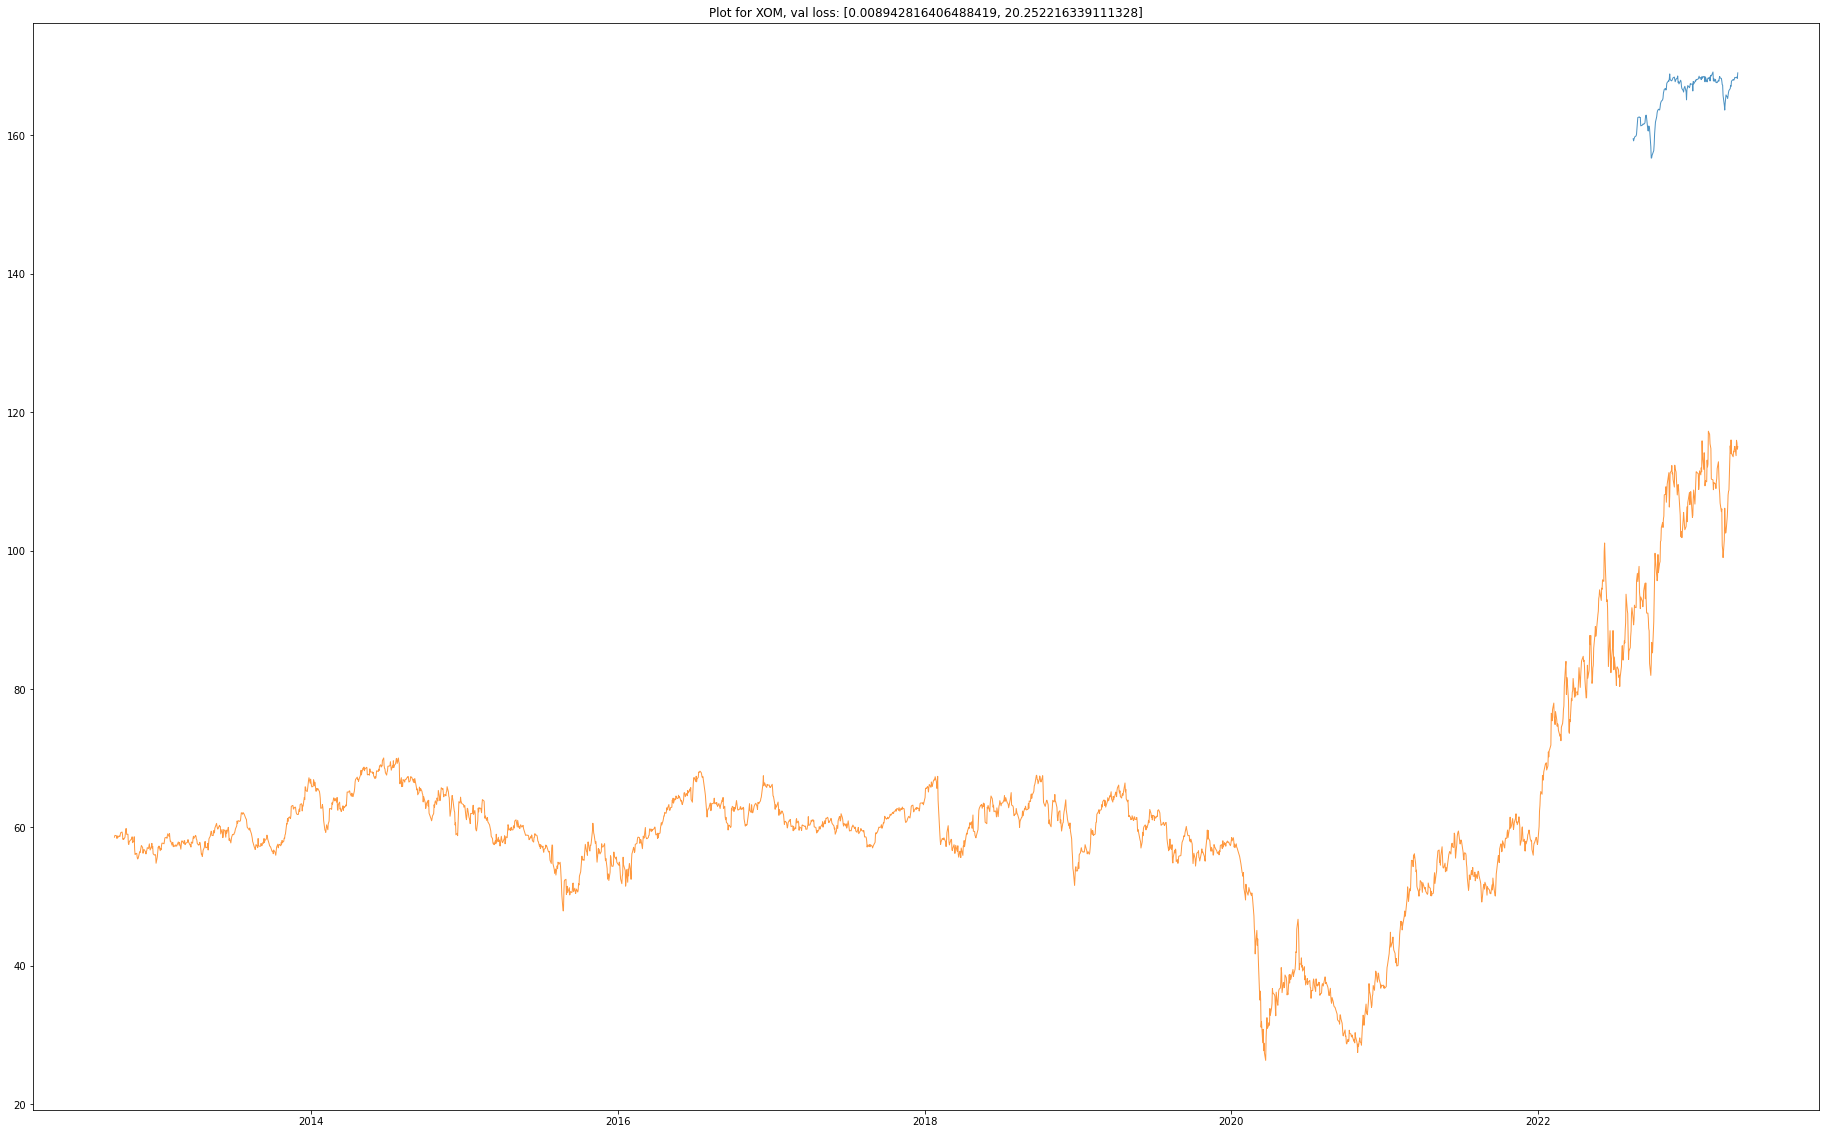

*****Training for JNJ
Epoch 1/50
114/114 [==============================] - 5s 30ms/step - loss: 0.0140 - mean_absolute_percentage_error: 31.5846 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 14.7746
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0236 - mean_absolute_percentage_error: 56.0553 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 9.9288
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0174 - mean_absolute_percentage_error: 47.9228 - val_loss: 0.0117 - val_mean_absolute_percentage_error: 11.0944
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0114 - mean_absolute_percentage_error: 36.7998 - val_loss: 0.0083 - val_mean_absolute_percentage_error: 9.0553
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0071 - mean_absolute_percentage_error: 25.4941 - val_loss: 0.0055 - val_mean_absolute_percentage_error: 7.1086
Epoch 6/50
114/114 [================

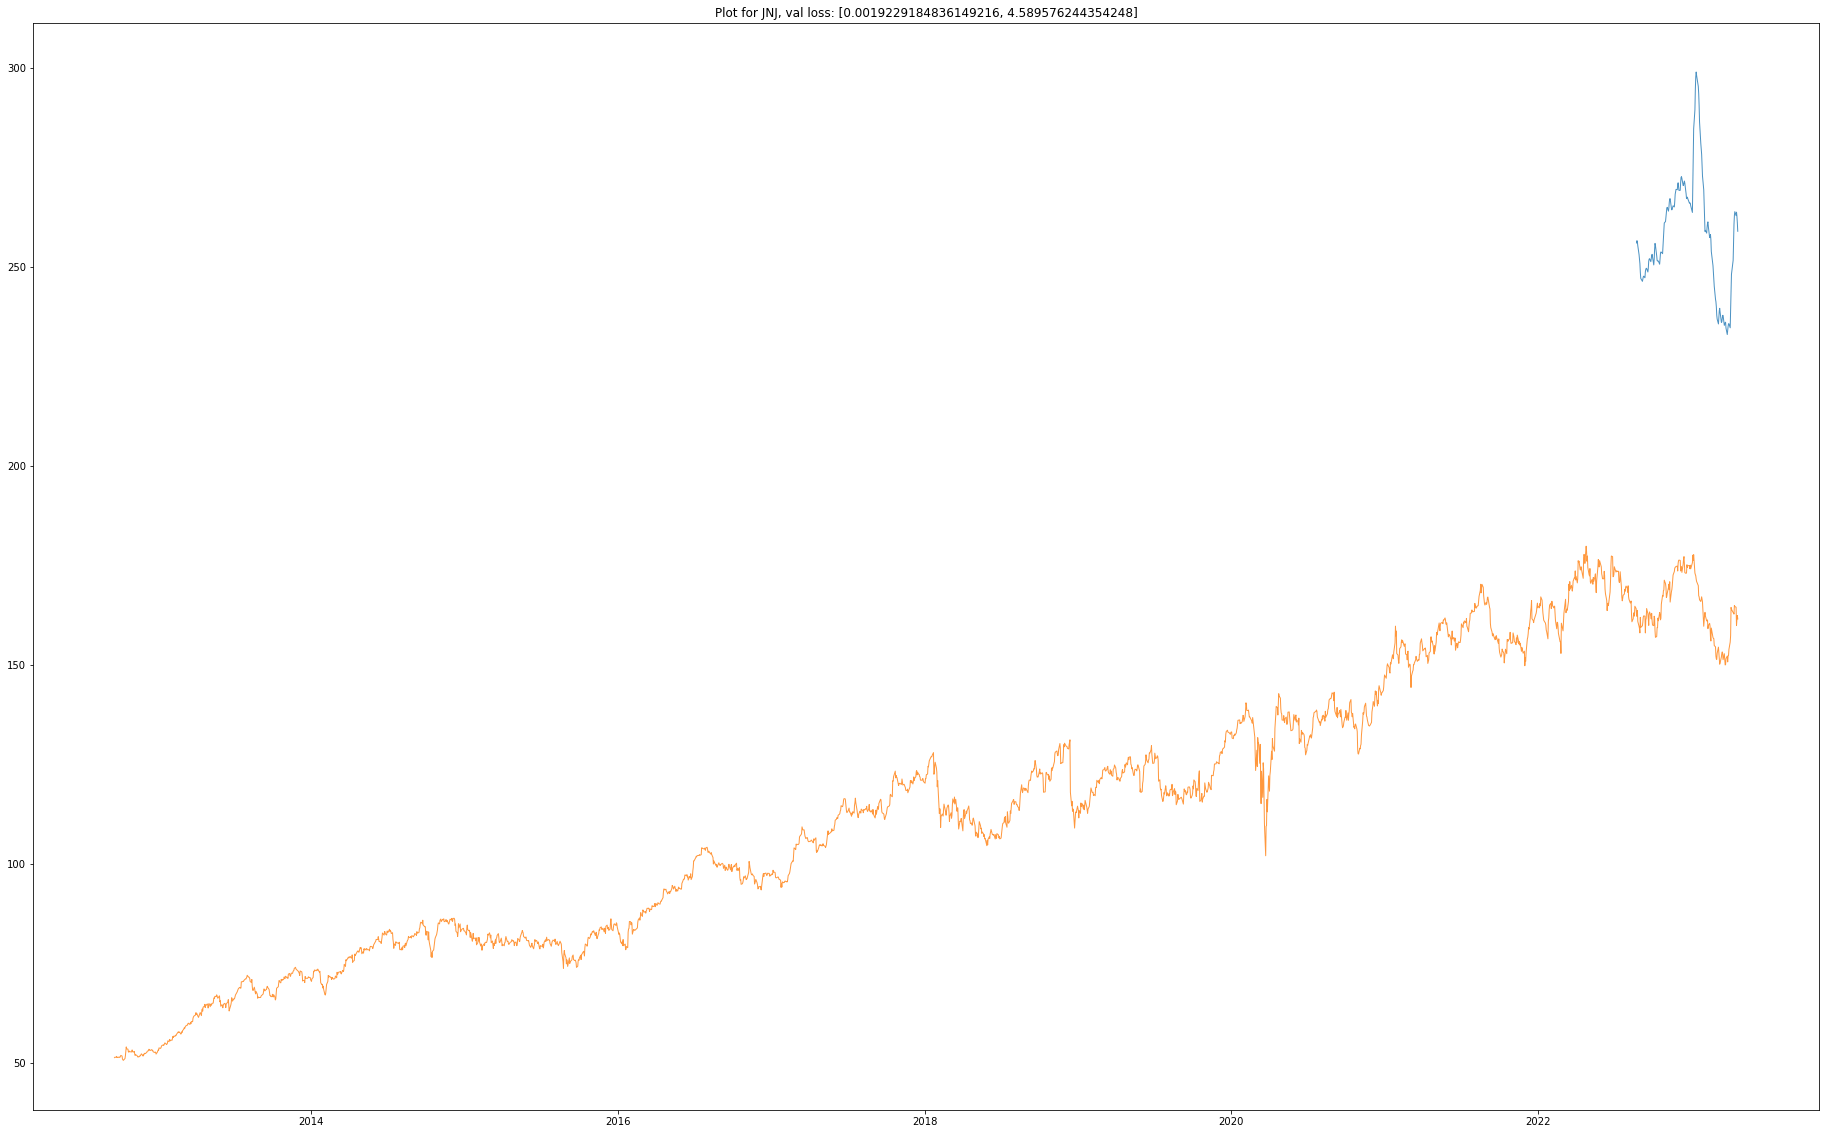

*****Training for JPM
Epoch 1/50
114/114 [==============================] - 6s 31ms/step - loss: 0.0150 - mean_absolute_percentage_error: 34.5364 - val_loss: 0.1143 - val_mean_absolute_percentage_error: 37.2639
Epoch 2/50
114/114 [==============================] - 3s 27ms/step - loss: 0.0189 - mean_absolute_percentage_error: 63.0374 - val_loss: 0.0808 - val_mean_absolute_percentage_error: 31.1296
Epoch 3/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0082 - mean_absolute_percentage_error: 42.2635 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 12.4751
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0048 - mean_absolute_percentage_error: 24.4551 - val_loss: 0.0070 - val_mean_absolute_percentage_error: 8.1398
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0037 - mean_absolute_percentage_error: 16.2303 - val_loss: 0.0036 - val_mean_absolute_percentage_error: 5.7215
Epoch 6/50
114/114 [===============

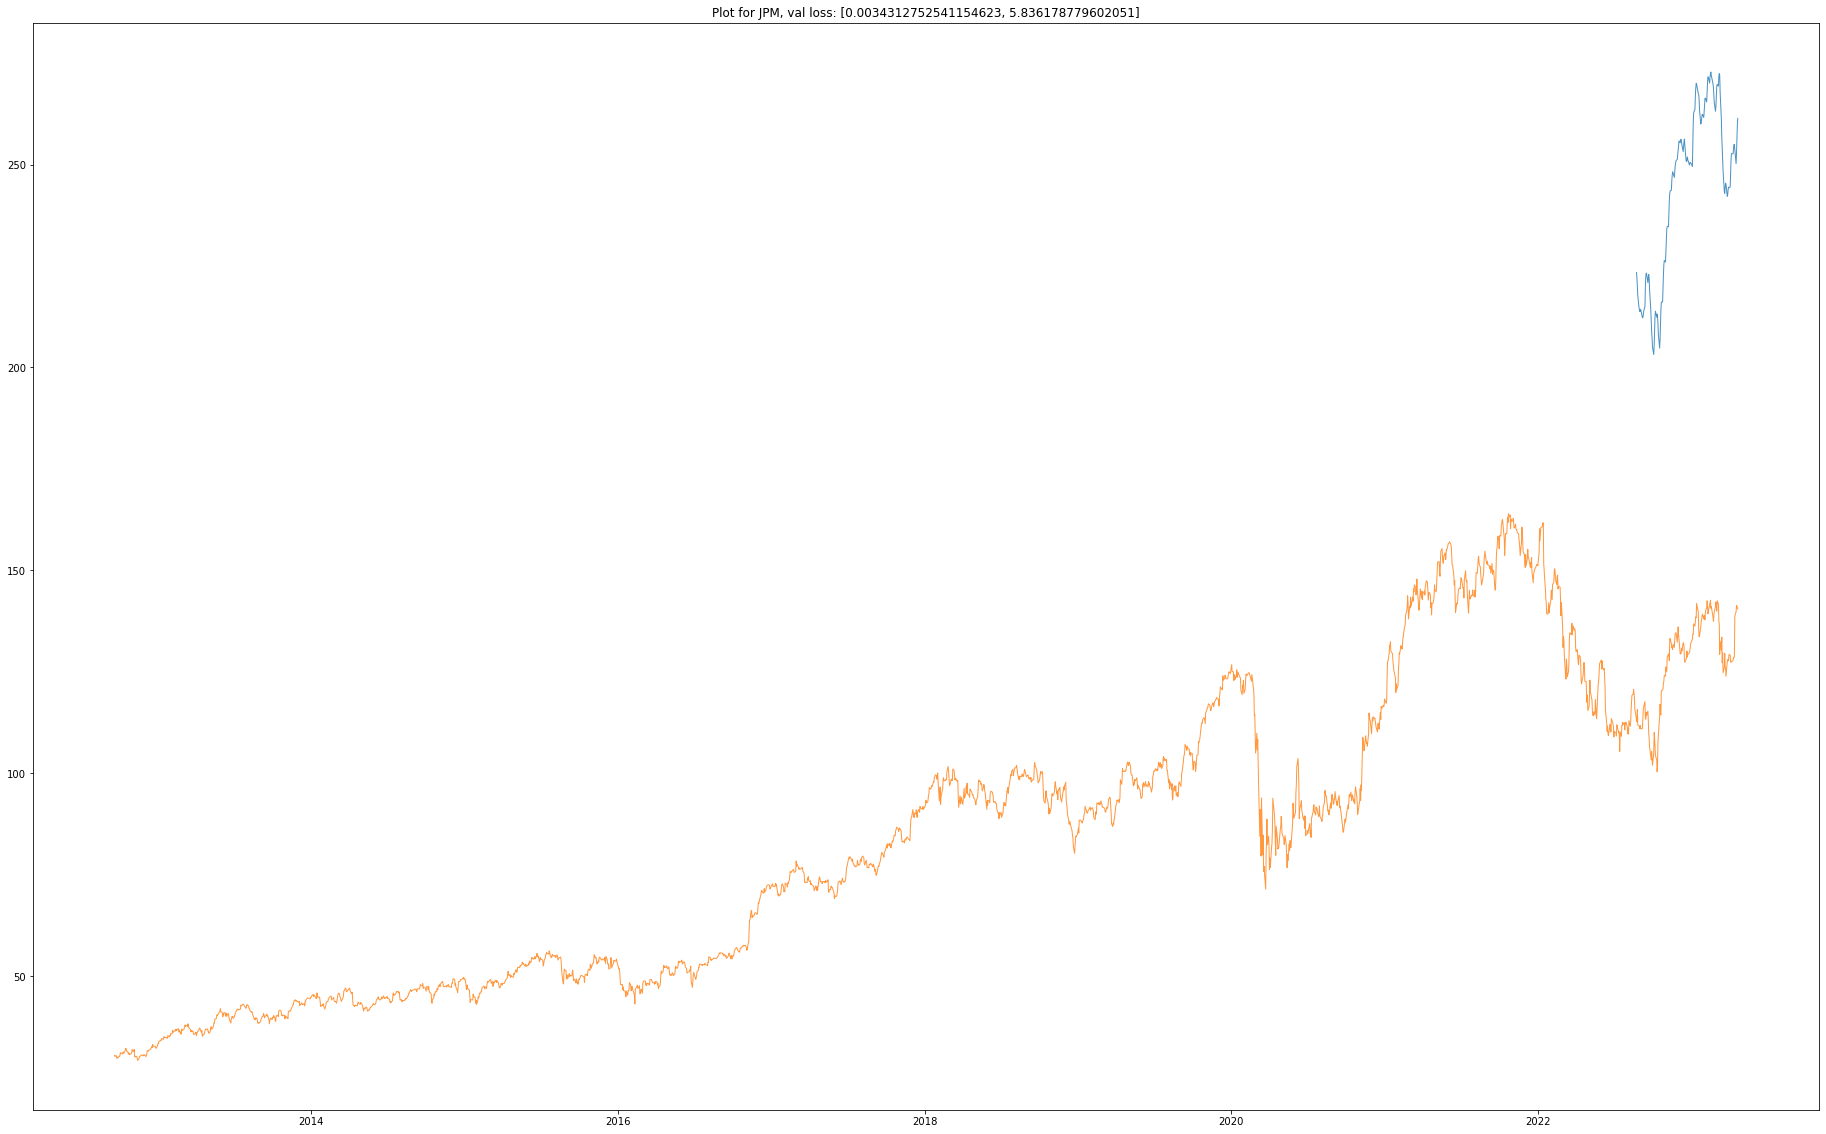

*****Training for V
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0089 - mean_absolute_percentage_error: 35.4372 - val_loss: 0.0093 - val_mean_absolute_percentage_error: 9.6141
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0194 - mean_absolute_percentage_error: 92.0429 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 5.9396
Epoch 3/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0316 - mean_absolute_percentage_error: 126.4890 - val_loss: 0.0032 - val_mean_absolute_percentage_error: 5.3843
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0205 - mean_absolute_percentage_error: 100.8154 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 6.7299
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0077 - mean_absolute_percentage_error: 47.5633 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 4.8325
Epoch 6/50
114/114 [==================

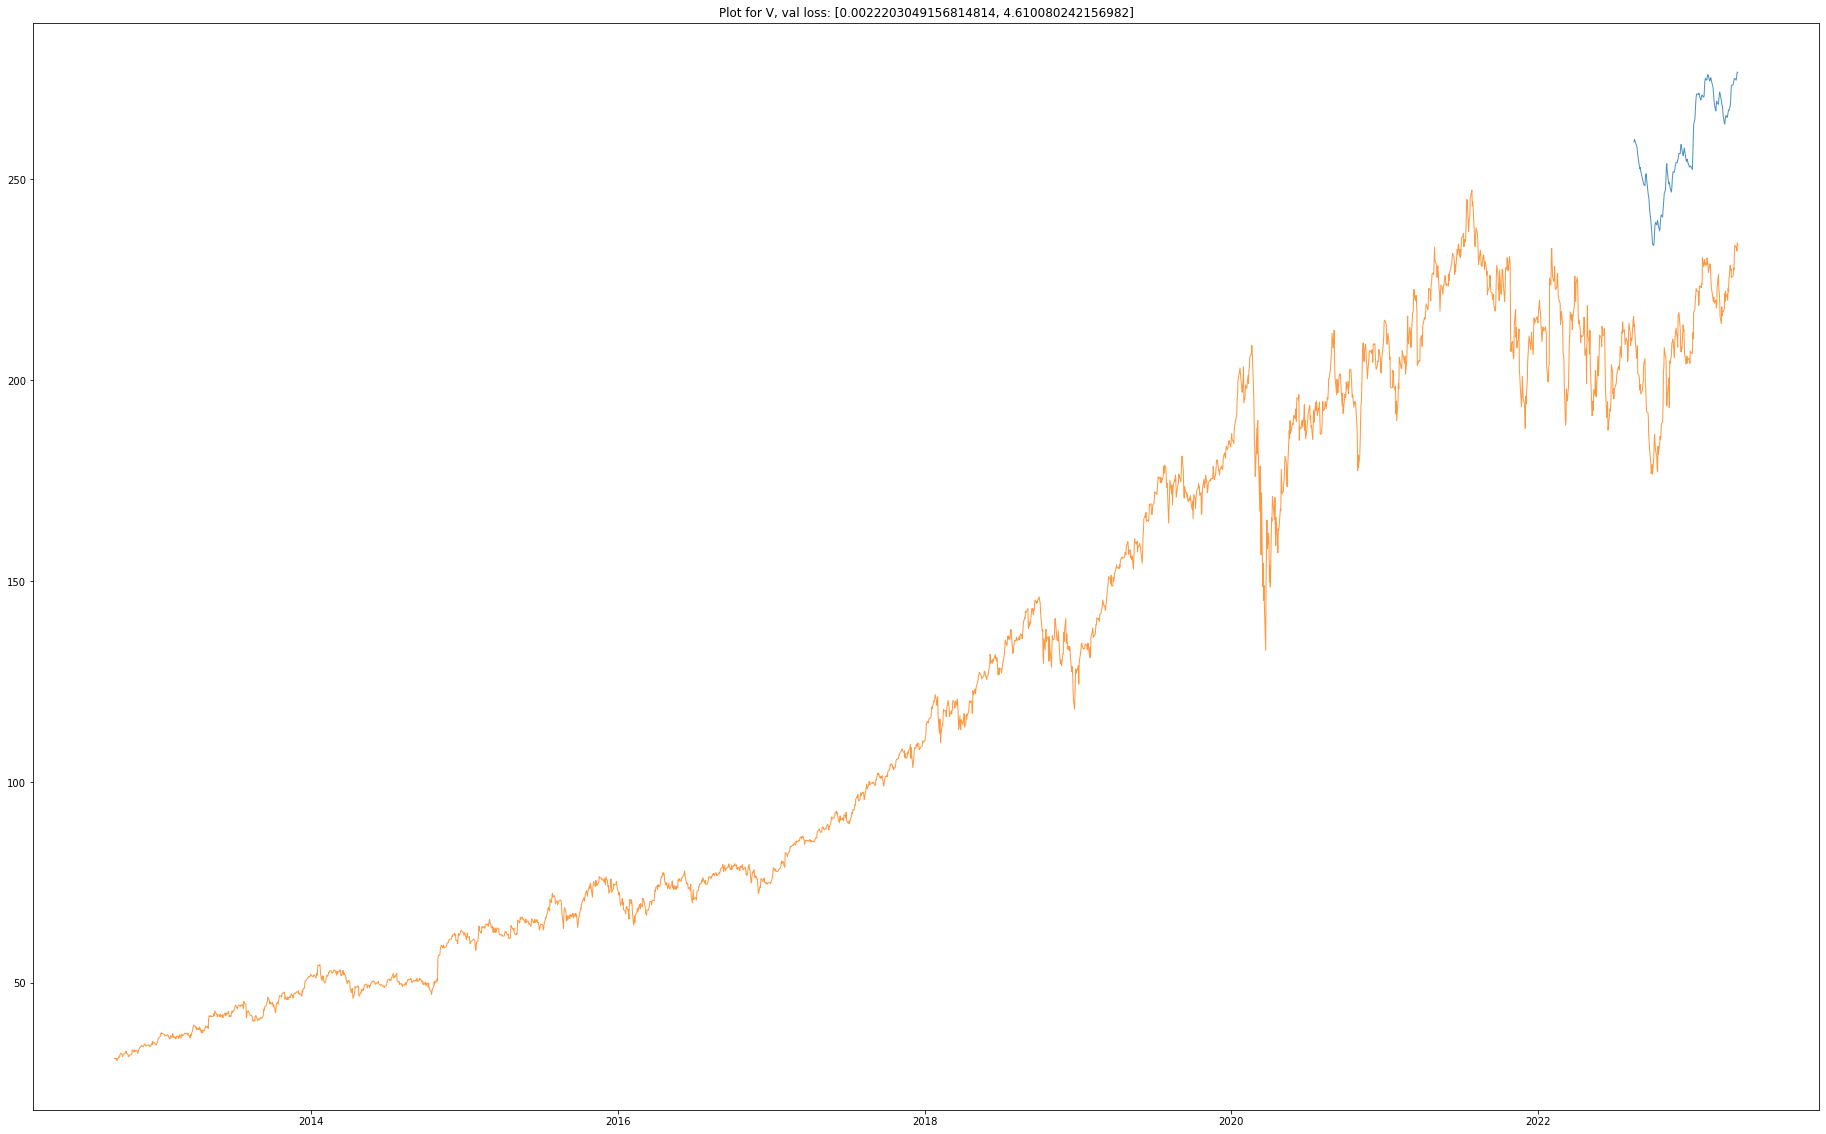

*****Training for LLY
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0029 - mean_absolute_percentage_error: 57.7669 - val_loss: 0.0362 - val_mean_absolute_percentage_error: 29.5200
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0058 - mean_absolute_percentage_error: 116.7336 - val_loss: 0.0367 - val_mean_absolute_percentage_error: 29.6328
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0032 - mean_absolute_percentage_error: 87.8710 - val_loss: 0.0309 - val_mean_absolute_percentage_error: 26.6690
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0016 - mean_absolute_percentage_error: 58.7982 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 22.1715
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 41.4384 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 24.9102
Epoch 6/50
114/114 [============

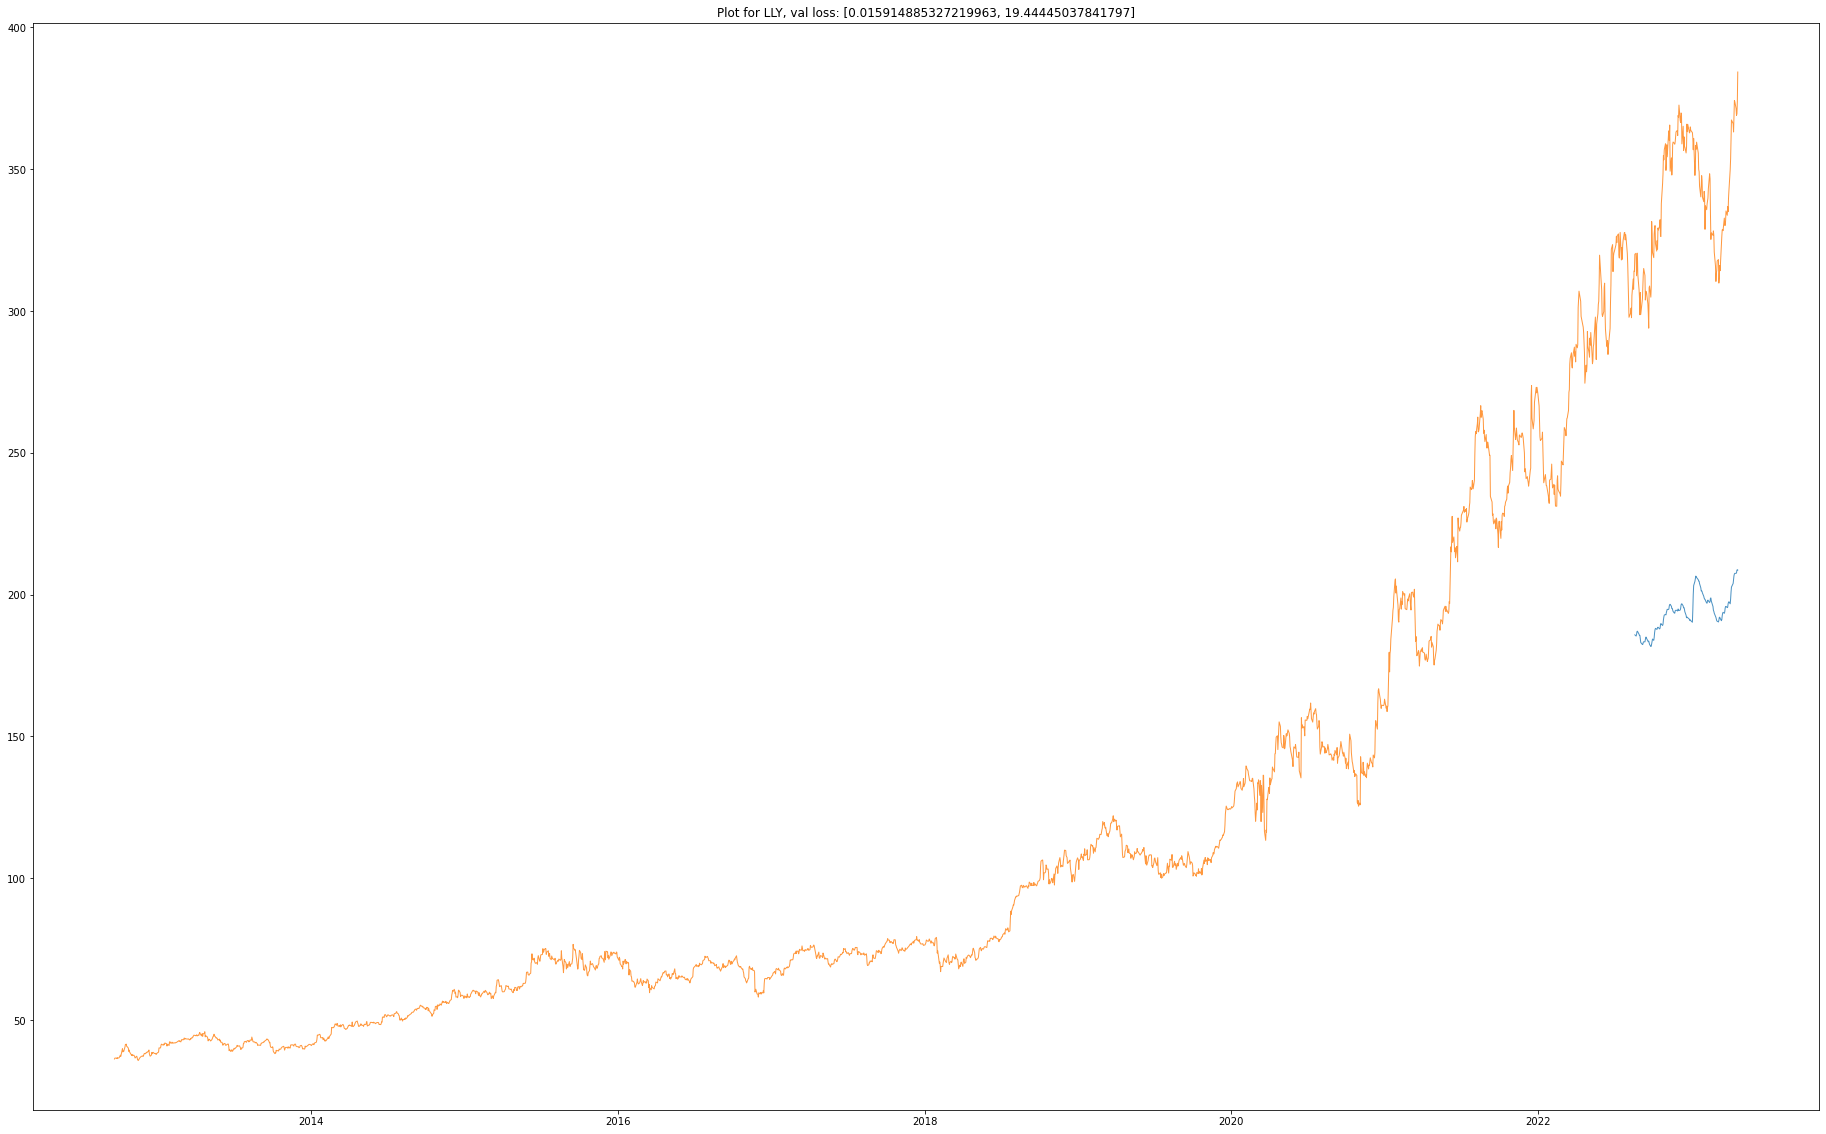

*****Training for PG
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0106 - mean_absolute_percentage_error: 37.7251 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 12.0057
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0218 - mean_absolute_percentage_error: 60.1719 - val_loss: 0.0385 - val_mean_absolute_percentage_error: 20.2361
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0243 - mean_absolute_percentage_error: 66.1621 - val_loss: 0.0284 - val_mean_absolute_percentage_error: 16.9781
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0210 - mean_absolute_percentage_error: 59.5634 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 12.6406
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0190 - mean_absolute_percentage_error: 57.0392 - val_loss: 0.0187 - val_mean_absolute_percentage_error: 13.0723
Epoch 6/50
114/114 [==============

114/114 [==============================] - 3s 25ms/step - loss: 9.9623e-04 - mean_absolute_percentage_error: 8.8315 - val_loss: 0.0090 - val_mean_absolute_percentage_error: 7.9418
Epoch 45/50
114/114 [==============================] - 3s 25ms/step - loss: 9.3556e-04 - mean_absolute_percentage_error: 9.8618 - val_loss: 0.0094 - val_mean_absolute_percentage_error: 8.3689
Epoch 46/50
114/114 [==============================] - 3s 25ms/step - loss: 8.1844e-04 - mean_absolute_percentage_error: 8.9040 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 6.1707
Epoch 47/50
114/114 [==============================] - 3s 25ms/step - loss: 7.6636e-04 - mean_absolute_percentage_error: 8.6692 - val_loss: 0.0065 - val_mean_absolute_percentage_error: 7.0295
Epoch 48/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0010 - mean_absolute_percentage_error: 9.9592 - val_loss: 0.0341 - val_mean_absolute_percentage_error: 20.0692
Epoch 49/50
114/114 [==============================] - 

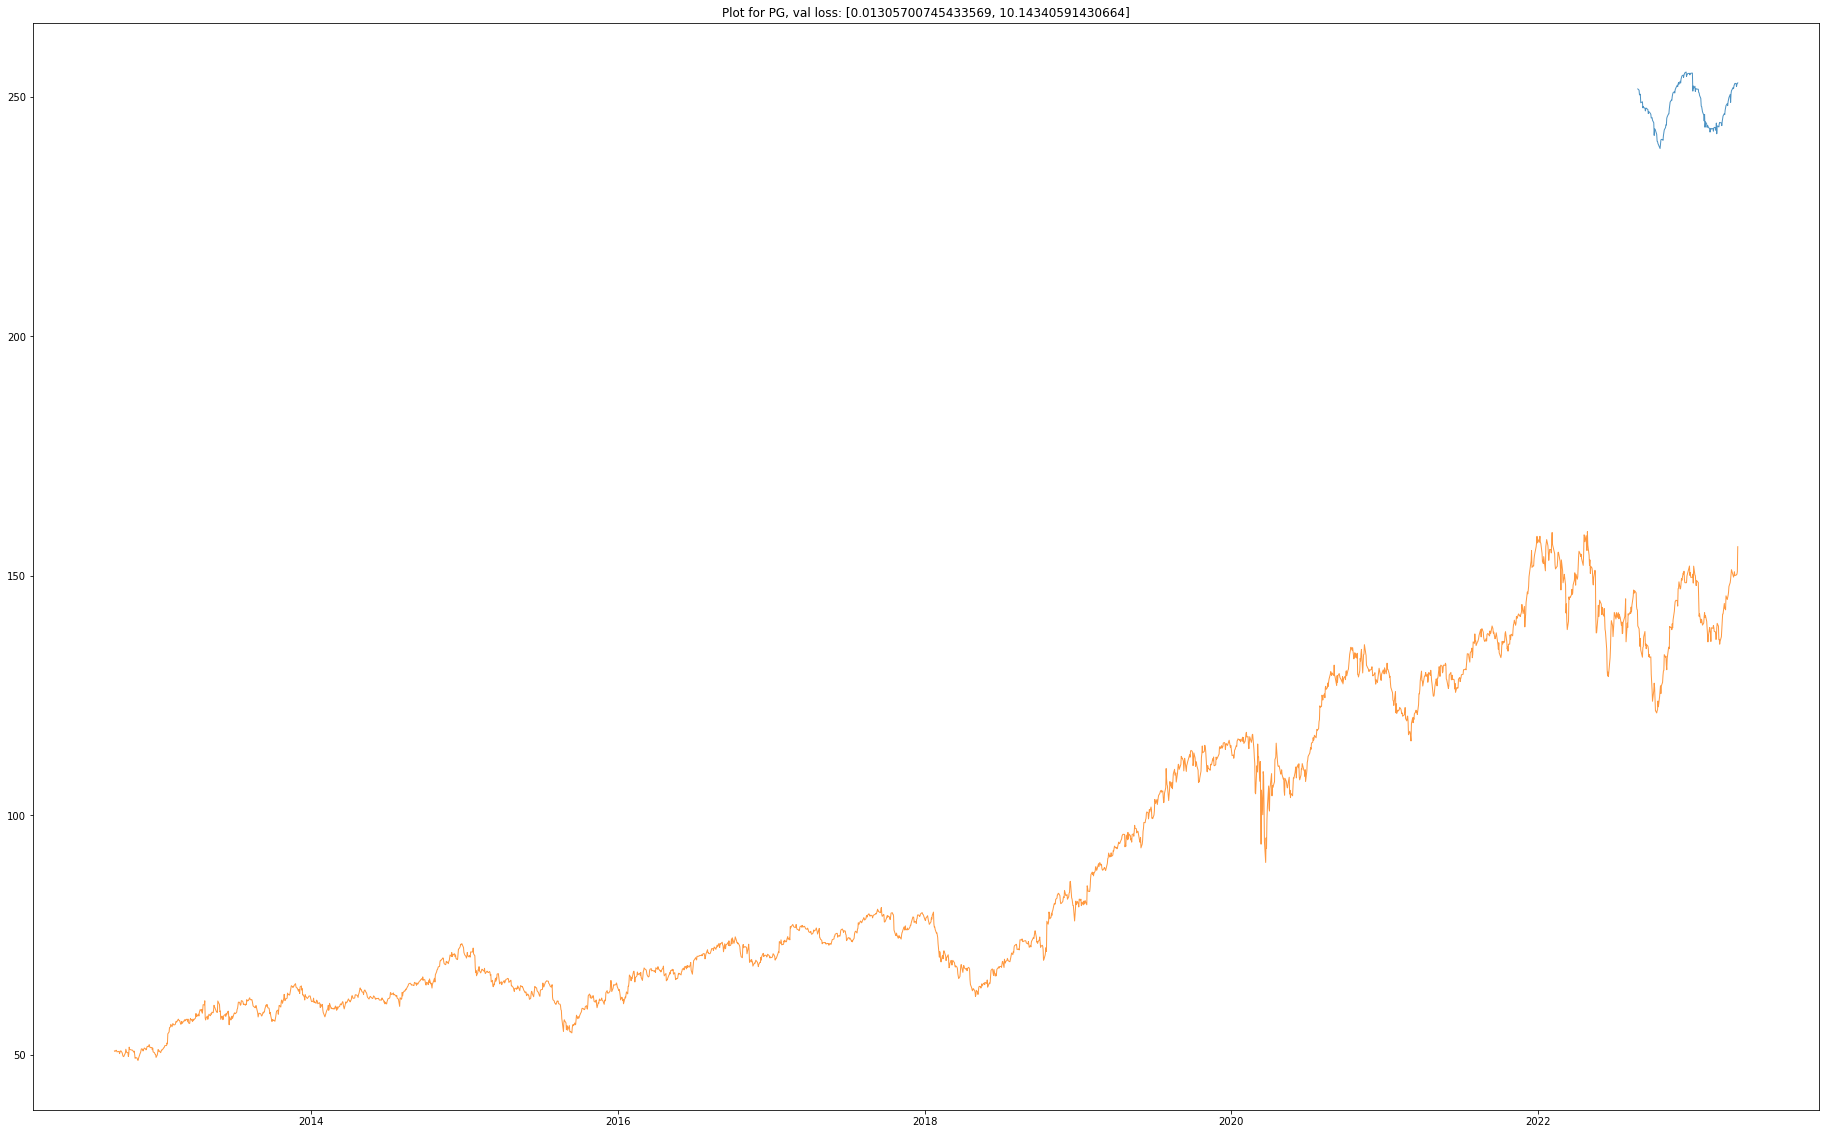

*****Training for AVGO
Epoch 1/50
114/114 [==============================] - 6s 34ms/step - loss: 0.0047 - mean_absolute_percentage_error: 87.0948 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 11.1372
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0092 - mean_absolute_percentage_error: 475.5670 - val_loss: 0.0130 - val_mean_absolute_percentage_error: 10.3073
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0043 - mean_absolute_percentage_error: 282.2615 - val_loss: 0.0146 - val_mean_absolute_percentage_error: 10.7816
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0028 - mean_absolute_percentage_error: 70.4767 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 12.8779
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0017 - mean_absolute_percentage_error: 58.4810 - val_loss: 0.0114 - val_mean_absolute_percentage_error: 9.4264
Epoch 6/50
114/114 [===========

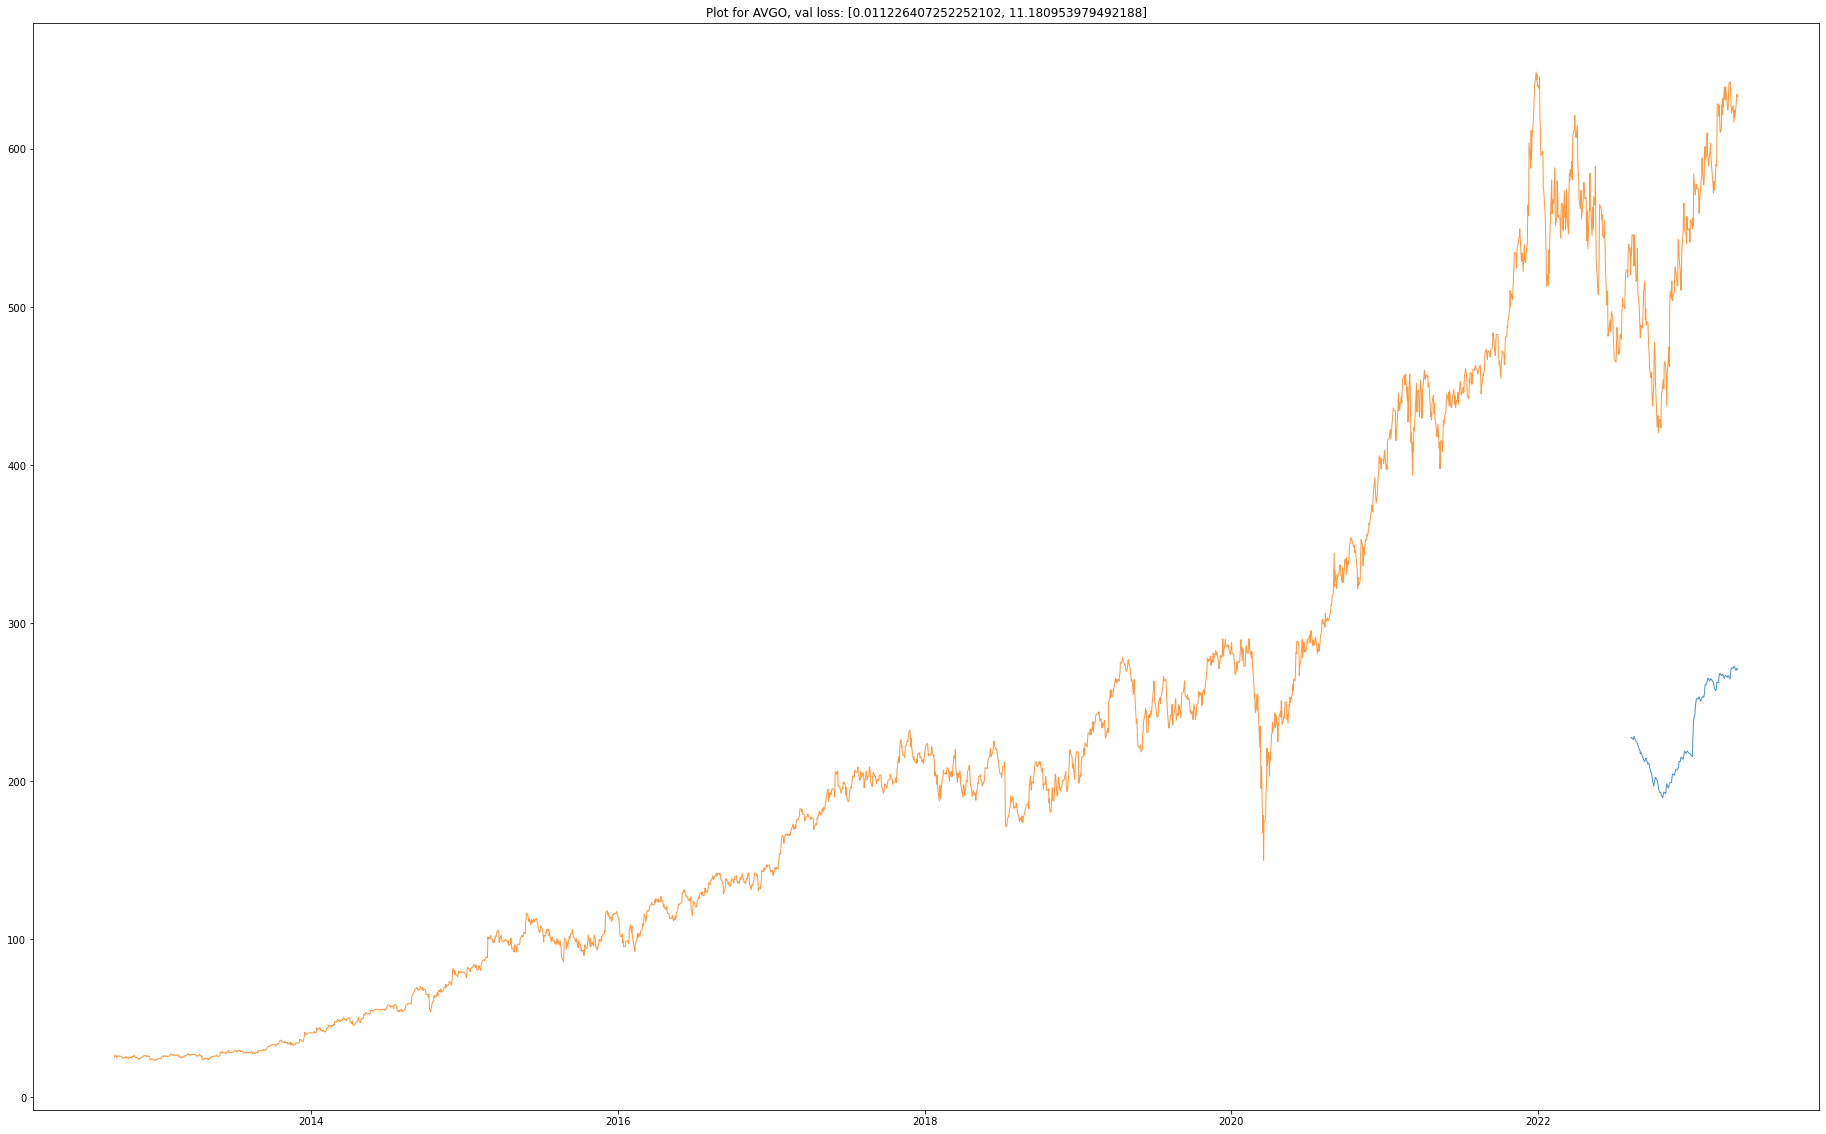

*****Training for MA
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0092 - mean_absolute_percentage_error: 40.8358 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 7.4970
Epoch 2/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0216 - mean_absolute_percentage_error: 132.5888 - val_loss: 0.0044 - val_mean_absolute_percentage_error: 6.3316
Epoch 3/50
114/114 [==============================] - 3s 28ms/step - loss: 0.0152 - mean_absolute_percentage_error: 111.2230 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 6.1631
Epoch 4/50
114/114 [==============================] - 3s 27ms/step - loss: 0.0071 - mean_absolute_percentage_error: 45.6417 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 7.0539
Epoch 5/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0037 - mean_absolute_percentage_error: 20.1294 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.0088
Epoch 6/50
114/114 [=================

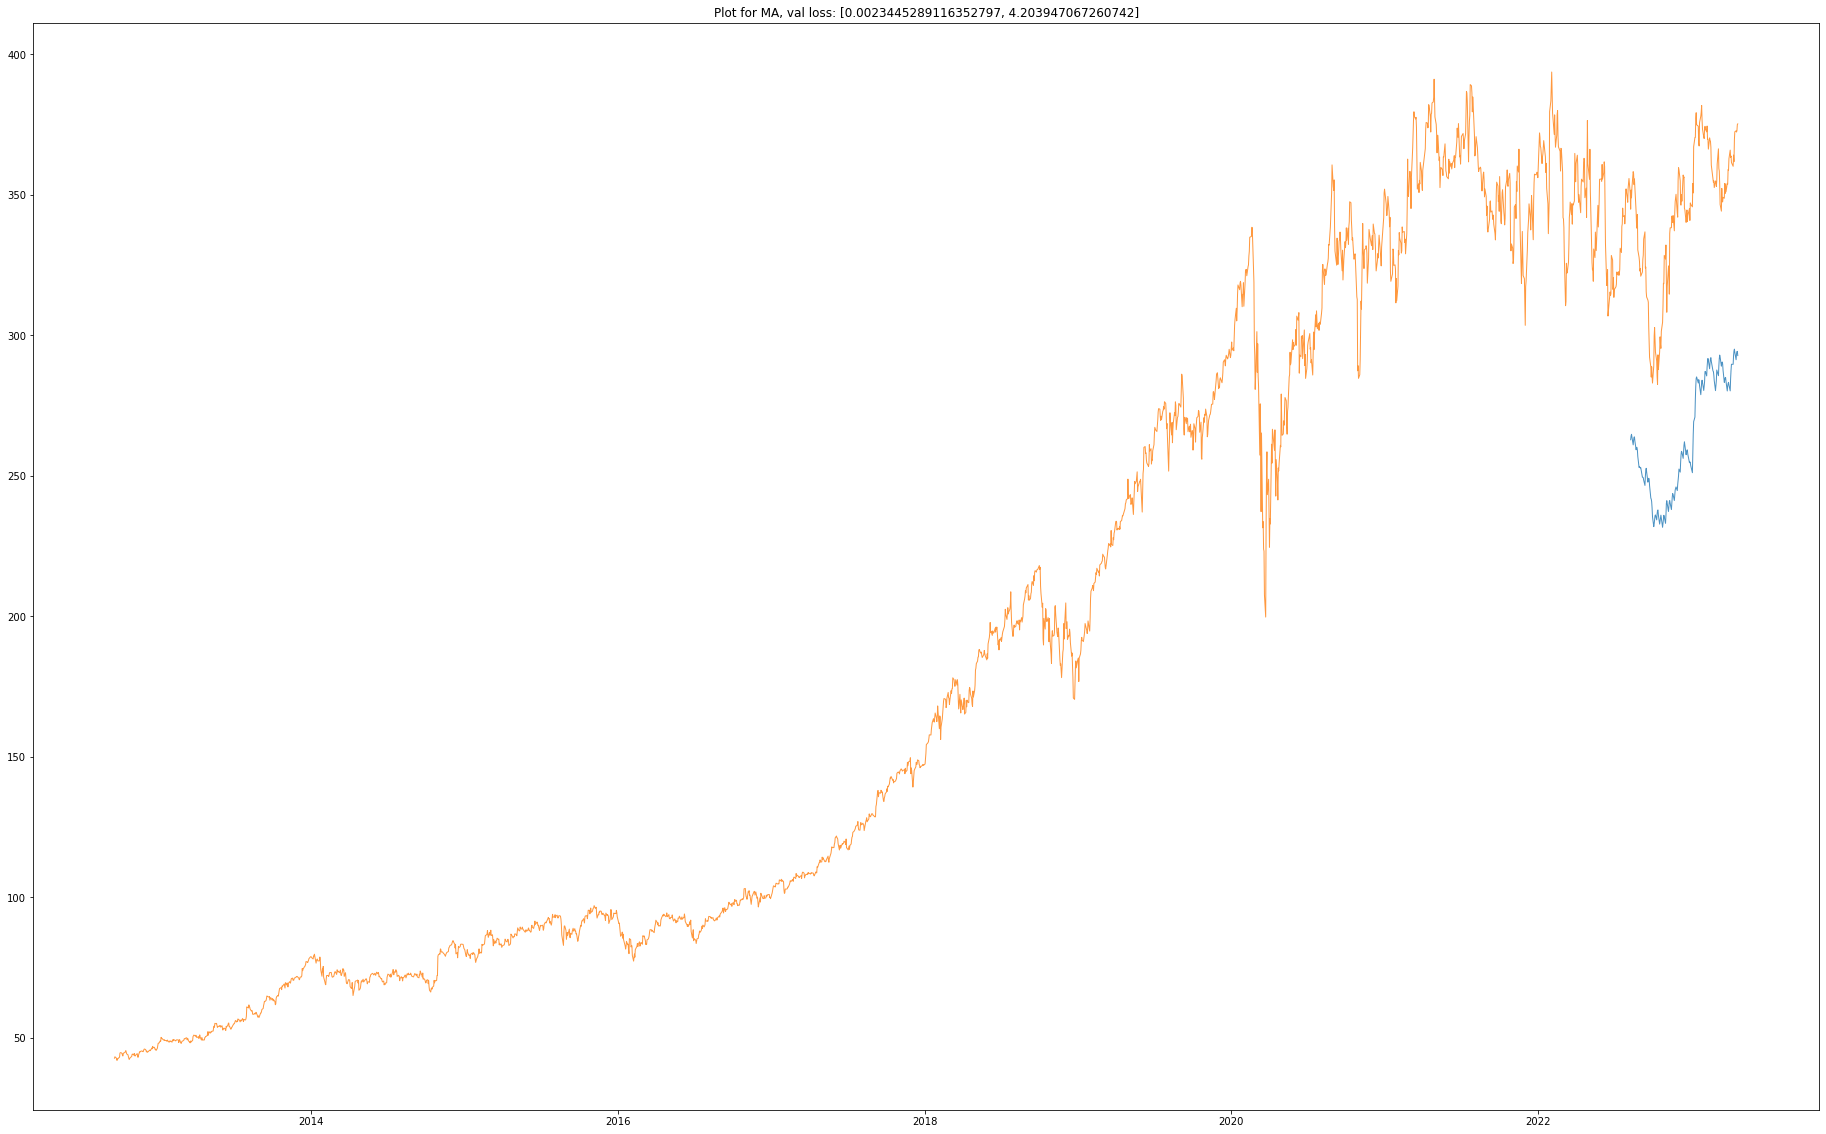

*****Training for HD
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0064 - mean_absolute_percentage_error: 38.9067 - val_loss: 0.0687 - val_mean_absolute_percentage_error: 29.4410
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0107 - mean_absolute_percentage_error: 90.2683 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 18.0562
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0158 - mean_absolute_percentage_error: 121.0320 - val_loss: 0.0425 - val_mean_absolute_percentage_error: 21.8970
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0114 - mean_absolute_percentage_error: 101.9250 - val_loss: 0.0479 - val_mean_absolute_percentage_error: 23.3511
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0064 - mean_absolute_percentage_error: 73.3509 - val_loss: 0.0329 - val_mean_absolute_percentage_error: 18.5117
Epoch 6/50
114/114 [============

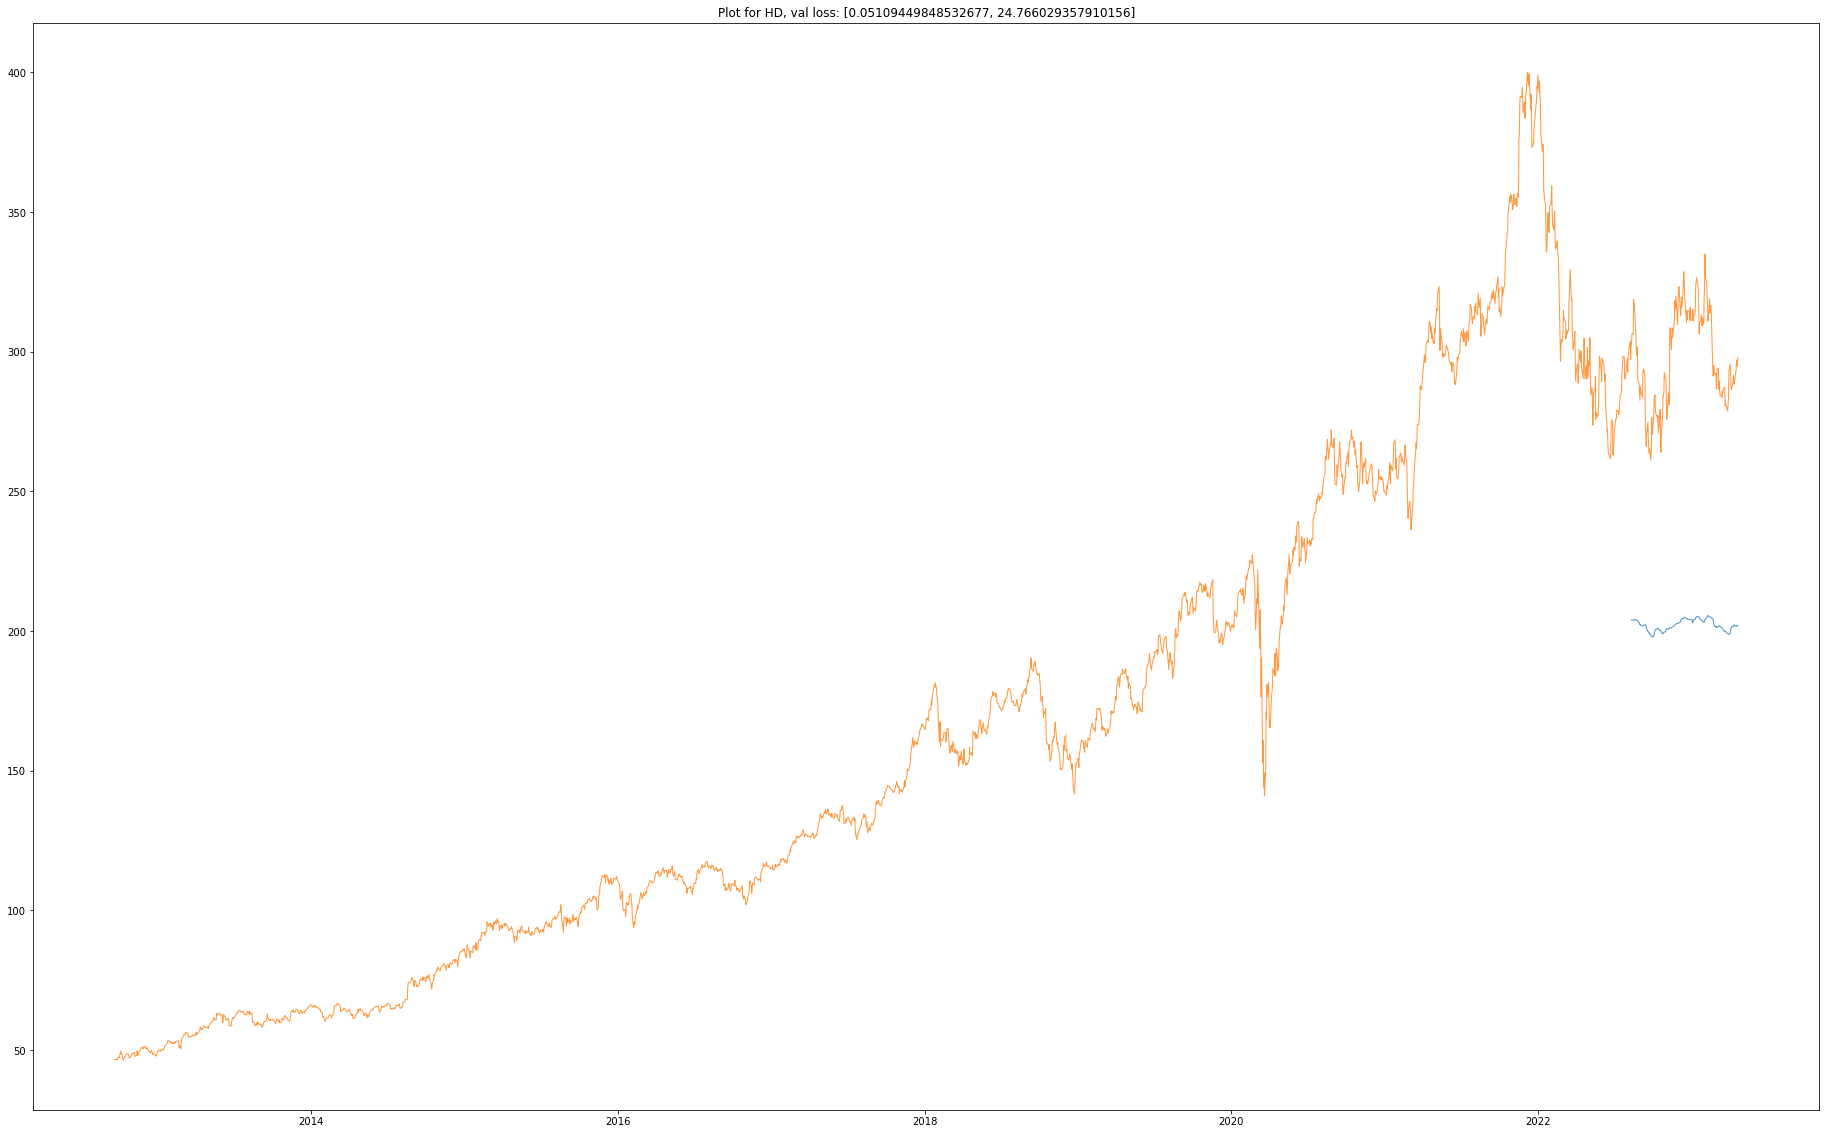

*****Training for CVX
Epoch 1/50
114/114 [==============================] - 5s 30ms/step - loss: 0.0128 - mean_absolute_percentage_error: 136014.0938 - val_loss: 0.1067 - val_mean_absolute_percentage_error: 56.1948
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0062 - mean_absolute_percentage_error: 135712.0781 - val_loss: 0.1058 - val_mean_absolute_percentage_error: 56.2894
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0045 - mean_absolute_percentage_error: 113787.2500 - val_loss: 0.0873 - val_mean_absolute_percentage_error: 49.9837
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 89534.9297 - val_loss: 0.0736 - val_mean_absolute_percentage_error: 45.6133
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0030 - mean_absolute_percentage_error: 72381.9375 - val_loss: 0.0605 - val_mean_absolute_percentage_error: 40.0870
Epoch 6/50
114/

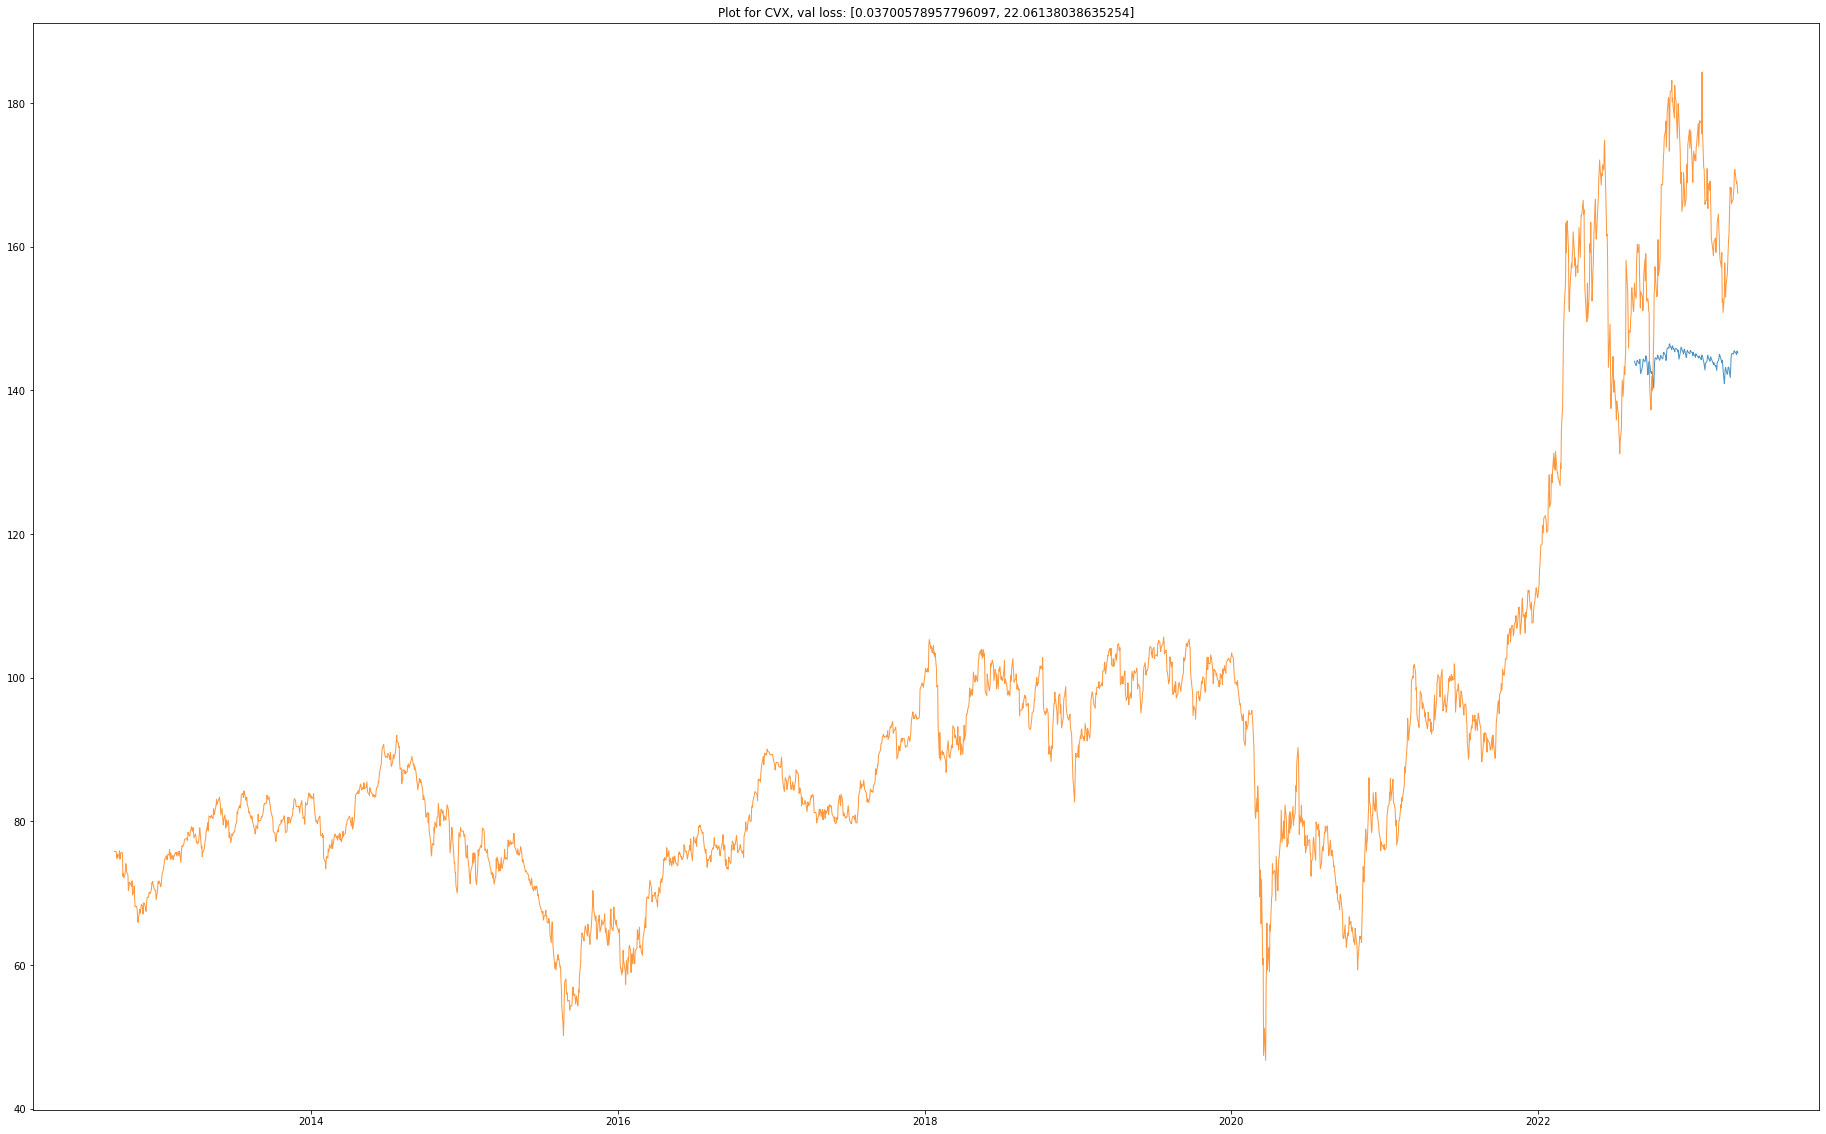

*****Training for MRK
Epoch 1/50
114/114 [==============================] - 6s 32ms/step - loss: 0.0060 - mean_absolute_percentage_error: 39.9665 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 9.5574
Epoch 2/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0121 - mean_absolute_percentage_error: 127.9509 - val_loss: 0.0056 - val_mean_absolute_percentage_error: 10.7467
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0067 - mean_absolute_percentage_error: 86.6059 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 10.9966
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 48.4441 - val_loss: 0.0062 - val_mean_absolute_percentage_error: 11.5293
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0026 - mean_absolute_percentage_error: 25.1429 - val_loss: 0.0060 - val_mean_absolute_percentage_error: 11.4337
Epoch 6/50
114/114 [=============

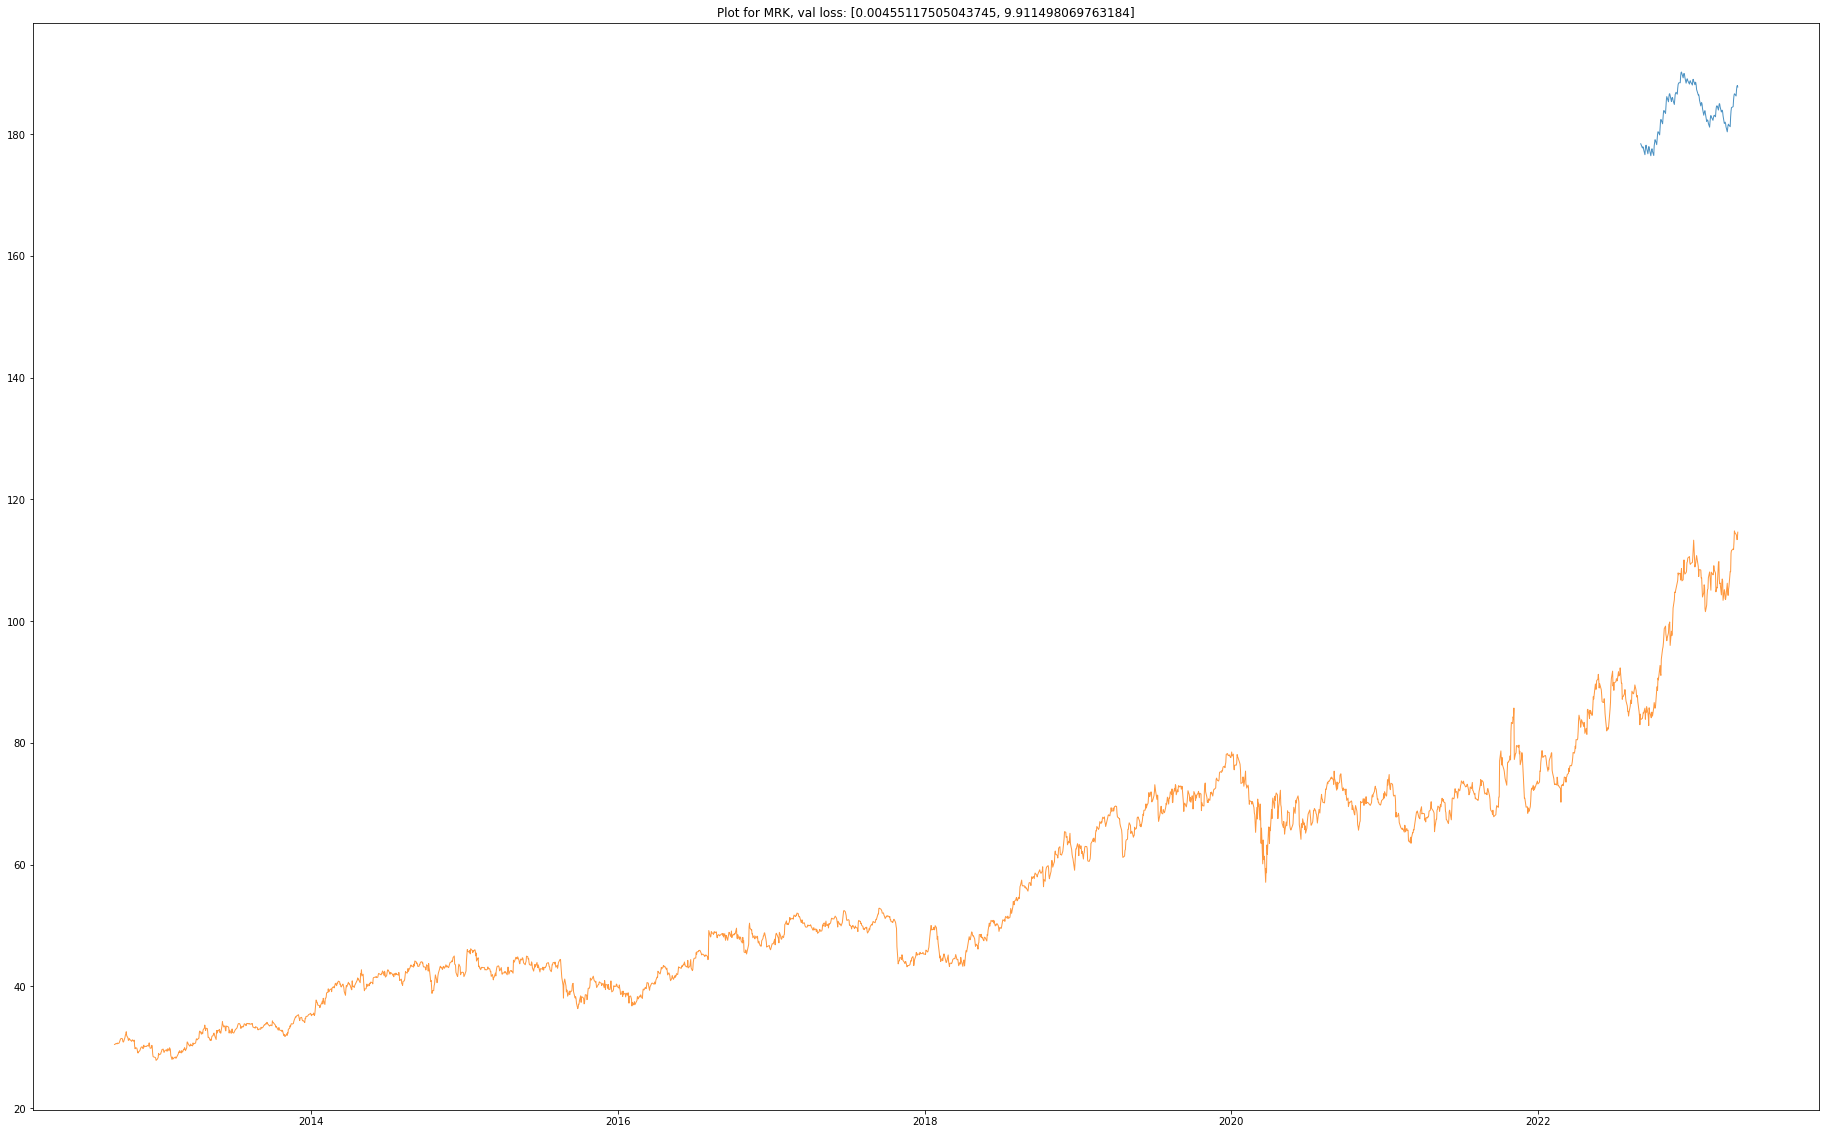

*****Training for PEP
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0072 - mean_absolute_percentage_error: 30.7061 - val_loss: 0.0402 - val_mean_absolute_percentage_error: 23.8768
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0095 - mean_absolute_percentage_error: 48.8153 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 21.6784
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0092 - mean_absolute_percentage_error: 47.9274 - val_loss: 0.0332 - val_mean_absolute_percentage_error: 21.4537
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0089 - mean_absolute_percentage_error: 46.9069 - val_loss: 0.0387 - val_mean_absolute_percentage_error: 23.4444
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0052 - mean_absolute_percentage_error: 35.0893 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 16.9078
Epoch 6/50
114/114 [=============

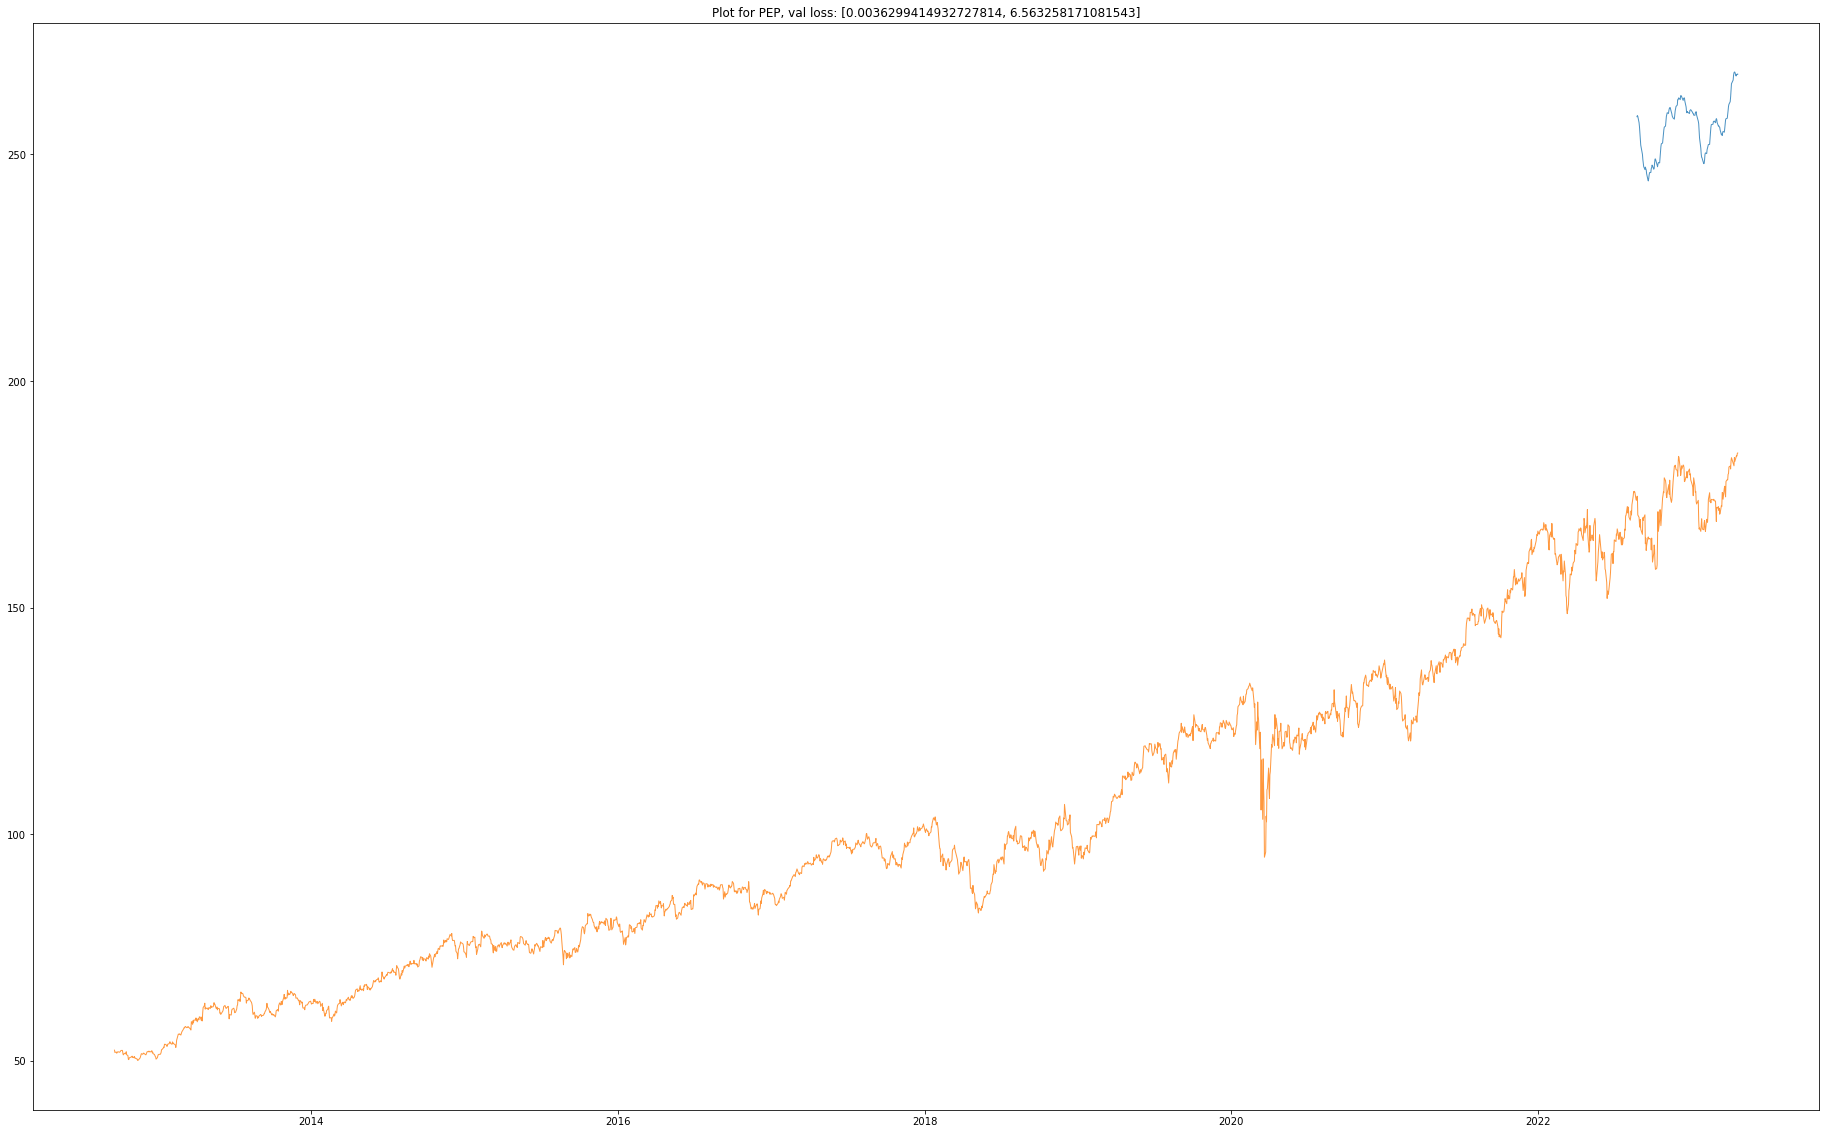

*****Training for KO
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0124 - mean_absolute_percentage_error: 38.3650 - val_loss: 0.0459 - val_mean_absolute_percentage_error: 22.9382
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0170 - mean_absolute_percentage_error: 58.5185 - val_loss: 0.0831 - val_mean_absolute_percentage_error: 33.3968
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0118 - mean_absolute_percentage_error: 48.6217 - val_loss: 0.0549 - val_mean_absolute_percentage_error: 26.4242
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0076 - mean_absolute_percentage_error: 38.9374 - val_loss: 0.0252 - val_mean_absolute_percentage_error: 16.4297
Epoch 5/50
114/114 [==============================] - 4s 32ms/step - loss: 0.0044 - mean_absolute_percentage_error: 27.2107 - val_loss: 0.0118 - val_mean_absolute_percentage_error: 10.1543
Epoch 6/50
114/114 [==============

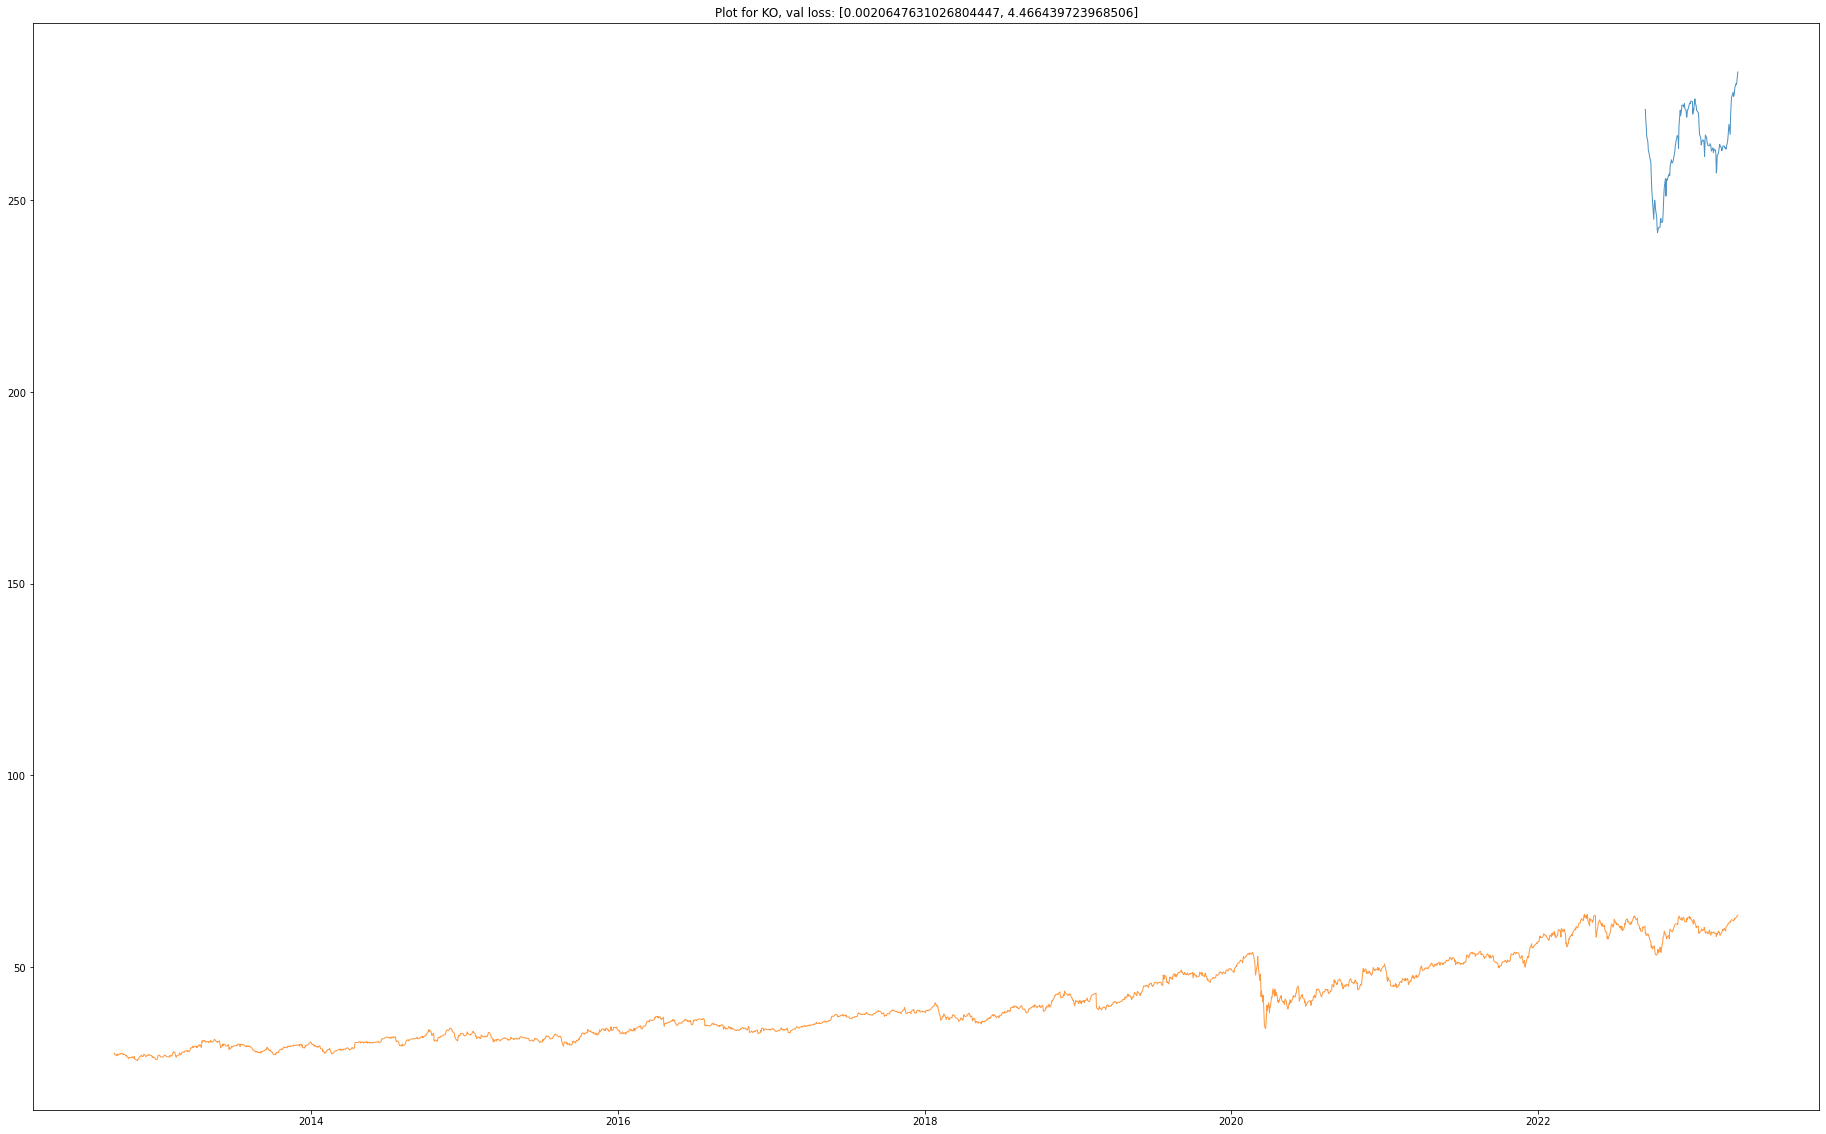

*****Training for COST
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0048 - mean_absolute_percentage_error: 44.9202 - val_loss: 0.0867 - val_mean_absolute_percentage_error: 34.4571
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0080 - mean_absolute_percentage_error: 80.3358 - val_loss: 0.0499 - val_mean_absolute_percentage_error: 24.9209
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0098 - mean_absolute_percentage_error: 99.6058 - val_loss: 0.0567 - val_mean_absolute_percentage_error: 27.0367
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0071 - mean_absolute_percentage_error: 82.7189 - val_loss: 0.0702 - val_mean_absolute_percentage_error: 30.7473
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0036 - mean_absolute_percentage_error: 55.7011 - val_loss: 0.0610 - val_mean_absolute_percentage_error: 28.5047
Epoch 6/50
114/114 [============

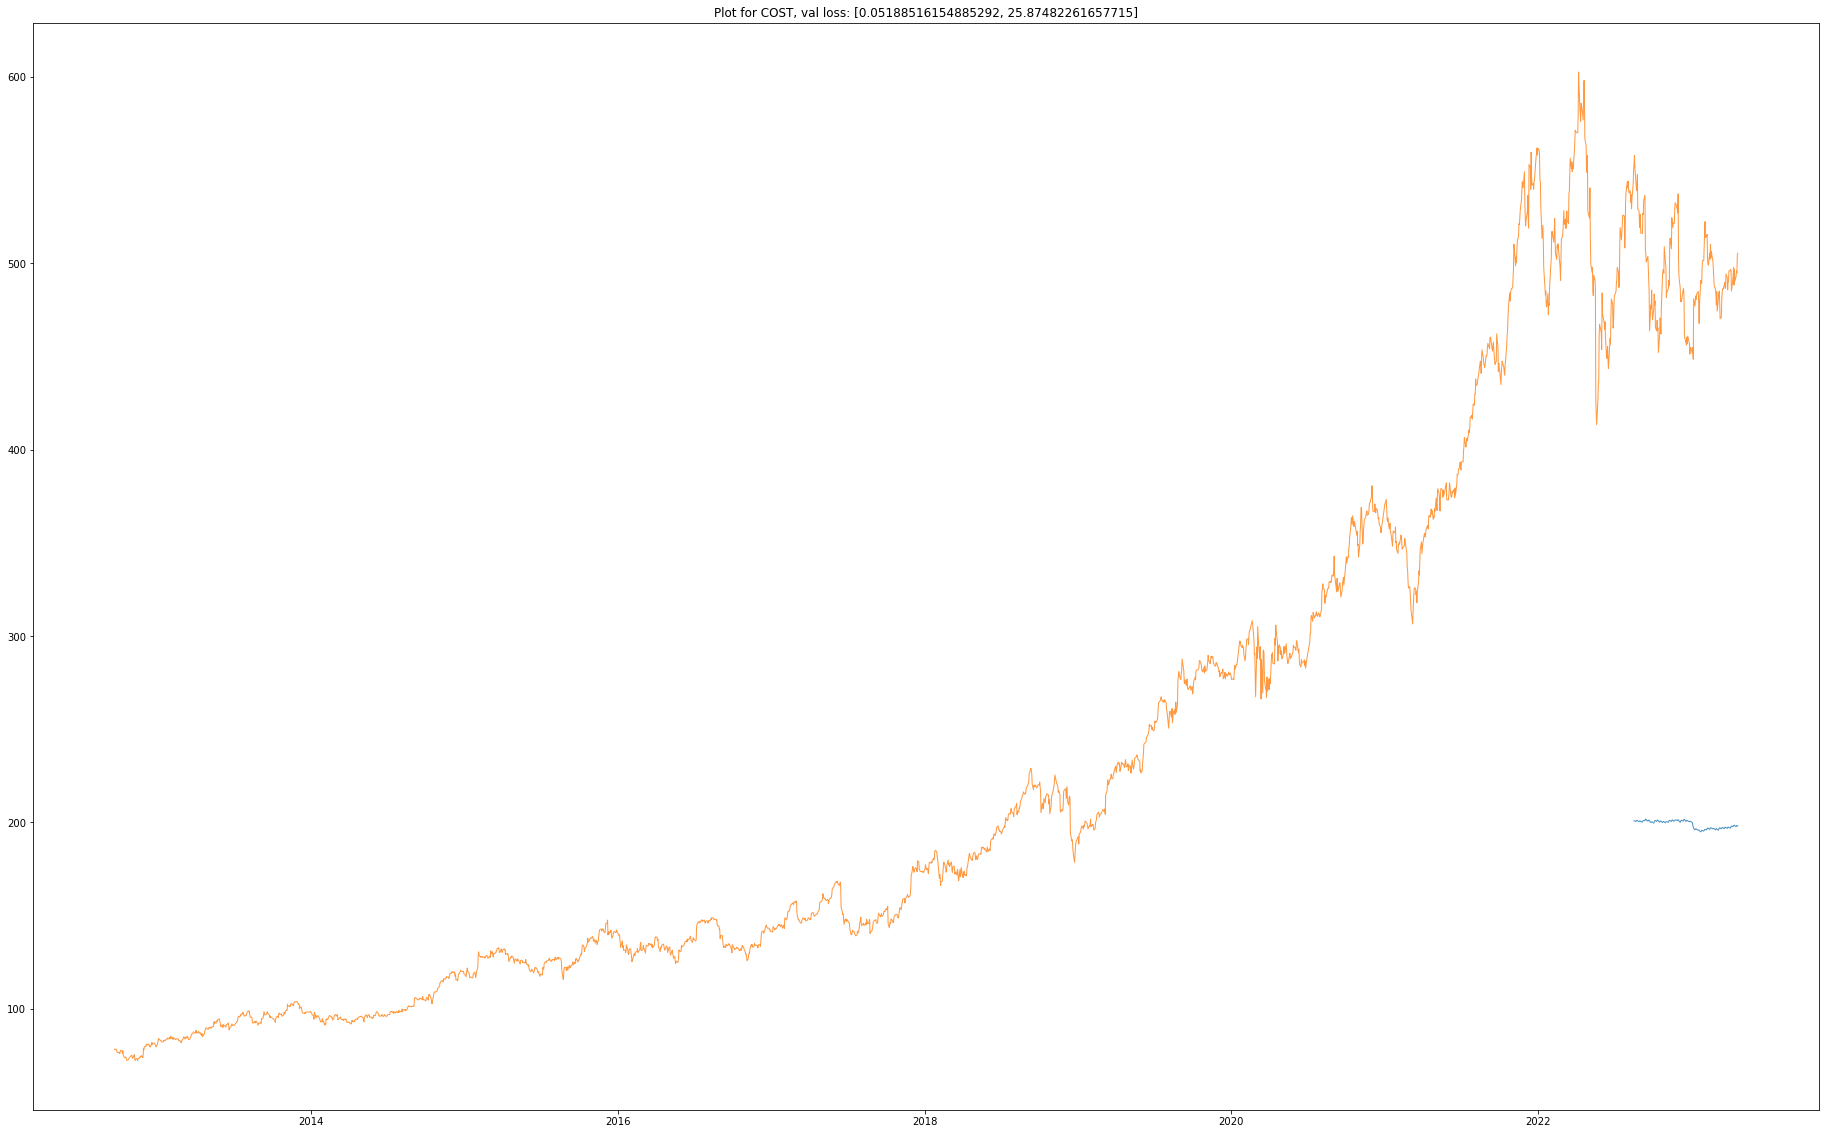

*****Training for PFE
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0065 - mean_absolute_percentage_error: 30.8818 - val_loss: 0.0953 - val_mean_absolute_percentage_error: 37.6063
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0077 - mean_absolute_percentage_error: 40.1726 - val_loss: 0.0789 - val_mean_absolute_percentage_error: 33.2876
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0065 - mean_absolute_percentage_error: 36.5737 - val_loss: 0.0802 - val_mean_absolute_percentage_error: 33.6208
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0068 - mean_absolute_percentage_error: 37.9586 - val_loss: 0.0841 - val_mean_absolute_percentage_error: 34.6863
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0066 - mean_absolute_percentage_error: 37.1519 - val_loss: 0.0931 - val_mean_absolute_percentage_error: 37.0284
Epoch 6/50
114/114 [=============

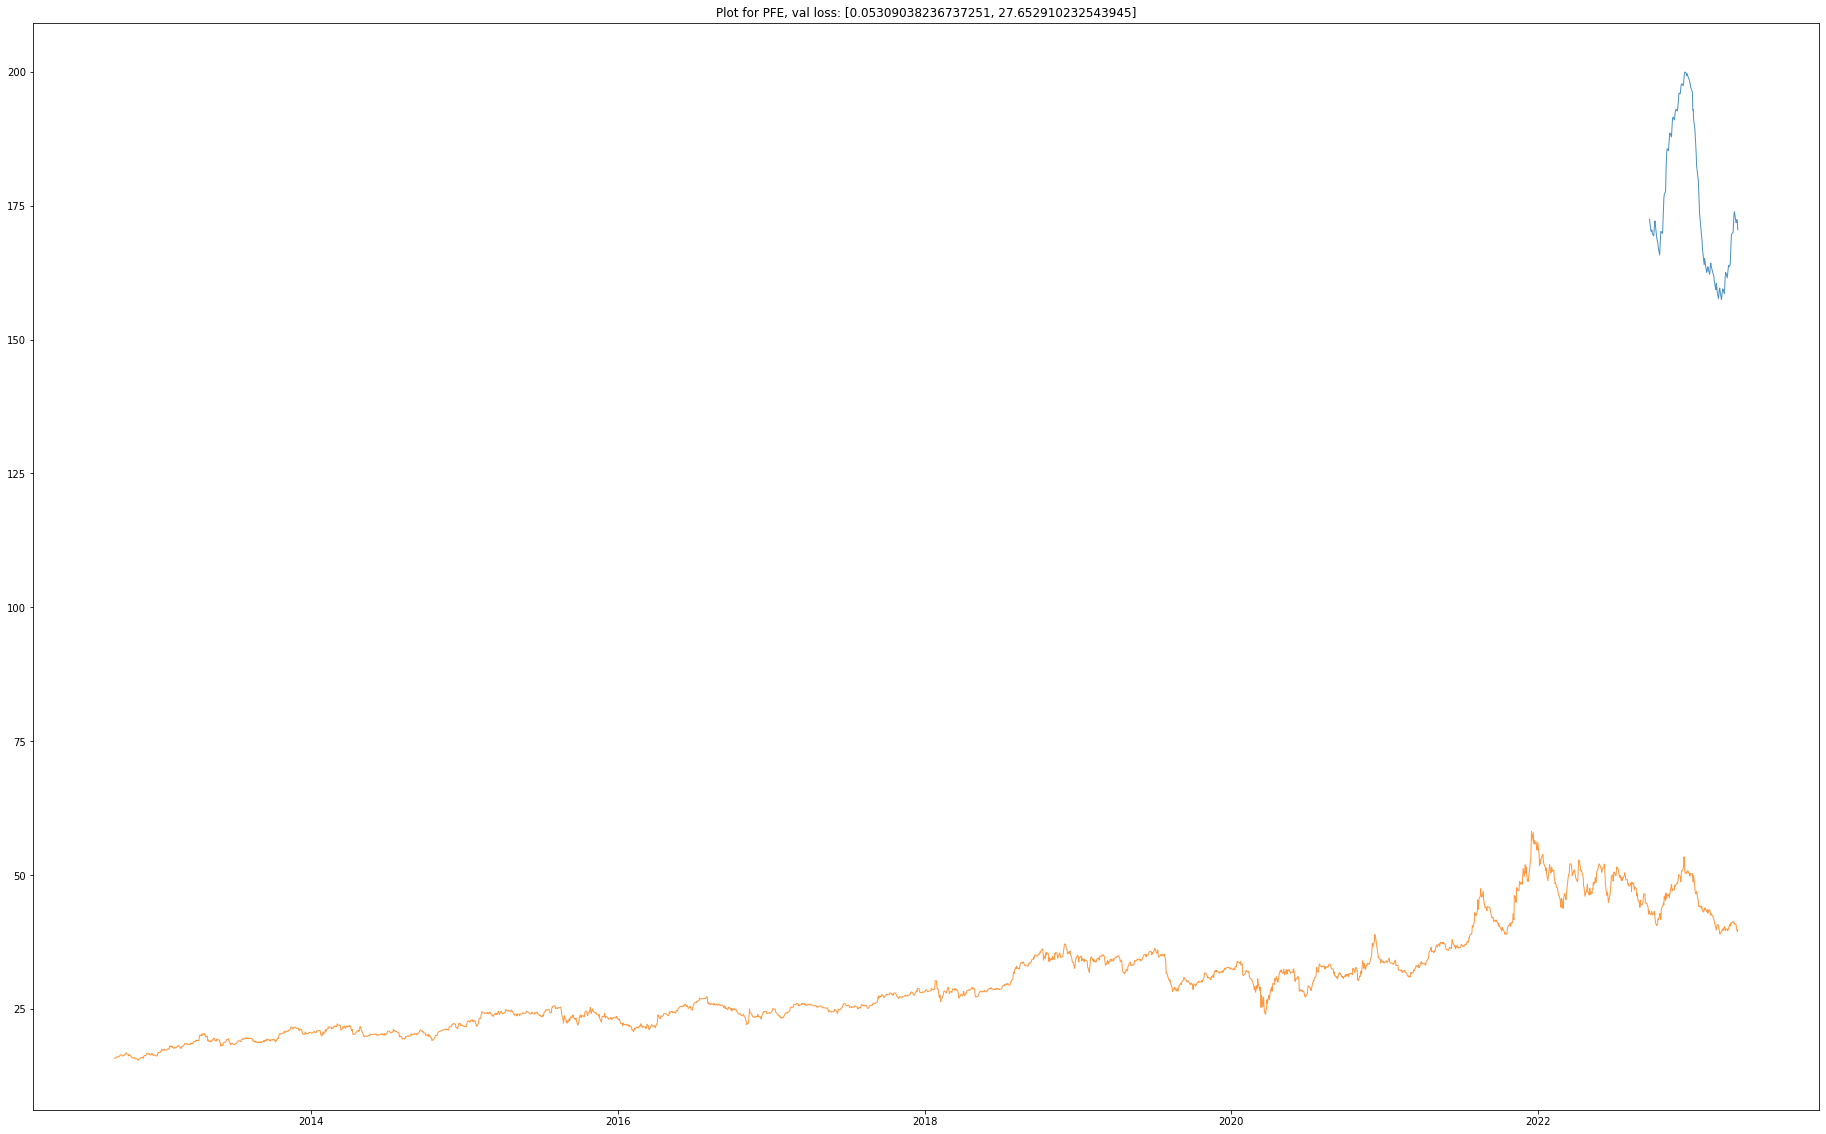

*****Training for WMT
Epoch 1/50
114/114 [==============================] - 6s 29ms/step - loss: 0.0138 - mean_absolute_percentage_error: 46753.5625 - val_loss: 0.0037 - val_mean_absolute_percentage_error: 6.1487
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0258 - mean_absolute_percentage_error: 53219.6914 - val_loss: 0.0028 - val_mean_absolute_percentage_error: 5.2382
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0271 - mean_absolute_percentage_error: 52862.5234 - val_loss: 0.0021 - val_mean_absolute_percentage_error: 4.4602
Epoch 4/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0403 - mean_absolute_percentage_error: 52365.9727 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 7.0036
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0436 - mean_absolute_percentage_error: 49372.2148 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 7.3636
Epoch 6/50
114/114 [===

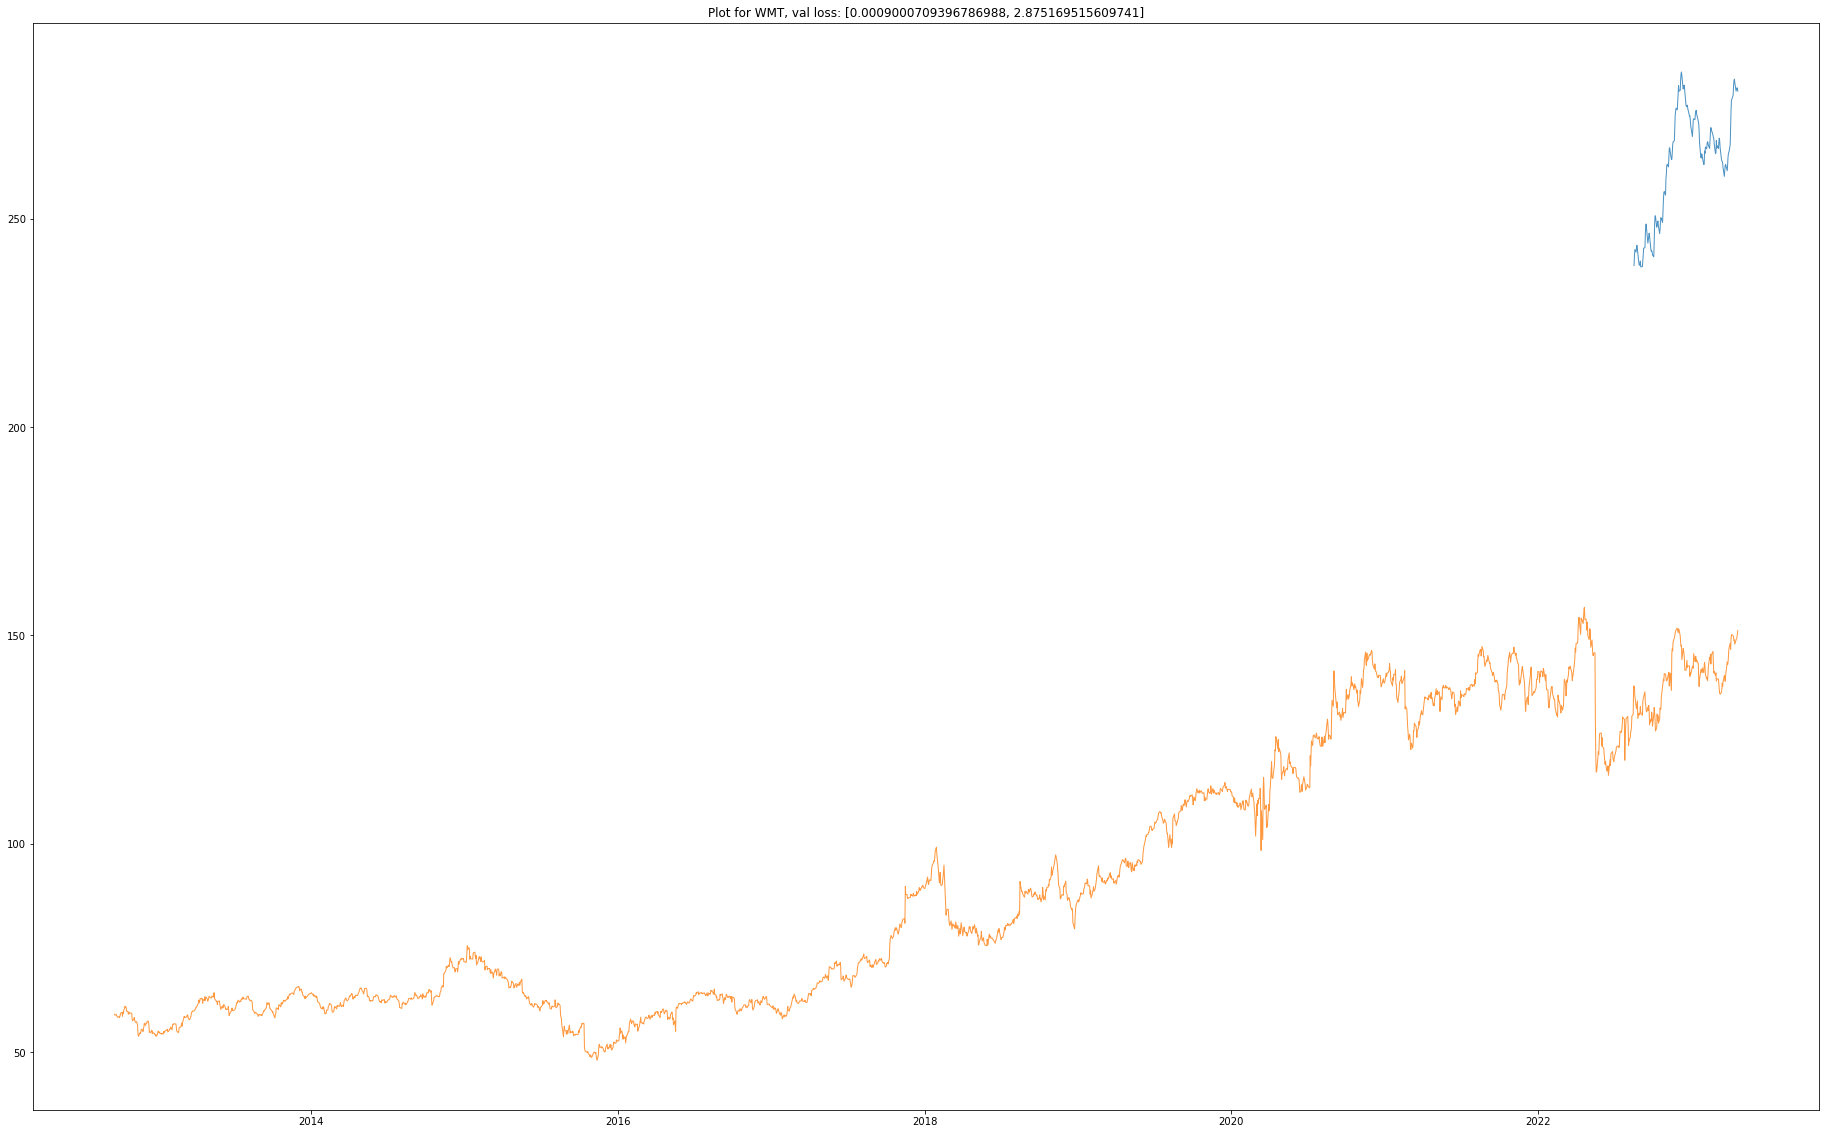

*****Training for MCD
Epoch 1/50
114/114 [==============================] - 6s 30ms/step - loss: 0.0084 - mean_absolute_percentage_error: 40.3143 - val_loss: 0.0103 - val_mean_absolute_percentage_error: 11.3426
Epoch 2/50
114/114 [==============================] - 3s 27ms/step - loss: 0.0180 - mean_absolute_percentage_error: 80.1202 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 18.0117
Epoch 3/50
114/114 [==============================] - 3s 28ms/step - loss: 0.0182 - mean_absolute_percentage_error: 81.9705 - val_loss: 0.0412 - val_mean_absolute_percentage_error: 25.2636
Epoch 4/50
114/114 [==============================] - 3s 27ms/step - loss: 0.0102 - mean_absolute_percentage_error: 62.8046 - val_loss: 0.0223 - val_mean_absolute_percentage_error: 18.1181
Epoch 5/50
114/114 [==============================] - 3s 27ms/step - loss: 0.0048 - mean_absolute_percentage_error: 41.3387 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 14.7102
Epoch 6/50
114/114 [=============

Epoch 44/50
114/114 [==============================] - 3s 25ms/step - loss: 8.2697e-04 - mean_absolute_percentage_error: 14.8410 - val_loss: 0.0035 - val_mean_absolute_percentage_error: 6.8963
Epoch 45/50
114/114 [==============================] - 3s 25ms/step - loss: 8.0168e-04 - mean_absolute_percentage_error: 14.9022 - val_loss: 0.0091 - val_mean_absolute_percentage_error: 11.4949
Epoch 46/50
114/114 [==============================] - 3s 25ms/step - loss: 9.5639e-04 - mean_absolute_percentage_error: 18.5352 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 10.5521
Epoch 47/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 23.3682 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 7.4165
Epoch 48/50
114/114 [==============================] - 3s 26ms/step - loss: 7.2790e-04 - mean_absolute_percentage_error: 16.9417 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 7.4882
Epoch 49/50
114/114 [================

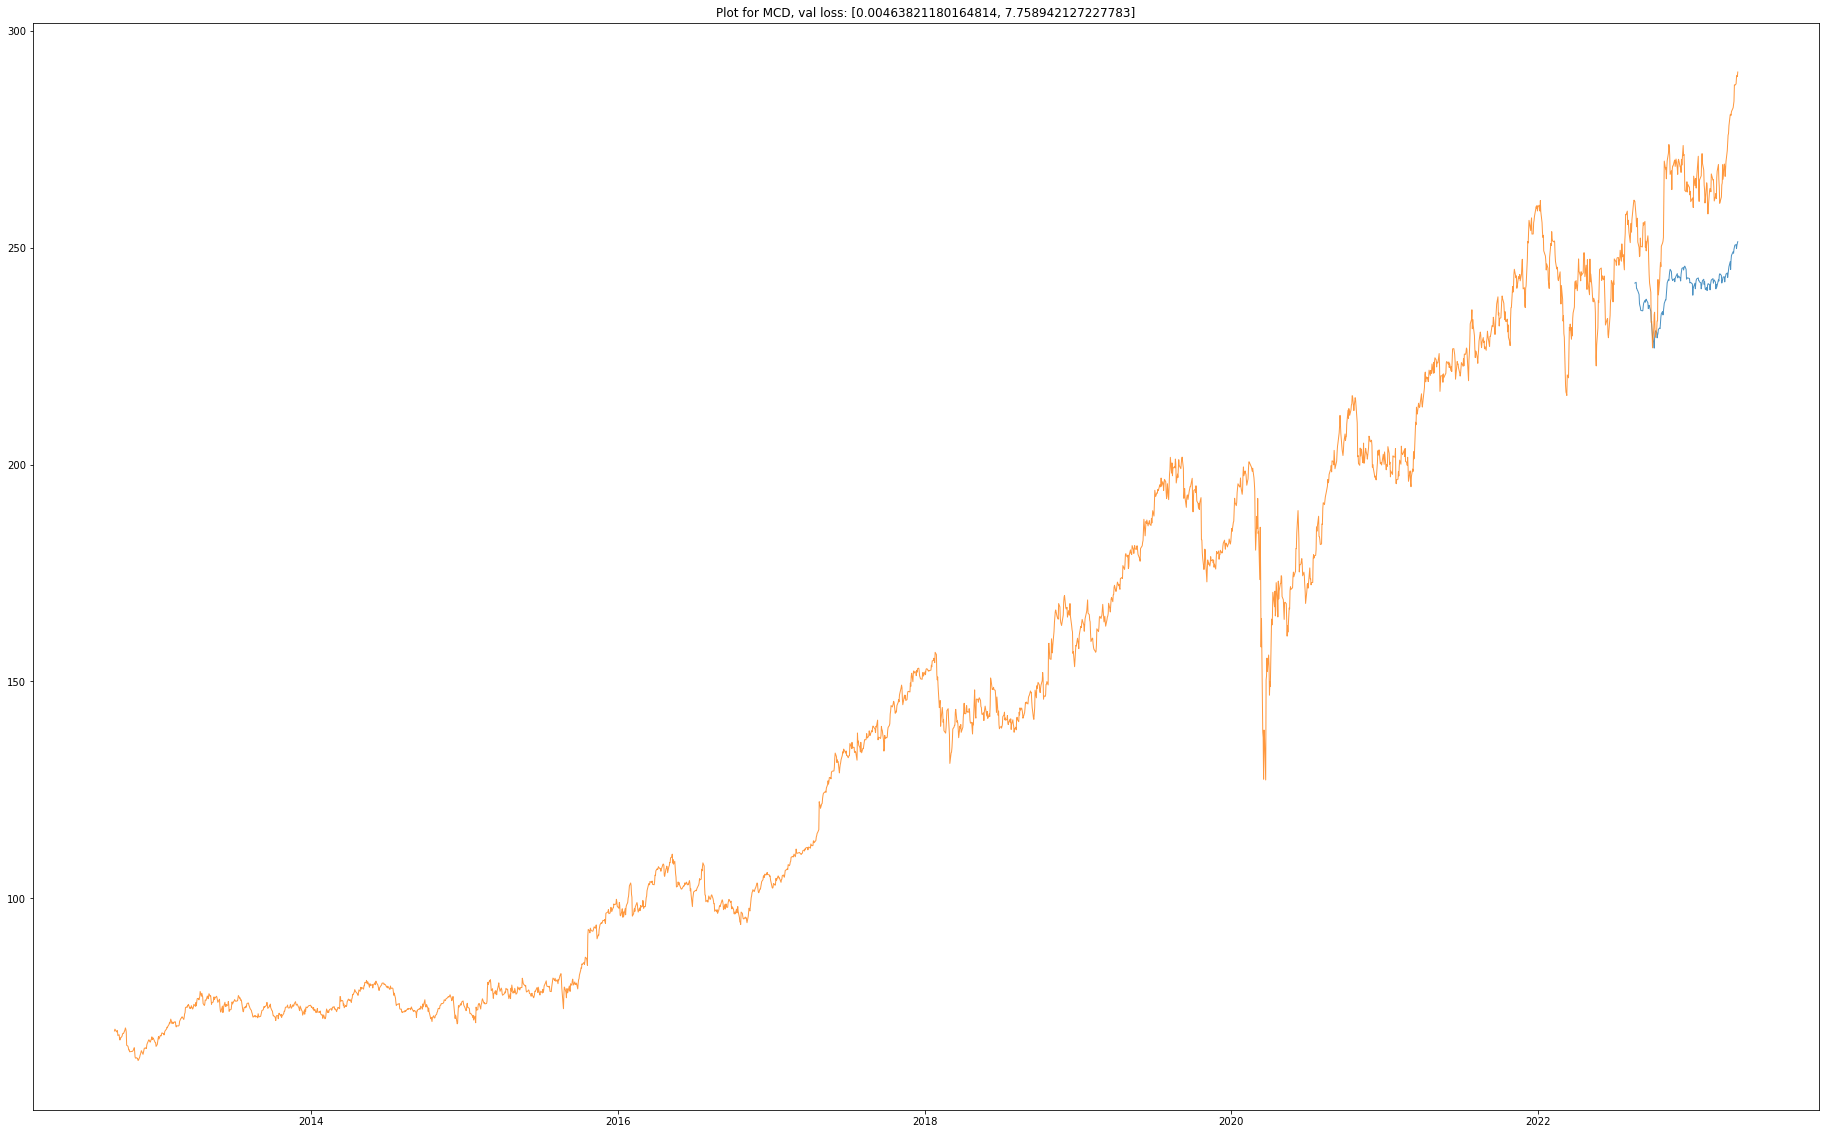

*****Training for BAC
Epoch 1/50
114/114 [==============================] - 6s 30ms/step - loss: 0.0162 - mean_absolute_percentage_error: 34.2099 - val_loss: 0.1513 - val_mean_absolute_percentage_error: 43.8295
Epoch 2/50
114/114 [==============================] - 3s 27ms/step - loss: 0.0144 - mean_absolute_percentage_error: 45.9989 - val_loss: 0.0889 - val_mean_absolute_percentage_error: 32.9917
Epoch 3/50
114/114 [==============================] - 3s 27ms/step - loss: 0.0067 - mean_absolute_percentage_error: 31.3053 - val_loss: 0.0086 - val_mean_absolute_percentage_error: 8.8847
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0053 - mean_absolute_percentage_error: 24.7105 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 6.2579
Epoch 5/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0048 - mean_absolute_percentage_error: 21.3826 - val_loss: 0.0031 - val_mean_absolute_percentage_error: 5.4991
Epoch 6/50
114/114 [================

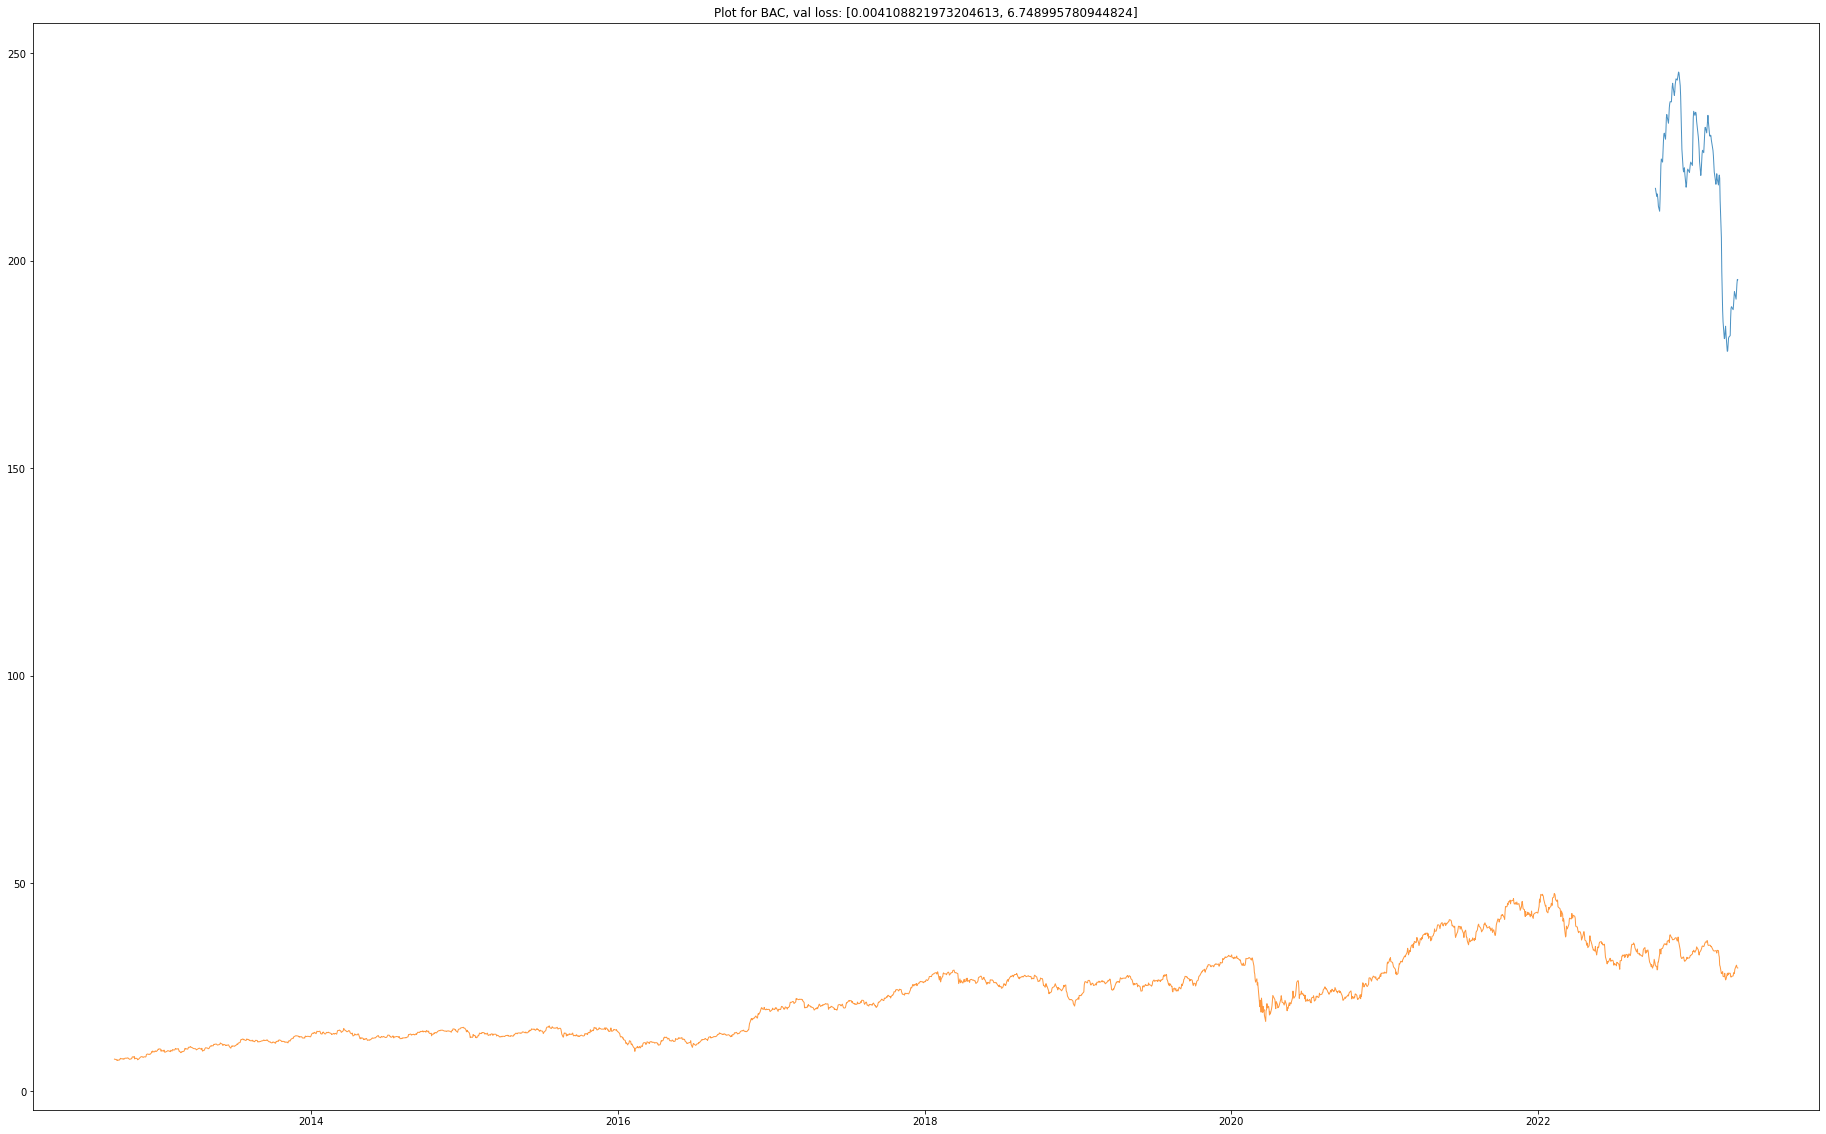

*****Training for CRM
Epoch 1/50
114/114 [==============================] - 5s 29ms/step - loss: 0.0079 - mean_absolute_percentage_error: 41.5659 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 11.7598
Epoch 2/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0166 - mean_absolute_percentage_error: 118.3622 - val_loss: 0.0143 - val_mean_absolute_percentage_error: 13.2973
Epoch 3/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0214 - mean_absolute_percentage_error: 136.4882 - val_loss: 0.0131 - val_mean_absolute_percentage_error: 12.8152
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0171 - mean_absolute_percentage_error: 131.2428 - val_loss: 0.0144 - val_mean_absolute_percentage_error: 12.6137
Epoch 5/50
114/114 [==============================] - 3s 26ms/step - loss: 0.0062 - mean_absolute_percentage_error: 65.1171 - val_loss: 0.0137 - val_mean_absolute_percentage_error: 11.2321
Epoch 6/50
114/114 [==========

114/114 [==============================] - 3s 25ms/step - loss: 8.2348e-04 - mean_absolute_percentage_error: 17.2816 - val_loss: 0.0011 - val_mean_absolute_percentage_error: 3.5651
Epoch 45/50
114/114 [==============================] - 3s 25ms/step - loss: 7.6100e-04 - mean_absolute_percentage_error: 13.8785 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 5.5064
Epoch 46/50
114/114 [==============================] - 3s 26ms/step - loss: 7.9157e-04 - mean_absolute_percentage_error: 14.1412 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 4.0308
Epoch 47/50
114/114 [==============================] - 3s 25ms/step - loss: 7.8901e-04 - mean_absolute_percentage_error: 14.8500 - val_loss: 0.0010 - val_mean_absolute_percentage_error: 3.3747
Epoch 48/50
114/114 [==============================] - 3s 25ms/step - loss: 0.0011 - mean_absolute_percentage_error: 15.8551 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 3.4754
Epoch 49/50
114/114 [==============================

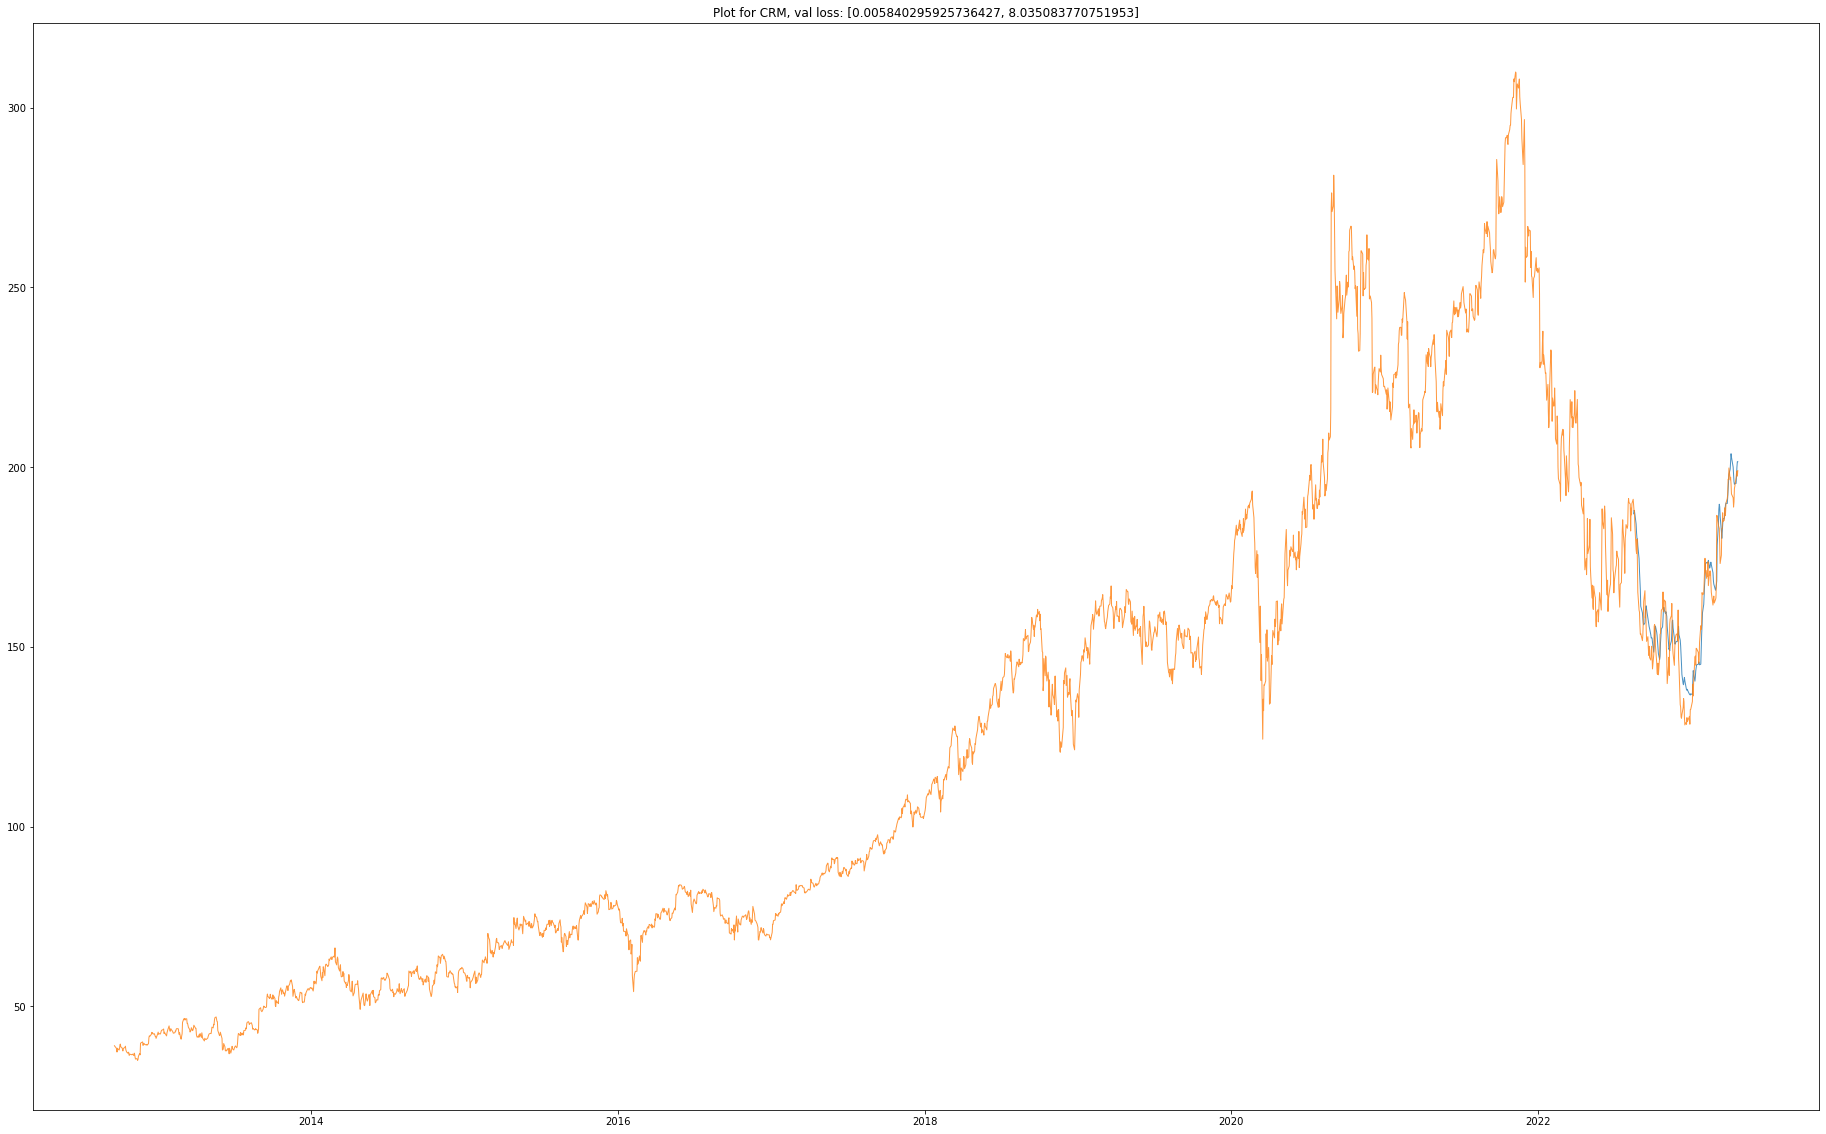

In [233]:
EPOCHS = 50
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

for i, (ticker, ds) in enumerate(stocks_data.items()):
    train_generator = ds['train_generator']
    valid_generator = ds['valid_generator']
    test_generator = ds['test_generator']
    
    OUTPUT_SIZE = 30#30#Number of days to forecast
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, 26)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(OUTPUT_SIZE))
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_percentage_error'])
    #model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
    
    # Tensorboard
    tensorboard = TensorBoard(log_dir='logs_vanilla/{}-{}'.format(ticker, time()))
    
    # Checkpoint
    filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [tensorboard,early_stopping]
    
    print('*' * 5 + 'Training for {}'.format(ticker))
    model.fit_generator(
        train_generator, 
        validation_data=valid_generator, 
        shuffle=False,
        epochs=EPOCHS, 
        verbose=1, 
        callbacks=callbacks_list
    )
    model.save(filepath)
    
    
    
    # --Plots while training
    val_loss = model.evaluate_generator(valid_generator)
    print('Val loss for {}: {}'.format(ticker, val_loss))
    
    # Make test predictions
    test_predict = model.predict_generator(test_generator)
    predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
    predicted_df = predicted_df.rename(columns={0: ticker})
    
    original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
    predicted_df.index = original_test.index
    
    predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)
    
    %matplotlib inline
    plt.figure(figsize=(15, 8))

    plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
    plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
    plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
    plt.savefig('plots/{}'.format(ticker))
    plt.show()
    #plot_model_performance(model,train_generator,test_generator,"accuracy", "val_accuracy")

In [231]:
model.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_193 (LSTM)             (None, 90, 50)            166200    
                                                                 
 lstm_194 (LSTM)             (None, 50)                20200     
                                                                 
 dense_98 (Dense)            (None, 30)                1530      
                                                                 
Total params: 187,930
Trainable params: 187,930
Non-trainable params: 0
_________________________________________________________________


## Generate Predictions for Next 30 Days:
* We are just showing one model for now.

(50.0, 350.0)

<Figure size 720x360 with 0 Axes>

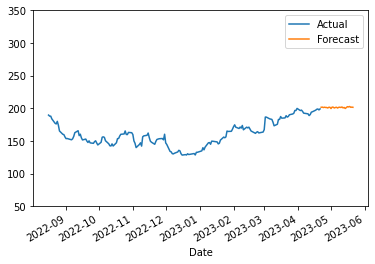

In [392]:
# Make test predictions
ticker ="CRM"
train_generator = stocks_data[ticker]['train_generator']
valid_generator = stocks_data[ticker]['valid_generator']
test_generator = stocks_data[ticker]['test_generator']
filepath='models_vanilla/{}.weights.best.hdf5'.format(ticker)
OUTPUT_SIZE = 30
    
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_length, 26)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(OUTPUT_SIZE))
    
model.load_weights(filepath)

model.compile(loss='mean_squared_error', optimizer='adam')
test_predict = model.predict_generator(test_generator)
Y_ = y_scaler.inverse_transform(test_predict)
predicted_df = pd.DataFrame(y_scaler.inverse_transform(test_predict))
predicted_df = predicted_df.rename(columns={0: ticker})
    
original_test = stocks_data[ticker]['y_test'].iloc[window_length:]
predicted_df.index = original_test.index
    
predicted_ticker = pd.concat([predicted_df[ticker], original_test], axis=1)

#predicted_ticker

df_past = predicted_ticker['Adj Close'].reset_index()
df_past.rename(columns={'index': 'Date', 'Adj Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
df_future['Forecast'] = Y_[-1].flatten()
df_future['Actual'] = np.nan
df_future

list_df = [df_past,df_future]
results = pd.concat(list_df).set_index('Date')
#([predicted_df[ticker], original_test], axis=1)
# plot the results
#results.plot()

plt.figure(figsize=(10, 5))

#plt.plot(predicted_ticker[ticker], linewidth=1, alpha=0.8)
#plt.plot(stocks_data[ticker]['y'], linewidth=1, alpha=0.8)
#plt.title('Plot for {}, val loss: {}'.format(ticker.upper(), val_loss))
#plt.savefig('plots/{}'.format(ticker))
results.plot()
plt.ylim(50, 350)

In [393]:
#stocks_data[ticker]['y_test'].iloc[90:]

In [394]:
model.summary()

Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_295 (LSTM)             (None, 90, 50)            15400     
                                                                 
 dropout_288 (Dropout)       (None, 90, 50)            0         
                                                                 
 lstm_296 (LSTM)             (None, 50)                20200     
                                                                 
 dropout_289 (Dropout)       (None, 50)                0         
                                                                 
 dense_149 (Dense)           (None, 30)                1530      
                                                                 
Total params: 37,130
Trainable params: 37,130
Non-trainable params: 0
_________________________________________________________________


In [395]:
def get_ticker_volatility(portfolio):
    tick_std = np.std(data[portfolio])
    print(tick_std)

In [396]:
get_ticker_volatility(better['Portfolio'][3])

XOM     1.673189
JPM     8.995706
V      15.732203
LLY     8.298384
dtype: float64


In [398]:
better['Portfolio_Volatility'][3]

38.13043654666929

# Conclusions
* We have built a basic framework:
    * fits LSTM models on all the stocks that are included in study.
    * Hyperparameter tuning of Models
    * Explore the models by including few variables versus all the variables that are included in this study.
    * build Returns for each individual stocks.
    * predicts combinations of stocks to build profitable portfolios based on Shapre Ratio and Voltality.
    
## Future Improvements
* Check other models such as GARCH, Random Forests etc to get prediction for stocks movement.
* Include the sentienet analysis which includes web-carpping for news.
* Also implement the information from SEC reports submitted by companies.
